In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import json
import numpy as np
import re

import string
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import pymorphy2
from pymystem3 import Mystem
from stop_words import get_stop_words
from keybert import KeyBERT
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from sklearn.preprocessing import normalize

from tqdm import tqdm

data_path = '../data/'
prepared_data = 'prepared_data/'

# Data

In [3]:
df = pd.read_csv(data_path + prepared_data + 'prepared_reviews_v4(classes).csv')

In [4]:
df['product'].value_counts()

product
debitCards             28300
creditCards             8505
credits                 3950
mortgage                3565
savings                 2744
restructing             1001
serviceLevel             708
autocredits              502
remoteService            365
other                    365
individual               158
creditRefinancing         84
moneyOrder                29
mortgageRefinancing       27
currencyExchange          26
mobile_app                25
usloviya                   3
Name: count, dtype: int64

In [5]:
df["product"] = df["product"].replace({
    "creditRefinancing": "restructing",
    "mortgageRefinancing": "mortgage",
    "usloviya": "other"
})

In [6]:
df['product'].value_counts()

product
debitCards          28300
creditCards          8505
credits              3950
mortgage             3592
savings              2744
restructing          1085
serviceLevel          708
autocredits           502
other                 368
remoteService         365
individual            158
moneyOrder             29
currencyExchange       26
mobile_app             25
Name: count, dtype: int64

In [7]:
def clean_text(text):
    text = re.sub(r'\b\d{5,}\b', '', text)  # большие числа/коды
    text = re.sub(r'\d+\s?(руб|р|₽)', '', text)  # суммы
    text = re.sub(r'\W+', ' ', text)  # спецсимволы
    return text.lower()

In [8]:
df['title'] = df['title'].astype(str).apply(clean_text)
df['text'] = df['text'].astype(str).apply(clean_text)

df["title"] = df["title"].str.replace("\xa0", " ", regex=False).str.replace("\n", " ", regex=False)
df["text"] = df["text"].str.replace("\xa0", " ", regex=False).str.replace("\n", " ", regex=False)

In [9]:
path = "../rusentilex.txt"

sentiment_words = []
with open(path, encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        # пропускаем комментарии и пустые строки
        if not line or line.startswith("!"):
            continue
        parts = [p.strip() for p in line.split(",")]
        if len(parts) < 5:
            continue
        word, pos, lemma, sentiment, source = parts[:5]
        if sentiment in ("positive", "negative", "positive/negative"):
            sentiment_words.append(lemma.lower())

sentiment_words = set(sentiment_words)
print(f"Загружено {len(sentiment_words)} оценочных слов.")

Загружено 12932 оценочных слов.


In [41]:
from pymorphy3 import MorphAnalyzer
morph = MorphAnalyzer()

In [11]:
def clean_text_from_sentiment(text):
    if not isinstance(text, str):
        return text
    # токенизация по словам (оставляем только буквы)
    tokens = re.findall(r"\b[А-Яа-яЁёA-Za-z]+\b", text.lower())
    cleaned_tokens = []
    for token in tokens:
        lemma = morph.parse(token)[0].normal_form
        # исключаем слова с эмоциональной окраской
        if lemma not in sentiment_words:
            cleaned_tokens.append(token)
    return " ".join(cleaned_tokens)

In [12]:
tqdm.pandas()  # активируем прогресс-бар для pandas

df["text_clean"] = df["text"].progress_apply(clean_text_from_sentiment)

100%|██████████| 50357/50357 [07:12<00:00, 116.45it/s]


In [13]:
df["review"] = df["title"].fillna('') + " " + df["text_clean"].fillna('')

In [14]:
df

,index,id,title,text,dateCreate,product,sub_product,source,text_clean,review
0,0,992651,не выполняют условия акции,в апреле 2025 года я рекомендовала дебетовую к...,2025-08-29T23:30:38.746003Z,debitCards,Умная карта (Премиум),sravni,в апреле года я рекомендовала дебетовую карту ...,не выполняют условия акции в апреле года я ре...
1,1,998360,жалоба на услугу газпром бонус премиум,купил услугу газпром бонус премиум за 2 цель б...,2025-09-15T09:38:13.34818Z,debitCards,Отсутствует,sravni,купил услугу газпром бонус премиум за цель был...,жалоба на услугу газпром бонус премиум купил ...
2,2,993744,банк не отвечает за слова своих сотрудников не...,хочу поделиться историей которая убила моё дов...,2025-09-02T23:21:16.507166Z,debitCards,Умная карта,sravni,хочу поделиться историей которая моё к газпром...,банк не отвечает за слова своих сотрудников не...
3,3,999494,не выполняют условия акции,в июне 2025 года я порекомендовал премиальную ...,2025-09-18T08:10:19.954986Z,debitCards,Отсутствует,sravni,в июне года я порекомендовал премиальную дебет...,не выполняют условия акции в июне года я поре...
4,4,992291,странный банк,добрый день в связи с устройством на новую раб...,2025-08-28T19:29:51.696341Z,debitCards,Отсутствует,sravni,день в связи с устройством на новую работу мне...,странный банк день в связи с устройством на но...
...,...,...,...,...,...,...,...,...,...,...
50352,50352,10885124,под видом кредита 12 9 пытаются впарить кредит...,газпромбанк тут заманивал кредитом одобренным ...,2023-04-15 23:33:45,individual,Отсутствует,banki,газпромбанк тут заманивал кредитом под пришел ...,под видом кредита 12 9 пытаются впарить кредит...
50353,50353,10872392,неполное изменение номера в офисе отделении,ситуация довольно странная для входа в интерне...,2023-03-30 12:39:01,individual,Отсутствует,banki,ситуация довольно странная для входа в интерне...,неполное изменение номера в офисе отделении си...
50354,50354,10852603,один из отличных банков,в банке нравится все и обслуживание на отлично...,2023-03-10 15:04:12,individual,Отсутствует,banki,в банке все и обслуживание на отлично и дистан...,один из отличных банков в банке все и обслужив...
50355,50355,10852597,обращение в контакт центр 10 баллов,обращение в контакт центр 10 баллов а вот рабо...,2023-03-10 14:57:02,individual,Отсутствует,banki,обращение в контакт центр баллов а вот работа ...,обращение в контакт центр 10 баллов обращение ...


# Embs

In [13]:
embedding_model = SentenceTransformer("sberbank-ai/sbert_large_nlu_ru")

In [15]:
title_emb = embedding_model.encode(df["title"].fillna("").tolist(), show_progress_bar=True)
text_emb = embedding_model.encode(df["text"].fillna("").tolist(), show_progress_bar=True)
review_emb = embedding_model.encode(df["review"].fillna("").tolist(), show_progress_bar=True)

Batches:   0%|          | 0/1574 [00:00<?, ?it/s]

Batches:   0%|          | 0/1574 [00:00<?, ?it/s]

Batches:   0%|          | 0/1574 [00:00<?, ?it/s]

In [86]:
text_clean_emb = embedding_model.encode(df["text_clean"].fillna("").tolist(), show_progress_bar=True)

Batches:   0%|          | 0/1574 [00:00<?, ?it/s]

In [88]:
embeddings_df = pd.DataFrame({
    "index": df["index"],
    'product': df['product'],
    "title_emb": list(title_emb),
    "text_emb": list(text_emb),
    "text_clean_emb": list(text_clean_emb),
    "review_emb": list(review_emb)
})

In [89]:
embeddings_df

,index,product,title_emb,text_emb,text_clean_emb,review_emb
0,0,debitCards,"[0.051036604, -0.009068704, 0.008503829, -0.01...","[0.02229691, -0.010583068, -0.039437667, -0.07...","[0.030225113, -0.01003376, -0.0430739, -0.0631...","[0.011145057, -0.006123523, -0.03536809, -0.06..."
1,1,debitCards,"[0.015996983, -0.007828684, 0.01112373, 0.0172...","[0.016987884, -0.013615291, -0.014701709, -0.0...","[0.015205965, -0.01682823, -0.028913613, -0.08...","[0.018780956, -0.016030477, -0.002965818, -0.0..."
2,2,debitCards,"[0.012914551, 0.0006493471, -0.0014109338, 0.0...","[0.034460448, 0.002235174, -0.017429916, -0.01...","[0.033313308, -0.0001363254, -0.026116777, -0....","[0.03695221, 0.004659947, -0.01718853, -0.0276..."
3,3,debitCards,"[0.051036604, -0.009068704, 0.008503829, -0.01...","[0.063142136, 0.0011819503, -0.04310136, -0.06...","[0.06753418, 0.0012016931, -0.042764112, -0.04...","[0.063056536, 0.0061492575, -0.04304014, -0.06..."
4,4,debitCards,"[0.026037993, -0.023119766, -0.021633489, 0.07...","[0.024426898, 0.011265675, -0.018272134, -0.01...","[0.025761243, 0.011036762, -0.01939701, -0.029...","[0.023636753, 0.009768195, -0.016547075, -0.01..."
...,...,...,...,...,...,...
50352,50352,individual,"[0.044476427, -0.0010636236, 0.0018056151, -0....","[0.048654858, -0.020038556, -0.027800413, -0.0...","[0.029421559, -0.02883722, -0.031013545, -0.05...","[0.04902448, -0.014900036, -0.01915634, -0.039..."
50353,50353,individual,"[0.0052785375, -0.013248491, -0.019672994, 0.0...","[0.024276542, 0.007782488, -0.013044289, -0.04...","[0.01641044, 0.0065696747, -0.018299516, -0.04...","[0.032061063, 0.005322443, -0.016263973, -0.04..."
50354,50354,individual,"[-0.005729071, -0.036345165, -0.02158594, 0.01...","[0.003383604, -0.01115171, -0.036246862, -0.03...","[0.004829605, -0.008905985, -0.052262925, -0.0...","[0.0016363098, -0.014416001, -0.04021538, -0.0..."
50355,50355,individual,"[0.026009364, -0.026335444, 0.051179856, 0.030...","[0.04457399, 0.0051947115, -0.0029530341, -0.0...","[0.055245183, -0.0028688016, -0.02198934, -0.0...","[0.044290654, 0.0076798075, -0.004706378, -0.0..."


In [90]:
embeddings_df.to_pickle(data_path + 'classes_embs/df_embs_classes.pkl')

In [15]:
embeddings_df = pd.read_pickle(data_path + 'classes_embs/df_embs_classes.pkl')

# Classes Clusterization

In [164]:
from clusterization_functions import *

In [139]:
clusterization_df = embeddings_df.merge(df[['index', 'review']], on  = 'index', how = 'inner')

In [140]:
import nltk
from nltk.corpus import stopwords
from stop_words import get_stop_words

nltk.download("stopwords")
russian_stopwords_nltk = stopwords.words("russian")

russian_stopwords = get_stop_words("russian")

russian_stopwords = russian_stopwords + russian_stopwords_nltk + ['газпромбанк']

[nltk_data] Downloading package stopwords to /home/gleb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [141]:
import string

morph = MorphAnalyzer()
punctuation = set(string.punctuation + "«»…—–,()")

def lemmatize_text(text):
    """
    Лемматизация текста с pymorphy3, фильтрация пустых токенов и знаков препинания
    Возвращает список лемм в нижнем регистре
    """
    if not isinstance(text, str):
        return []

    # токенизация: оставляем только слова (буквы)
    tokens = re.findall(r'\b[А-Яа-яЁёA-Za-z]+\b', text)
    
    # лемматизация и фильтрация
    lemmas = []
    for token in tokens:
        lemma = morph.parse(token)[0].normal_form  # берём основную лемму
        lemma = lemma.lower().strip()
        if lemma and all(c not in punctuation for c in lemma):
            lemmas.append(lemma)
    return lemmas

## Debit Cards

In [143]:
class_name = 'debitCards'
class_folder = 'debit_cards/'
data_classes_path = '../data/classes_embs/'

class_df = clusterization_df[clusterization_df['product'] == class_name]
class_df

,index,product,title_emb,text_emb,text_clean_emb,review_emb,review
0,0,debitCards,"[0.051036604, -0.009068704, 0.008503829, -0.01...","[0.02229691, -0.010583068, -0.039437667, -0.07...","[0.030225113, -0.01003376, -0.0430739, -0.0631...","[0.011145057, -0.006123523, -0.03536809, -0.06...",не выполняют условия акции в апреле года я ре...
1,1,debitCards,"[0.015996983, -0.007828684, 0.01112373, 0.0172...","[0.016987884, -0.013615291, -0.014701709, -0.0...","[0.015205965, -0.01682823, -0.028913613, -0.08...","[0.018780956, -0.016030477, -0.002965818, -0.0...",жалоба на услугу газпром бонус премиум купил ...
2,2,debitCards,"[0.012914551, 0.0006493471, -0.0014109338, 0.0...","[0.034460448, 0.002235174, -0.017429916, -0.01...","[0.033313308, -0.0001363254, -0.026116777, -0....","[0.03695221, 0.004659947, -0.01718853, -0.0276...",банк не отвечает за слова своих сотрудников не...
3,3,debitCards,"[0.051036604, -0.009068704, 0.008503829, -0.01...","[0.063142136, 0.0011819503, -0.04310136, -0.06...","[0.06753418, 0.0012016931, -0.042764112, -0.04...","[0.063056536, 0.0061492575, -0.04304014, -0.06...",не выполняют условия акции в июне года я поре...
4,4,debitCards,"[0.026037993, -0.023119766, -0.021633489, 0.07...","[0.024426898, 0.011265675, -0.018272134, -0.01...","[0.025761243, 0.011036762, -0.01939701, -0.029...","[0.023636753, 0.009768195, -0.016547075, -0.01...",странный банк день в связи с устройством на но...
...,...,...,...,...,...,...,...
31905,31905,debitCards,"[-0.021523878, -0.004950512, -0.007145636, -1....","[0.028336545, -0.007006385, -0.01460981, -0.06...","[0.02028422, -0.0031956688, -0.014699956, -0.0...","[0.017458735, -0.004633896, -0.022735229, -0.0...",visa gold не проходят онлайн оплаты в европе с...
31906,31906,debitCards,"[1.1385918e-05, -0.00012269388, 0.010162329, 0...","[0.002987348, 0.006315393, -0.0062875054, 0.00...","[0.012602574, 0.0031910564, -0.009579317, -0.0...","[0.013320655, 0.0064399987, -0.0068122256, -0....",банк не умеет вовремя выпускать карты ноября б...
31907,31907,debitCards,"[-0.02576156, -0.010708425, -0.032724738, -0.0...","[0.022887584, 0.0008934963, -0.029497229, -0.0...","[0.022156166, -0.0012332663, -0.02515401, -0.0...","[0.034445275, 0.0023058583, -0.03979544, -0.08...",услуги нет а плата есть сентября увольнялся с...
31908,31908,debitCards,"[0.009372819, -0.006926613, -0.019670477, -0.0...","[0.006914766, -0.0069458676, -0.018383265, -0....","[0.002878649, -0.0038026366, -0.027918816, -0....","[-0.0033091502, -0.0065192296, -0.023009388, -...",не снять наличные в офисе к потеряла свой пин ...


### Auto Test

In [145]:
# 1. Get UMAP embs

embeddings_text = np.vstack(class_df['text_clean_emb'].values)
embeddings_title = np.vstack(class_df['title_emb'].values)

embeddings_text_umap = get_umap_embs(
    embs = embeddings_text,
    data_path = f'{data_classes_path}{class_folder}',
    emb_type = 'text_clean',
    emb_class = class_name
)

embeddings_title_umap = get_umap_embs(
    embs = embeddings_title,
    data_path = f'{data_classes_path}{class_folder}',
    emb_type = 'title',
    emb_class = class_name
)

Save Path: ../data/classes_embs/debit_cards/text_clean_embs_debitCards.npy
Save Path: ../data/classes_embs/debit_cards/title_embs_debitCards.npy


In [158]:
# 2. Get Candidates

cluster_texts = class_df['review']

cand_embs, candidates = get_candidates(
    cluster_texts=cluster_texts,
    russian_stopwords=russian_stopwords,
    embedding_model=embedding_model,
    data_path = f'{data_classes_path}{class_folder}'
)

Candidates Save Path: ../data/classes_embs/debit_cards/candidates_embs.npy


In [154]:
# 3. Get K-means clusters

class_df = get_kmeans_clusters(
    text_type='text',
    class_df=class_df,
    embeddings_umap=embeddings_text_umap,
    n_clusters=20
)

class_df = get_kmeans_clusters(
    text_type='title',
    class_df=class_df,
    embeddings_umap=embeddings_title,
    n_clusters=20
)

In [156]:
class_df

,index,product,title_emb,text_emb,text_clean_emb,review_emb,review,text_cluster_km_id,title_cluster_km_id
0,0,debitCards,"[0.051036604, -0.009068704, 0.008503829, -0.01...","[0.02229691, -0.010583068, -0.039437667, -0.07...","[0.030225113, -0.01003376, -0.0430739, -0.0631...","[0.011145057, -0.006123523, -0.03536809, -0.06...",не выполняют условия акции в апреле года я ре...,7,11
1,1,debitCards,"[0.015996983, -0.007828684, 0.01112373, 0.0172...","[0.016987884, -0.013615291, -0.014701709, -0.0...","[0.015205965, -0.01682823, -0.028913613, -0.08...","[0.018780956, -0.016030477, -0.002965818, -0.0...",жалоба на услугу газпром бонус премиум купил ...,13,2
2,2,debitCards,"[0.012914551, 0.0006493471, -0.0014109338, 0.0...","[0.034460448, 0.002235174, -0.017429916, -0.01...","[0.033313308, -0.0001363254, -0.026116777, -0....","[0.03695221, 0.004659947, -0.01718853, -0.0276...",банк не отвечает за слова своих сотрудников не...,16,11
3,3,debitCards,"[0.051036604, -0.009068704, 0.008503829, -0.01...","[0.063142136, 0.0011819503, -0.04310136, -0.06...","[0.06753418, 0.0012016931, -0.042764112, -0.04...","[0.063056536, 0.0061492575, -0.04304014, -0.06...",не выполняют условия акции в июне года я поре...,0,11
4,4,debitCards,"[0.026037993, -0.023119766, -0.021633489, 0.07...","[0.024426898, 0.011265675, -0.018272134, -0.01...","[0.025761243, 0.011036762, -0.01939701, -0.029...","[0.023636753, 0.009768195, -0.016547075, -0.01...",странный банк день в связи с устройством на но...,17,4
...,...,...,...,...,...,...,...,...,...
31905,31905,debitCards,"[-0.021523878, -0.004950512, -0.007145636, -1....","[0.028336545, -0.007006385, -0.01460981, -0.06...","[0.02028422, -0.0031956688, -0.014699956, -0.0...","[0.017458735, -0.004633896, -0.022735229, -0.0...",visa gold не проходят онлайн оплаты в европе с...,11,16
31906,31906,debitCards,"[1.1385918e-05, -0.00012269388, 0.010162329, 0...","[0.002987348, 0.006315393, -0.0062875054, 0.00...","[0.012602574, 0.0031910564, -0.009579317, -0.0...","[0.013320655, 0.0064399987, -0.0068122256, -0....",банк не умеет вовремя выпускать карты ноября б...,5,11
31907,31907,debitCards,"[-0.02576156, -0.010708425, -0.032724738, -0.0...","[0.022887584, 0.0008934963, -0.029497229, -0.0...","[0.022156166, -0.0012332663, -0.02515401, -0.0...","[0.034445275, 0.0023058583, -0.03979544, -0.08...",услуги нет а плата есть сентября увольнялся с...,19,5
31908,31908,debitCards,"[0.009372819, -0.006926613, -0.019670477, -0.0...","[0.006914766, -0.0069458676, -0.018383265, -0....","[0.002878649, -0.0038026366, -0.027918816, -0....","[-0.0033091502, -0.0065192296, -0.023009388, -...",не снять наличные в офисе к потеряла свой пин ...,7,6


In [160]:
# 4. Get Cluster Names

text_cluster_summaries = get_cluster_names(
    class_df=class_df,
    text_type='text',
    cand_embs=cand_embs,
    candidates=candidates
)

title_cluster_summaries = get_cluster_names(
    class_df=class_df,
    text_type='title',
    cand_embs=cand_embs,
    candidates=candidates
)

100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


In [173]:
save_results_cl(
    class_df=class_df,
    text_cluster_summaries=text_cluster_summaries,
    title_cluster_summaries=title_cluster_summaries,
    path_to_save=f'{data_classes_path}{class_folder}',
    class_name=class_name
)

Class DF Save Path: ../data/classes_embs/debit_cards/debitCards_class_df.pkl
Cluster Names Save Path: ../data/classes_embs/debit_cards/text_cluster_summaries
Cluster Names Save Path: ../data/classes_embs/debit_cards/title_cluster_summaries


### Texts

In [94]:
embeddings = np.vstack(class_df['text_clean_emb'].values)

In [95]:
umap_model = UMAP(
    n_neighbors=25,
    n_components=128,   # размерность после сжатия
    min_dist=0.0,
    metric="cosine",
    random_state=42
)
embeddings_umap = umap_model.fit_transform(embeddings)

In [96]:
np.save("../data/classes_embs/debit_cards/text_clean_embs_debit_cards.npy", embeddings_umap)

In [97]:
hdbscan_model = HDBSCAN(
    min_cluster_size=25,       # ловим маленькие кластеры
    min_samples=20,            # плотность точки
    metric='euclidean',           # для нормализованных эмбеддингов
    cluster_selection_method='eom',  # листья иерархии → много мелких кластеров
    prediction_data=True,
    allow_single_cluster=False
)

labels = hdbscan_model.fit_predict(embeddings_umap)

# Сколько кластеров получилось
print("Число кластеров (не включая шум):", len(set(labels)) - (1 if -1 in labels else 0))
print("Размеры кластеров:", np.bincount(labels[labels >= 0]))
print("Количество шумовых точек:", np.sum(labels == -1))

Число кластеров (не включая шум): 5
Размеры кластеров: [ 7575    74 14321  6221    60]
Количество шумовых точек: 49


In [99]:
class_df['text_cluster_id'] = labels

In [101]:
class_df.head(3)

,index,product,title_emb,text_emb,text_clean_emb,review_emb,review,text_cluster_id
0,0,debitCards,"[0.051036604, -0.009068704, 0.008503829, -0.01...","[0.02229691, -0.010583068, -0.039437667, -0.07...","[0.030225113, -0.01003376, -0.0430739, -0.0631...","[0.011145057, -0.006123523, -0.03536809, -0.06...",не выполняют условия акции в апреле года я ре...,0
1,1,debitCards,"[0.015996983, -0.007828684, 0.01112373, 0.0172...","[0.016987884, -0.013615291, -0.014701709, -0.0...","[0.015205965, -0.01682823, -0.028913613, -0.08...","[0.018780956, -0.016030477, -0.002965818, -0.0...",жалоба на услугу газпром бонус премиум купил ...,2
2,2,debitCards,"[0.012914551, 0.0006493471, -0.0014109338, 0.0...","[0.034460448, 0.002235174, -0.017429916, -0.01...","[0.033313308, -0.0001363254, -0.026116777, -0....","[0.03695221, 0.004659947, -0.01718853, -0.0276...",банк не отвечает за слова своих сотрудников не...,2


In [112]:
kmeans_model = KMeans(
    n_clusters=10,
    init='k-means++',
    n_init=30,
    max_iter=500,
    random_state=42,
    algorithm='elkan'
)
labels_km = kmeans_model.fit_predict(embeddings_umap)

In [113]:
class_df['text_cluster_km_id'] = labels_km

In [117]:
class_df['text_cluster_km_id'].value_counts()

text_cluster_km_id
5    4334
0    3752
3    3410
2    3060
4    2950
6    2830
1    2783
8    2208
9    1936
7    1037
Name: count, dtype: int64

In [114]:
cluster_keywords = {}
cluster_keywords_sims = {} 
docs = class_df['review'].values

for cluster_id in tqdm(class_df['text_cluster_km_id'].unique(), total = len(class_df['text_cluster_km_id'].unique())):
    # Все документы из текущего кластера
    cluster_texts = class_df[class_df['text_cluster_km_id'] == cluster_id]['review'].values
    # cluster_texts = [docs[i] for i, label in enumerate(labels) if label == cluster_id]
    # if not cluster_texts:
    #     continue

    # 🔹 2. Отбор кандидатов через CountVectorizer
    vectorizer = CountVectorizer(
        tokenizer = lemmatize_text,
        ngram_range=(1,2),      # униграммы и биграммы
        min_df=2,
        max_df=0.96,                
        stop_words=russian_stopwords    # убираем стоп-слова
    )
    vectorizer.fit(cluster_texts)
    candidates = vectorizer.get_feature_names_out()
    if len(candidates) == 0:
        print(f'Cluster_id {cluster_id}, len(candidates) == 0')
        cluster_keywords[cluster_id] = []
        continue

    # 🔹 3. Считаем центроид кластера
    doc_embs = embedding_model.encode(cluster_texts, convert_to_numpy=True, show_progress_bar=False)
    centroid = doc_embs.mean(axis=0)

    # 🔹 4. Эмбеддинги кандидатов
    cand_embs = embedding_model.encode(candidates, convert_to_numpy=True, show_progress_bar=False)

    # 🔹 5. Косинусная близость кандидатов к центроиду
    sims = cosine_similarity([centroid], cand_embs)[0]

    # 🔹 6. Топ-10 кандидатов
    top_idx = sims.argsort()[::-1][:10]
    top_candidates = [candidates[i] for i in top_idx]
    top_sims = [sims[i] for i in top_idx]

    cluster_keywords[cluster_id] = top_candidates
    cluster_keywords_sims[cluster_id] = top_sims  # сохраняем веса для топ-10 ключевых слов

100%|██████████| 10/10 [13:20<00:00, 80.07s/it]


In [115]:
for cluster_id, kws in cluster_keywords.items():
    print(f"Кластер {cluster_id}: {kws}")

Кластер 9: ['начисление кэшбэк', 'зачисление кэшбэк', 'начисление акционный', 'получение кэшбек', 'перерасчёт кэшбек', 'покупка сбермаркет', 'акция кэшбэкома', 'начисление кэшбек', 'возврат кэшбэк', 'получение кэшбэк']
Кластер 5: ['пояснение банк', 'запрос кредитный', 'транзакция банкомат', 'запрос дебетовый', 'ответ сбербанк', 'транзакция банк', 'разъяснение банк', 'банк выписка', 'банк актуализация', 'банк транзакция']
Кластер 6: ['начисление кэшбэк', 'зачисление кэшбэк', 'получение кэшбек', 'недоначисление кэшбэк', 'невыплаченный кэшбэк', 'транзакция банк', 'начисление кэшбек', 'получение кэшбэк', 'начисление акционный', 'информация банковский']
Кластер 1: ['выписка платёжный', 'выписка дебетовый', 'блокировка банковский', 'перевыпуск зарплатный', 'перевыпуск дебетовый', 'отказ дебетовый', 'банк разблокировка', 'блокировка дебетовый', 'списание дебетовый', 'транзакция банк']
Кластер 4: ['выписка банкомат', 'запрос кредитный', 'банк оповещение', 'запрос дебетовый', 'банк выписка', 'б

### Titles

In [118]:
embeddings = np.vstack(class_df['title_emb'].values)

In [119]:
umap_model = UMAP(
    n_neighbors=25,
    n_components=128,   # размерность после сжатия
    min_dist=0.0,
    metric="cosine",
    random_state=42
)
embeddings_umap = umap_model.fit_transform(embeddings)

In [120]:
np.save("../data/classes_embs/debit_cards/title_embs_debit_cards.npy", embeddings_umap)

In [ ]:
# hdbscan_model = HDBSCAN(
#     min_cluster_size=25,       # ловим маленькие кластеры
#     min_samples=20,            # плотность точки
#     metric='euclidean',           # для нормализованных эмбеддингов
#     cluster_selection_method='eom',  # листья иерархии → много мелких кластеров
#     prediction_data=True,
#     allow_single_cluster=False
# )

# labels = hdbscan_model.fit_predict(embeddings_umap)

# # Сколько кластеров получилось
# print("Число кластеров (не включая шум):", len(set(labels)) - (1 if -1 in labels else 0))
# print("Размеры кластеров:", np.bincount(labels[labels >= 0]))
# print("Количество шумовых точек:", np.sum(labels == -1))

Число кластеров (не включая шум): 5
Размеры кластеров: [ 7575    74 14321  6221    60]
Количество шумовых точек: 49


In [121]:
kmeans_model = KMeans(
    n_clusters=10,
    init='k-means++',
    n_init=30,
    max_iter=500,
    random_state=42,
    algorithm='elkan'
)
labels_km = kmeans_model.fit_predict(embeddings_umap)

In [122]:
class_df['title_cluster_km_id'] = labels_km

In [123]:
class_df['title_cluster_km_id'].value_counts()

title_cluster_km_id
1    9351
5    8486
8    5008
0    3134
2     998
9     458
4     390
6     180
3     166
7     129
Name: count, dtype: int64

In [125]:
cluster_keywords = {}
cluster_keywords_sims = {} 
docs = class_df['review'].values
cluster_labels = 'title_cluster_km_id'

for cluster_id in tqdm(class_df[cluster_labels].unique(), total = len(class_df[cluster_labels].unique())):
    # Все документы из текущего кластера
    cluster_texts = class_df[class_df[cluster_labels] == cluster_id]['review'].values
    # cluster_texts = [docs[i] for i, label in enumerate(labels) if label == cluster_id]
    # if not cluster_texts:
    #     continue

    # 🔹 2. Отбор кандидатов через CountVectorizer
    vectorizer = CountVectorizer(
        tokenizer = lemmatize_text,
        ngram_range=(1,2),      # униграммы и биграммы
        min_df=2,
        max_df=0.96,                
        stop_words=russian_stopwords    # убираем стоп-слова
    )
    vectorizer.fit(cluster_texts)
    candidates = vectorizer.get_feature_names_out()
    if len(candidates) == 0:
        print(f'Cluster_id {cluster_id}, len(candidates) == 0')
        cluster_keywords[cluster_id] = []
        continue

    # 🔹 3. Считаем центроид кластера
    doc_embs = embedding_model.encode(cluster_texts, convert_to_numpy=True, show_progress_bar=False)
    centroid = doc_embs.mean(axis=0)

    # 🔹 4. Эмбеддинги кандидатов
    cand_embs = embedding_model.encode(candidates, convert_to_numpy=True, show_progress_bar=False)

    # 🔹 5. Косинусная близость кандидатов к центроиду
    sims = cosine_similarity([centroid], cand_embs)[0]

    # 🔹 6. Топ-10 кандидатов
    top_idx = sims.argsort()[::-1][:10]
    top_candidates = [candidates[i] for i in top_idx]
    top_sims = [sims[i] for i in top_idx]

    cluster_keywords[cluster_id] = top_candidates
    cluster_keywords_sims[cluster_id] = top_sims  # сохраняем веса для топ-10 ключевых слов

100%|██████████| 10/10 [09:17<00:00, 55.80s/it]


In [131]:
cluster_texts = class_df[class_df['title_cluster_km_id'] == 1]['title_emb'].values
cluster_texts

array([array([ 0.0510366 , -0.0090687 ,  0.00850383, ...,  0.00597807,
               0.00120853,  0.02366499], shape=(1024,), dtype=float32),
       array([ 0.01291455,  0.00064935, -0.00141093, ...,  0.03069532,
              -0.02227386,  0.02717396], shape=(1024,), dtype=float32),
       array([ 0.0510366 , -0.0090687 ,  0.00850383, ...,  0.00597807,
               0.00120853,  0.02366499], shape=(1024,), dtype=float32),
       ...,
       array([-0.02152388, -0.00495051, -0.00714564, ..., -0.00895358,
              -0.05142409,  0.01860175], shape=(1024,), dtype=float32),
       array([ 1.1385918e-05, -1.2269388e-04,  1.0162329e-02, ...,
              -2.2536896e-02, -3.3613361e-02,  3.2326061e-02],
             shape=(1024,), dtype=float32)                        ,
       array([ 0.00937282, -0.00692661, -0.01967048, ..., -0.0080726 ,
              -0.05485061, -0.00460514], shape=(1024,), dtype=float32)],
      shape=(9351,), dtype=object)

In [134]:
centroid = cluster_texts.mean(axis=0)
centroid

array([ 0.02161795, -0.01665636, -0.01407844, ...,  0.00162445,
       -0.02141631,  0.01556981], shape=(1024,), dtype=float32)

In [126]:
for cluster_id, kws in cluster_keywords.items():
    print(f"Кластер {cluster_id}: {kws}")

Кластер 1: ['разблокировка банковский', 'кэшбэк игнорирование', 'выписка банковский', 'выписка платёжный', 'рассылка кредитный', 'транзакция банкомат', 'выписка транзакция', 'перевыпуск дебетовый', 'запрос кредитный', 'транзакция банк']
Кластер 5: ['перевыпуск дебетовый', 'выписка дебетовый', 'разблокировка дебетовый', 'разблокировка зарплатный', 'уведомление дебетовый', 'информация банковский', 'транзакция банк', 'выписка кредитный', 'начисление кэшбэк', 'зачисление кэшбэк']
Кластер 0: ['банк клиентоориентированность', 'банк оповещение', 'банк навязывание', 'неклиентоориентированный банк', 'банк выписка', 'зачисление кэшбэк', 'техподдержка банк', 'банк дистанционный', 'запрос кредитный', 'оповещение банк']
Кластер 8: ['запрос кредитный', 'пояснение банк', 'оформление кэшбэк', 'банк клиентоориентированность', 'оформление банковский', 'перевыпуск дебетовый', 'техподдержка банк', 'оповещение банк', 'перевыпуск зарплатный', 'зачисление кэшбэк']
Кластер 9: ['кэшбек оформление', 'наличка ба

## Credit Cards

In [174]:
class_name = 'creditCards'
class_folder = 'credit_cards/'
data_classes_path = '../data/classes_embs/'

class_df = clusterization_df[clusterization_df['product'] == class_name]
class_df

,index,product,title_emb,text_emb,text_clean_emb,review_emb,review
1855,1855,creditCards,"[0.03160654, -0.0046292413, -0.052930407, -0.0...","[-0.019861188, 0.0031297898, -0.006057188, -0....","[-0.015822165, -0.0013699781, -0.0014556148, -...","[-0.016651569, 0.0037874805, -0.009942271, -0....",обслуживание кредитной карты при посещении бан...
1856,1856,creditCards,"[0.028784119, -0.01812148, -0.03544411, 0.0366...","[0.002892709, 0.007932068, -0.010625273, -0.03...","[9.86787e-05, 0.0049150204, -0.009427862, -0.0...","[0.013055623, 0.0068676625, -0.014652718, -0.0...",обман потребителя маме пенсионеру рф оформили ...
1857,1857,creditCards,"[0.012226166, -0.028715692, -0.030493915, -0.0...","[0.021372925, 0.0040566158, -0.016152538, -0.0...","[0.02114706, 0.0039530382, -0.013886264, -0.05...","[0.023246558, -0.00014881205, -0.015455492, -0...",карточные шулеры святые люди по сравнению с га...
1858,1858,creditCards,"[0.021529913, -0.016490556, 0.012709126, 0.004...","[0.0201793, -0.009979764, -0.012298589, -0.045...","[0.023117213, -0.010961612, -0.021804122, -0.0...","[0.020242767, -0.007541854, -0.0090995105, -0....",не закрывают по запросу обманывают прошлым лет...
1859,1859,creditCards,"[0.032202553, -0.027728062, -0.04447648, 0.011...","[0.04501468, -0.0020116724, -0.024921644, -0.0...","[0.037752133, -0.009810208, -0.031875186, -0.0...","[0.044012867, 0.0034498086, -0.019375458, -0.0...",погашение задолженности я внес весь размер по ...
...,...,...,...,...,...,...,...
39801,39801,creditCards,"[0.060482908, -0.028059512, -0.057544257, -0.0...","[0.026595805, -0.020914305, -0.02187024, -0.07...","[0.03094529, -0.022182398, -0.026631994, -0.07...","[0.033750203, -0.019671055, -0.027044712, -0.0...",в газпромбанк с новыми положительными впечатле...
39802,39802,creditCards,"[0.03841819, -0.012970923, -0.0072373417, 0.02...","[-0.023866795, 0.0025847766, -0.03819841, -0.0...","[-0.01836425, -0.0012826133, -0.045900133, -0....","[-0.012877997, 0.0025313555, -0.034002483, -0....",украдены деньги со счета разбирательство 4 й м...
39803,39803,creditCards,"[0.018659817, -0.017501486, -0.021465827, -0.0...","[-0.025963457, 6.737934e-05, -0.035451148, -0....","[-0.02667088, -0.00044956297, -0.03908584, -0....","[-0.021105606, 0.0010076367, -0.03702354, -0.0...",жду карту полтора месяца июня г я подала заявк...
39804,39804,creditCards,"[0.01312675, -0.020138169, -0.016607312, 0.016...","[-0.003646937, -0.0108279055, -0.0362997, -0.0...","[-0.006748672, -0.014020797, -0.038275924, -0....","[0.010949163, -0.011248607, -0.041881416, -0.0...",кризис умов история нахожусь в израиле азмагни...


### Auto Test

In [176]:
# 1. Get UMAP embs

embeddings_text = np.vstack(class_df['text_clean_emb'].values)
embeddings_title = np.vstack(class_df['title_emb'].values)

embeddings_text_umap = get_umap_embs(
    embs = embeddings_text,
    data_path = f'{data_classes_path}{class_folder}',
    emb_type = 'text_clean',
    emb_class = class_name
)

embeddings_title_umap = get_umap_embs(
    embs = embeddings_title,
    data_path = f'{data_classes_path}{class_folder}',
    emb_type = 'title',
    emb_class = class_name
)

Save Path: ../data/classes_embs/credit_cards/text_clean_embs_creditCards.npy
Save Path: ../data/classes_embs/credit_cards/title_embs_creditCards.npy


In [177]:
# 2. Get Candidates

cluster_texts = class_df['review']

cand_embs, candidates = get_candidates(
    cluster_texts=cluster_texts,
    russian_stopwords=russian_stopwords,
    embedding_model=embedding_model,
    data_path = f'{data_classes_path}{class_folder}'
)

Candidates Save Path: ../data/classes_embs/credit_cards/candidates_embs.npy


In [178]:
# 3. Get K-means clusters

class_df = get_kmeans_clusters(
    text_type='text',
    class_df=class_df,
    embeddings_umap=embeddings_text_umap,
    n_clusters=10
)

class_df = get_kmeans_clusters(
    text_type='title',
    class_df=class_df,
    embeddings_umap=embeddings_title,
    n_clusters=10
)

In [179]:
class_df

,index,product,title_emb,text_emb,text_clean_emb,review_emb,review,text_cluster_km_id,title_cluster_km_id
1855,1855,creditCards,"[0.03160654, -0.0046292413, -0.052930407, -0.0...","[-0.019861188, 0.0031297898, -0.006057188, -0....","[-0.015822165, -0.0013699781, -0.0014556148, -...","[-0.016651569, 0.0037874805, -0.009942271, -0....",обслуживание кредитной карты при посещении бан...,4,1
1856,1856,creditCards,"[0.028784119, -0.01812148, -0.03544411, 0.0366...","[0.002892709, 0.007932068, -0.010625273, -0.03...","[9.86787e-05, 0.0049150204, -0.009427862, -0.0...","[0.013055623, 0.0068676625, -0.014652718, -0.0...",обман потребителя маме пенсионеру рф оформили ...,4,4
1857,1857,creditCards,"[0.012226166, -0.028715692, -0.030493915, -0.0...","[0.021372925, 0.0040566158, -0.016152538, -0.0...","[0.02114706, 0.0039530382, -0.013886264, -0.05...","[0.023246558, -0.00014881205, -0.015455492, -0...",карточные шулеры святые люди по сравнению с га...,1,7
1858,1858,creditCards,"[0.021529913, -0.016490556, 0.012709126, 0.004...","[0.0201793, -0.009979764, -0.012298589, -0.045...","[0.023117213, -0.010961612, -0.021804122, -0.0...","[0.020242767, -0.007541854, -0.0090995105, -0....",не закрывают по запросу обманывают прошлым лет...,9,6
1859,1859,creditCards,"[0.032202553, -0.027728062, -0.04447648, 0.011...","[0.04501468, -0.0020116724, -0.024921644, -0.0...","[0.037752133, -0.009810208, -0.031875186, -0.0...","[0.044012867, 0.0034498086, -0.019375458, -0.0...",погашение задолженности я внес весь размер по ...,0,1
...,...,...,...,...,...,...,...,...,...
39801,39801,creditCards,"[0.060482908, -0.028059512, -0.057544257, -0.0...","[0.026595805, -0.020914305, -0.02187024, -0.07...","[0.03094529, -0.022182398, -0.026631994, -0.07...","[0.033750203, -0.019671055, -0.027044712, -0.0...",в газпромбанк с новыми положительными впечатле...,9,7
39802,39802,creditCards,"[0.03841819, -0.012970923, -0.0072373417, 0.02...","[-0.023866795, 0.0025847766, -0.03819841, -0.0...","[-0.01836425, -0.0012826133, -0.045900133, -0....","[-0.012877997, 0.0025313555, -0.034002483, -0....",украдены деньги со счета разбирательство 4 й м...,1,2
39803,39803,creditCards,"[0.018659817, -0.017501486, -0.021465827, -0.0...","[-0.025963457, 6.737934e-05, -0.035451148, -0....","[-0.02667088, -0.00044956297, -0.03908584, -0....","[-0.021105606, 0.0010076367, -0.03702354, -0.0...",жду карту полтора месяца июня г я подала заявк...,4,6
39804,39804,creditCards,"[0.01312675, -0.020138169, -0.016607312, 0.016...","[-0.003646937, -0.0108279055, -0.0362997, -0.0...","[-0.006748672, -0.014020797, -0.038275924, -0....","[0.010949163, -0.011248607, -0.041881416, -0.0...",кризис умов история нахожусь в израиле азмагни...,3,4


In [180]:
# 4. Get Cluster Names

text_cluster_summaries = get_cluster_names(
    class_df=class_df,
    text_type='text',
    cand_embs=cand_embs,
    candidates=candidates
)

title_cluster_summaries = get_cluster_names(
    class_df=class_df,
    text_type='title',
    cand_embs=cand_embs,
    candidates=candidates
)

100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


In [181]:
save_results_cl(
    class_df=class_df,
    text_cluster_summaries=text_cluster_summaries,
    title_cluster_summaries=title_cluster_summaries,
    path_to_save=f'{data_classes_path}{class_folder}',
    class_name=class_name
)

Class DF Save Path: ../data/classes_embs/credit_cards/creditCards_class_df.pkl
Cluster Names Save Path: ../data/classes_embs/credit_cards/text_cluster_summaries
Cluster Names Save Path: ../data/classes_embs/credit_cards/title_cluster_summaries


## Credits

In [182]:
class_name = 'credits'
class_folder = 'credits/'
data_classes_path = '../data/classes_embs/'

class_df = clusterization_df[clusterization_df['product'] == class_name]
class_df

,index,product,title_emb,text_emb,text_clean_emb,review_emb,review
2464,2464,credits,"[0.037620574, -0.03093543, -0.017172217, -0.02...","[0.013251479, -0.00061225536, -4.8016762e-05, ...","[0.017013391, -0.0005997798, -0.011827274, -0....","[0.01917591, -0.003367255, -0.0016999496, -0.0...",отменили подтверждённую заявку предложили друг...
2465,2465,credits,"[0.060641102, -0.026882114, -0.027150527, -0.0...","[0.003301978, 0.0037380115, 0.002151586, -0.05...","[0.0012876611, -0.0013479354, 0.0045583234, -0...","[0.0059675346, 0.0037370832, -0.009790542, -0....",26 апреля пришел в отделение на алексеевской п...
2466,2466,credits,"[0.052931666, -0.030792128, -0.03763445, -0.02...","[0.019009938, -0.0020048248, -0.022225875, -0....","[0.010549249, -9.3730545e-05, -0.025755186, -0...","[0.017711136, -0.0039117765, -0.022863964, -0....",хабаровск брал ипотечный кредит пытался быть м...
2467,2467,credits,"[0.036605272, -0.012422765, -0.0432603, -0.001...","[0.019320881, 0.0070220856, -0.021809299, -0.0...","[0.023257231, 0.003857186, -0.026393862, -0.04...","[0.037614472, 0.0011715551, -0.030621795, -0.0...",навязывание услуг мультисервис при оформлении...
2468,2468,credits,"[0.03981298, -0.0014260848, -0.02749495, 0.017...","[0.020829774, 0.0014607741, -0.03937863, -0.07...","[0.018425316, 0.001908226, -0.037996992, -0.06...","[0.01686954, 0.0065788147, -0.041880008, -0.05...",при оформлении кредита были молча втюханы плат...
...,...,...,...,...,...,...,...
46868,46868,credits,"[0.0054131523, -0.0028392419, -0.03263863, 0.0...","[0.021879978, -0.0015153917, -0.027600275, -0....","[0.025323832, -0.007363368, -0.029076112, -0.0...","[0.018083911, -0.0028548522, -0.022617579, -0....",подмани и обмани как известно имеют свойство н...
46869,46869,credits,"[0.047893304, -0.023533806, -0.014110745, -0.0...","[0.018449338, 0.006059391, 0.00083953026, -0.0...","[0.018758953, -0.0017990998, -0.0061938143, -0...","[0.026959812, 0.0012310381, 0.00068382046, -0....",пытка неопределённостью как у многих людей у м...
46870,46870,credits,"[0.026765713, -0.0536194, 0.011211493, 0.01650...","[0.04292803, -0.014113565, -0.026789695, -0.08...","[0.04240623, -0.010596098, -0.029407768, -0.08...","[0.05364317, -0.02267273, -0.018483078, -0.069...",просто обидно я работник газпрома обратился в ...
46871,46871,credits,"[0.03738016, -0.017400226, -0.035680022, -0.02...","[0.0184446, -0.0014449928, -0.002097677, -0.05...","[0.024034325, 0.00370413, -0.018013656, -0.053...","[0.020424541, 0.0027933908, -0.00095119077, -0...",2 года вместе с банком сложилось так что мне п...


### Auto Test

In [183]:
# 1. Get UMAP embs

embeddings_text = np.vstack(class_df['text_clean_emb'].values)
embeddings_title = np.vstack(class_df['title_emb'].values)

embeddings_text_umap = get_umap_embs(
    embs = embeddings_text,
    data_path = f'{data_classes_path}{class_folder}',
    emb_type = 'text_clean',
    emb_class = class_name
)

embeddings_title_umap = get_umap_embs(
    embs = embeddings_title,
    data_path = f'{data_classes_path}{class_folder}',
    emb_type = 'title',
    emb_class = class_name
)

Save Path: ../data/classes_embs/credits/text_clean_embs_credits.npy
Save Path: ../data/classes_embs/credits/title_embs_credits.npy


In [184]:
# 2. Get Candidates

cluster_texts = class_df['review']

cand_embs, candidates = get_candidates(
    cluster_texts=cluster_texts,
    russian_stopwords=russian_stopwords,
    embedding_model=embedding_model,
    data_path = f'{data_classes_path}{class_folder}'
)

Candidates Save Path: ../data/classes_embs/credits/candidates_embs.npy


In [185]:
# 3. Get K-means clusters

class_df = get_kmeans_clusters(
    text_type='text',
    class_df=class_df,
    embeddings_umap=embeddings_text_umap,
    n_clusters=10
)

class_df = get_kmeans_clusters(
    text_type='title',
    class_df=class_df,
    embeddings_umap=embeddings_title,
    n_clusters=10
)

In [186]:
class_df

,index,product,title_emb,text_emb,text_clean_emb,review_emb,review,text_cluster_km_id,title_cluster_km_id
2464,2464,credits,"[0.037620574, -0.03093543, -0.017172217, -0.02...","[0.013251479, -0.00061225536, -4.8016762e-05, ...","[0.017013391, -0.0005997798, -0.011827274, -0....","[0.01917591, -0.003367255, -0.0016999496, -0.0...",отменили подтверждённую заявку предложили друг...,0,4
2465,2465,credits,"[0.060641102, -0.026882114, -0.027150527, -0.0...","[0.003301978, 0.0037380115, 0.002151586, -0.05...","[0.0012876611, -0.0013479354, 0.0045583234, -0...","[0.0059675346, 0.0037370832, -0.009790542, -0....",26 апреля пришел в отделение на алексеевской п...,0,5
2466,2466,credits,"[0.052931666, -0.030792128, -0.03763445, -0.02...","[0.019009938, -0.0020048248, -0.022225875, -0....","[0.010549249, -9.3730545e-05, -0.025755186, -0...","[0.017711136, -0.0039117765, -0.022863964, -0....",хабаровск брал ипотечный кредит пытался быть м...,0,5
2467,2467,credits,"[0.036605272, -0.012422765, -0.0432603, -0.001...","[0.019320881, 0.0070220856, -0.021809299, -0.0...","[0.023257231, 0.003857186, -0.026393862, -0.04...","[0.037614472, 0.0011715551, -0.030621795, -0.0...",навязывание услуг мультисервис при оформлении...,8,6
2468,2468,credits,"[0.03981298, -0.0014260848, -0.02749495, 0.017...","[0.020829774, 0.0014607741, -0.03937863, -0.07...","[0.018425316, 0.001908226, -0.037996992, -0.06...","[0.01686954, 0.0065788147, -0.041880008, -0.05...",при оформлении кредита были молча втюханы плат...,8,8
...,...,...,...,...,...,...,...,...,...
46868,46868,credits,"[0.0054131523, -0.0028392419, -0.03263863, 0.0...","[0.021879978, -0.0015153917, -0.027600275, -0....","[0.025323832, -0.007363368, -0.029076112, -0.0...","[0.018083911, -0.0028548522, -0.022617579, -0....",подмани и обмани как известно имеют свойство н...,0,7
46869,46869,credits,"[0.047893304, -0.023533806, -0.014110745, -0.0...","[0.018449338, 0.006059391, 0.00083953026, -0.0...","[0.018758953, -0.0017990998, -0.0061938143, -0...","[0.026959812, 0.0012310381, 0.00068382046, -0....",пытка неопределённостью как у многих людей у м...,9,7
46870,46870,credits,"[0.026765713, -0.0536194, 0.011211493, 0.01650...","[0.04292803, -0.014113565, -0.026789695, -0.08...","[0.04240623, -0.010596098, -0.029407768, -0.08...","[0.05364317, -0.02267273, -0.018483078, -0.069...",просто обидно я работник газпрома обратился в ...,7,7
46871,46871,credits,"[0.03738016, -0.017400226, -0.035680022, -0.02...","[0.0184446, -0.0014449928, -0.002097677, -0.05...","[0.024034325, 0.00370413, -0.018013656, -0.053...","[0.020424541, 0.0027933908, -0.00095119077, -0...",2 года вместе с банком сложилось так что мне п...,0,5


In [187]:
# 4. Get Cluster Names

text_cluster_summaries = get_cluster_names(
    class_df=class_df,
    text_type='text',
    cand_embs=cand_embs,
    candidates=candidates
)

title_cluster_summaries = get_cluster_names(
    class_df=class_df,
    text_type='title',
    cand_embs=cand_embs,
    candidates=candidates
)

100%|██████████| 10/10 [00:02<00:00,  3.77it/s]


In [188]:
save_results_cl(
    class_df=class_df,
    text_cluster_summaries=text_cluster_summaries,
    title_cluster_summaries=title_cluster_summaries,
    path_to_save=f'{data_classes_path}{class_folder}',
    class_name=class_name
)

Class DF Save Path: ../data/classes_embs/credits/credits_class_df.pkl
Cluster Names Save Path: ../data/classes_embs/credits/text_cluster_summaries
Cluster Names Save Path: ../data/classes_embs/credits/title_cluster_summaries


## Auto Credits

In [189]:
class_name = 'autocredits'
class_folder = 'autocredits/'
data_classes_path = '../data/classes_embs/'

class_df = clusterization_df[clusterization_df['product'] == class_name]
class_df

,index,product,title_emb,text_emb,text_clean_emb,review_emb,review
3770,3770,autocredits,"[0.05656419, -0.0036043667, 6.553152e-05, 0.01...","[0.0061618704, -0.0059497915, -0.022832526, -0...","[0.0053016925, -0.007924907, -0.034527082, -0....","[0.01669246, -0.0034288766, -0.02025703, -0.06...",не связывайтесь с газпромбанком мне отправили...
3771,3771,autocredits,"[0.064117275, -0.024658235, 0.014106722, -0.02...","[0.006354346, 0.008022559, -0.02461652, -0.062...","[0.007664825, 0.005145523, -0.028936056, -0.07...","[0.015663764, 0.007176095, -0.011618288, -0.05...",хочу поделиться своим мнением о газпромбанке ...
3772,3772,autocredits,"[0.021315534, -0.02318782, -0.0208698, -0.0222...","[0.046242513, 0.011001248, -0.01493467, -0.018...","[0.04867619, 0.0112342015, -0.020007666, -0.02...","[0.045620076, 0.007925928, -0.014822071, -0.01...",проблемы с автокредитом в газпромбанке день по...
3773,3773,autocredits,"[0.018255666, -0.017046494, -0.047916703, 0.03...","[0.014971094, 0.027041653, -0.019120786, 0.011...","[0.015508387, 0.029205296, -0.02046137, 0.0185...","[0.027778557, 0.026064014, -0.023122067, 0.008...",обдираловка и обман господа руководители гпб ...
3774,3774,autocredits,"[0.009622616, -0.011164551, -0.045952957, 0.01...","[0.04480625, 0.003193776, -0.02988926, -0.0352...","[0.041099038, 0.0011035107, -0.032967776, -0.0...","[0.04640533, 0.0006462906, -0.027937438, -0.05...",выгодные автокредиты в гпб здравствуйте хочу п...
...,...,...,...,...,...,...,...
43529,43529,autocredits,"[-0.002263563, -0.023757651, -0.033757515, 0.0...","[0.025927773, -0.00847702, -0.029567663, -0.06...","[0.016159596, -0.008048802, -0.03834736, -0.07...","[0.022557745, -0.0035126468, -0.026722746, -0....",автокредит и вообще взял автокредит в гпб не ...
43530,43530,autocredits,"[0.03130564, -0.020208517, -0.040673457, -0.00...","[0.009618183, 0.0005044463, -0.004413661, -0.0...","[0.010332928, 0.0024460666, -0.0019079285, -0....","[0.014635142, -0.0007388284, 0.0030228756, -0....",автокредит в газпромбанке отношение к клиенту ...
43531,43531,autocredits,"[0.027083458, -0.015602725, -0.029168857, 0.00...","[0.006564478, 0.0038099424, -0.022845354, -0.0...","[0.004535132, 0.003654957, -0.027147977, -0.05...","[0.007937278, 0.0048505566, -0.021055084, -0.0...",автокредитование на тверской являясь банковски...
43532,43532,autocredits,"[-0.003929069, -0.02603819, -0.039367255, -0.0...","[0.007452447, 0.013939379, -0.05400976, -0.030...","[0.005818714, 0.014524129, -0.05720011, -0.032...","[0.0075901304, 0.014404797, -0.05503881, -0.03...",такого отвратительного обслуживания оформляли...


### Auto Test

In [190]:
# 1. Get UMAP embs

embeddings_text = np.vstack(class_df['text_clean_emb'].values)
embeddings_title = np.vstack(class_df['title_emb'].values)

embeddings_text_umap = get_umap_embs(
    embs = embeddings_text,
    data_path = f'{data_classes_path}{class_folder}',
    emb_type = 'text_clean',
    emb_class = class_name
)

embeddings_title_umap = get_umap_embs(
    embs = embeddings_title,
    data_path = f'{data_classes_path}{class_folder}',
    emb_type = 'title',
    emb_class = class_name
)

Save Path: ../data/classes_embs/autocredits/text_clean_embs_autocredits.npy
Save Path: ../data/classes_embs/autocredits/title_embs_autocredits.npy


In [191]:
# 2. Get Candidates

cluster_texts = class_df['review']

cand_embs, candidates = get_candidates(
    cluster_texts=cluster_texts,
    russian_stopwords=russian_stopwords,
    embedding_model=embedding_model,
    data_path = f'{data_classes_path}{class_folder}'
)

Candidates Save Path: ../data/classes_embs/autocredits/candidates_embs.npy


In [192]:
# 3. Get K-means clusters

class_df = get_kmeans_clusters(
    text_type='text',
    class_df=class_df,
    embeddings_umap=embeddings_text_umap,
    n_clusters=5
)

class_df = get_kmeans_clusters(
    text_type='title',
    class_df=class_df,
    embeddings_umap=embeddings_title,
    n_clusters=5
)

In [193]:
class_df

,index,product,title_emb,text_emb,text_clean_emb,review_emb,review,text_cluster_km_id,title_cluster_km_id
3770,3770,autocredits,"[0.05656419, -0.0036043667, 6.553152e-05, 0.01...","[0.0061618704, -0.0059497915, -0.022832526, -0...","[0.0053016925, -0.007924907, -0.034527082, -0....","[0.01669246, -0.0034288766, -0.02025703, -0.06...",не связывайтесь с газпромбанком мне отправили...,0,2
3771,3771,autocredits,"[0.064117275, -0.024658235, 0.014106722, -0.02...","[0.006354346, 0.008022559, -0.02461652, -0.062...","[0.007664825, 0.005145523, -0.028936056, -0.07...","[0.015663764, 0.007176095, -0.011618288, -0.05...",хочу поделиться своим мнением о газпромбанке ...,1,2
3772,3772,autocredits,"[0.021315534, -0.02318782, -0.0208698, -0.0222...","[0.046242513, 0.011001248, -0.01493467, -0.018...","[0.04867619, 0.0112342015, -0.020007666, -0.02...","[0.045620076, 0.007925928, -0.014822071, -0.01...",проблемы с автокредитом в газпромбанке день по...,4,0
3773,3773,autocredits,"[0.018255666, -0.017046494, -0.047916703, 0.03...","[0.014971094, 0.027041653, -0.019120786, 0.011...","[0.015508387, 0.029205296, -0.02046137, 0.0185...","[0.027778557, 0.026064014, -0.023122067, 0.008...",обдираловка и обман господа руководители гпб ...,4,3
3774,3774,autocredits,"[0.009622616, -0.011164551, -0.045952957, 0.01...","[0.04480625, 0.003193776, -0.02988926, -0.0352...","[0.041099038, 0.0011035107, -0.032967776, -0.0...","[0.04640533, 0.0006462906, -0.027937438, -0.05...",выгодные автокредиты в гпб здравствуйте хочу п...,0,1
...,...,...,...,...,...,...,...,...,...
43529,43529,autocredits,"[-0.002263563, -0.023757651, -0.033757515, 0.0...","[0.025927773, -0.00847702, -0.029567663, -0.06...","[0.016159596, -0.008048802, -0.03834736, -0.07...","[0.022557745, -0.0035126468, -0.026722746, -0....",автокредит и вообще взял автокредит в гпб не ...,0,1
43530,43530,autocredits,"[0.03130564, -0.020208517, -0.040673457, -0.00...","[0.009618183, 0.0005044463, -0.004413661, -0.0...","[0.010332928, 0.0024460666, -0.0019079285, -0....","[0.014635142, -0.0007388284, 0.0030228756, -0....",автокредит в газпромбанке отношение к клиенту ...,1,1
43531,43531,autocredits,"[0.027083458, -0.015602725, -0.029168857, 0.00...","[0.006564478, 0.0038099424, -0.022845354, -0.0...","[0.004535132, 0.003654957, -0.027147977, -0.05...","[0.007937278, 0.0048505566, -0.021055084, -0.0...",автокредитование на тверской являясь банковски...,1,1
43532,43532,autocredits,"[-0.003929069, -0.02603819, -0.039367255, -0.0...","[0.007452447, 0.013939379, -0.05400976, -0.030...","[0.005818714, 0.014524129, -0.05720011, -0.032...","[0.0075901304, 0.014404797, -0.05503881, -0.03...",такого отвратительного обслуживания оформляли...,0,3


In [194]:
# 4. Get Cluster Names

text_cluster_summaries = get_cluster_names(
    class_df=class_df,
    text_type='text',
    cand_embs=cand_embs,
    candidates=candidates
)

title_cluster_summaries = get_cluster_names(
    class_df=class_df,
    text_type='title',
    cand_embs=cand_embs,
    candidates=candidates
)

100%|██████████| 5/5 [00:00<00:00, 15.34it/s]


In [195]:
save_results_cl(
    class_df=class_df,
    text_cluster_summaries=text_cluster_summaries,
    title_cluster_summaries=title_cluster_summaries,
    path_to_save=f'{data_classes_path}{class_folder}',
    class_name=class_name
)

Class DF Save Path: ../data/classes_embs/autocredits/autocredits_class_df.pkl
Cluster Names Save Path: ../data/classes_embs/autocredits/text_cluster_summaries
Cluster Names Save Path: ../data/classes_embs/autocredits/title_cluster_summaries


## Individual

In [196]:
class_name = 'individual'
class_folder = 'individual/'
data_classes_path = '../data/classes_embs/'

class_df = clusterization_df[clusterization_df['product'] == class_name]
class_df

,index,product,title_emb,text_emb,text_clean_emb,review_emb,review
50199,50199,individual,"[0.039652046, -0.014818522, -0.020302666, 0.01...","[0.0049172603, 0.0025498066, -0.019813258, -0....","[0.013999012, -0.00040338997, -0.030027397, -0...","[0.01149585, -0.0014873898, -0.026229993, -0.0...",обман клиента при оформление карты по рефераль...
50200,50200,individual,"[0.022660743, -0.010820661, -0.03108963, -0.03...","[-0.0138306925, -0.006157965, -0.041291367, -0...","[-0.016064966, -0.008698052, -0.039815016, -0....","[-0.007607119, -0.0045290603, -0.043235354, -0...",в офисе банка м проспект вернадского отказалис...
50201,50201,individual,"[0.036096092, -0.05276618, 0.027509527, 0.0465...","[-0.018300833, -0.020119533, -0.025919242, -0....","[-0.018300815, -0.020119522, -0.025919229, -0....","[0.03609608, -0.05276618, 0.027509514, 0.04656...",5 из 5
50202,50202,individual,"[0.037738014, -0.0062755668, -0.0661209, -0.02...","[0.011208607, -0.013577878, -0.021676779, -0.0...","[-5.7808902e-05, -0.017334664, -0.01043734, -0...","[0.014439642, -0.0190774, -0.025853382, -0.058...",обслуживание физических лиц обратилась в отдел...
50203,50203,individual,"[0.041961152, -0.00420686, -0.025321381, -0.02...","[0.0097494535, -0.00039177627, -0.0079364795, ...","[0.024056181, -0.009201678, -0.02852629, -0.04...","[0.028501032, 0.00065651344, -0.0072199004, -0...",оставляла положительный отзыв о сотруднике газ...
...,...,...,...,...,...,...,...
50352,50352,individual,"[0.044476427, -0.0010636236, 0.0018056151, -0....","[0.048654858, -0.020038556, -0.027800413, -0.0...","[0.029421559, -0.02883722, -0.031013545, -0.05...","[0.04902448, -0.014900036, -0.01915634, -0.039...",под видом кредита 12 9 пытаются впарить кредит...
50353,50353,individual,"[0.0052785375, -0.013248491, -0.019672994, 0.0...","[0.024276542, 0.007782488, -0.013044289, -0.04...","[0.01641044, 0.0065696747, -0.018299516, -0.04...","[0.032061063, 0.005322443, -0.016263973, -0.04...",неполное изменение номера в офисе отделении си...
50354,50354,individual,"[-0.005729071, -0.036345165, -0.02158594, 0.01...","[0.003383604, -0.01115171, -0.036246862, -0.03...","[0.004829605, -0.008905985, -0.052262925, -0.0...","[0.0016363098, -0.014416001, -0.04021538, -0.0...",один из отличных банков в банке все и обслужив...
50355,50355,individual,"[0.026009364, -0.026335444, 0.051179856, 0.030...","[0.04457399, 0.0051947115, -0.0029530341, -0.0...","[0.055245183, -0.0028688016, -0.02198934, -0.0...","[0.044290654, 0.0076798075, -0.004706378, -0.0...",обращение в контакт центр 10 баллов обращение ...


### Auto Test

In [197]:
# 1. Get UMAP embs

embeddings_text = np.vstack(class_df['text_clean_emb'].values)
embeddings_title = np.vstack(class_df['title_emb'].values)

embeddings_text_umap = get_umap_embs(
    embs = embeddings_text,
    data_path = f'{data_classes_path}{class_folder}',
    emb_type = 'text_clean',
    emb_class = class_name
)

embeddings_title_umap = get_umap_embs(
    embs = embeddings_title,
    data_path = f'{data_classes_path}{class_folder}',
    emb_type = 'title',
    emb_class = class_name
)

Save Path: ../data/classes_embs/individual/text_clean_embs_individual.npy
Save Path: ../data/classes_embs/individual/title_embs_individual.npy


In [198]:
# 2. Get Candidates

cluster_texts = class_df['review']

cand_embs, candidates = get_candidates(
    cluster_texts=cluster_texts,
    russian_stopwords=russian_stopwords,
    embedding_model=embedding_model,
    data_path = f'{data_classes_path}{class_folder}'
)

Candidates Save Path: ../data/classes_embs/individual/candidates_embs.npy


In [199]:
# 3. Get K-means clusters

class_df = get_kmeans_clusters(
    text_type='text',
    class_df=class_df,
    embeddings_umap=embeddings_text_umap,
    n_clusters=5
)

class_df = get_kmeans_clusters(
    text_type='title',
    class_df=class_df,
    embeddings_umap=embeddings_title,
    n_clusters=5
)

In [200]:
class_df

,index,product,title_emb,text_emb,text_clean_emb,review_emb,review,text_cluster_km_id,title_cluster_km_id
50199,50199,individual,"[0.039652046, -0.014818522, -0.020302666, 0.01...","[0.0049172603, 0.0025498066, -0.019813258, -0....","[0.013999012, -0.00040338997, -0.030027397, -0...","[0.01149585, -0.0014873898, -0.026229993, -0.0...",обман клиента при оформление карты по рефераль...,2,0
50200,50200,individual,"[0.022660743, -0.010820661, -0.03108963, -0.03...","[-0.0138306925, -0.006157965, -0.041291367, -0...","[-0.016064966, -0.008698052, -0.039815016, -0....","[-0.007607119, -0.0045290603, -0.043235354, -0...",в офисе банка м проспект вернадского отказалис...,2,1
50201,50201,individual,"[0.036096092, -0.05276618, 0.027509527, 0.0465...","[-0.018300833, -0.020119533, -0.025919242, -0....","[-0.018300815, -0.020119522, -0.025919229, -0....","[0.03609608, -0.05276618, 0.027509514, 0.04656...",5 из 5,4,4
50202,50202,individual,"[0.037738014, -0.0062755668, -0.0661209, -0.02...","[0.011208607, -0.013577878, -0.021676779, -0.0...","[-5.7808902e-05, -0.017334664, -0.01043734, -0...","[0.014439642, -0.0190774, -0.025853382, -0.058...",обслуживание физических лиц обратилась в отдел...,0,2
50203,50203,individual,"[0.041961152, -0.00420686, -0.025321381, -0.02...","[0.0097494535, -0.00039177627, -0.0079364795, ...","[0.024056181, -0.009201678, -0.02852629, -0.04...","[0.028501032, 0.00065651344, -0.0072199004, -0...",оставляла положительный отзыв о сотруднике газ...,0,0
...,...,...,...,...,...,...,...,...,...
50352,50352,individual,"[0.044476427, -0.0010636236, 0.0018056151, -0....","[0.048654858, -0.020038556, -0.027800413, -0.0...","[0.029421559, -0.02883722, -0.031013545, -0.05...","[0.04902448, -0.014900036, -0.01915634, -0.039...",под видом кредита 12 9 пытаются впарить кредит...,3,1
50353,50353,individual,"[0.0052785375, -0.013248491, -0.019672994, 0.0...","[0.024276542, 0.007782488, -0.013044289, -0.04...","[0.01641044, 0.0065696747, -0.018299516, -0.04...","[0.032061063, 0.005322443, -0.016263973, -0.04...",неполное изменение номера в офисе отделении си...,4,1
50354,50354,individual,"[-0.005729071, -0.036345165, -0.02158594, 0.01...","[0.003383604, -0.01115171, -0.036246862, -0.03...","[0.004829605, -0.008905985, -0.052262925, -0.0...","[0.0016363098, -0.014416001, -0.04021538, -0.0...",один из отличных банков в банке все и обслужив...,0,3
50355,50355,individual,"[0.026009364, -0.026335444, 0.051179856, 0.030...","[0.04457399, 0.0051947115, -0.0029530341, -0.0...","[0.055245183, -0.0028688016, -0.02198934, -0.0...","[0.044290654, 0.0076798075, -0.004706378, -0.0...",обращение в контакт центр 10 баллов обращение ...,3,2


In [201]:
# 4. Get Cluster Names

text_cluster_summaries = get_cluster_names(
    class_df=class_df,
    text_type='text',
    cand_embs=cand_embs,
    candidates=candidates
)

title_cluster_summaries = get_cluster_names(
    class_df=class_df,
    text_type='title',
    cand_embs=cand_embs,
    candidates=candidates
)

100%|██████████| 5/5 [00:00<00:00, 16.20it/s]


In [202]:
save_results_cl(
    class_df=class_df,
    text_cluster_summaries=text_cluster_summaries,
    title_cluster_summaries=title_cluster_summaries,
    path_to_save=f'{data_classes_path}{class_folder}',
    class_name=class_name
)

Class DF Save Path: ../data/classes_embs/individual/individual_class_df.pkl
Cluster Names Save Path: ../data/classes_embs/individual/text_cluster_summaries
Cluster Names Save Path: ../data/classes_embs/individual/title_cluster_summaries


## Mobile App

In [203]:
class_name = 'mobile_app'
class_folder = 'mobile_app/'
data_classes_path = '../data/classes_embs/'

class_df = clusterization_df[clusterization_df['product'] == class_name]
class_df

,index,product,title_emb,text_emb,text_clean_emb,review_emb,review
50174,50174,mobile_app,"[0.03941367, -0.02082895, -0.03488517, 0.02509...","[0.040848948, -0.0012797539, -0.010925069, -0....","[0.03972221, -0.0009539648, -0.0109259, -0.011...","[0.03934916, -0.0043613925, -0.03477607, -0.02...",закрытие счета в связи с 115 фз здравствуйте ...
50175,50175,mobile_app,"[0.07204735, -0.015357793, -0.0060171573, -0.0...","[0.009278673, 0.007658787, -0.033451352, -0.04...","[0.012475504, 0.0063879285, -0.044245586, -0.0...","[0.012546984, 0.0073398957, -0.03237816, -0.03...",хочу поделиться крайне негативным опытом взаим...
50176,50176,mobile_app,"[0.025309438, -0.011552052, -0.041868676, -0.0...","[-0.03311845, -0.002978516, -0.026220348, -0.0...","[-0.023958536, -0.0012033316, -0.031168932, -0...","[-0.032485224, -0.0016631272, -0.03314502, -0....",не могу зайти в интернет банк уже больше 6 мес...
50177,50177,mobile_app,"[0.018204683, -0.018643223, -0.046042938, -0.0...","[0.022246435, -0.00044324418, -0.030805016, -0...","[0.027534263, 0.0013753084, -0.033998385, -0.0...","[0.025326163, -0.00029414496, -0.037963863, -0...",блокировка карт и счетов день после обращения ...
50178,50178,mobile_app,"[0.02610624, -0.018937873, -0.0222922, 0.00146...","[0.005290254, 0.009429578, -0.01818051, -0.043...","[0.0136433365, -0.0037856556, -0.029250365, -0...","[0.0067320615, 0.0043319934, -0.014998151, -0....",не клиенториентированость оператора обратился ...
50179,50179,mobile_app,"[0.0008522527, -0.022342594, -0.0055902195, -0...","[0.013649257, -0.013052801, -0.033997506, -0.0...","[0.011713657, -0.010513986, -0.037358053, -0.0...","[0.01772836, -0.012852683, -0.027967157, -0.06...",ни чё хооошего второй банк после сбера по каче...
50180,50180,mobile_app,"[0.059163123, -0.0005334544, -0.0083688125, 0....","[0.052113447, 0.008023446, -0.028066147, -0.02...","[0.05260548, 0.005215537, -0.02995367, -0.0526...","[0.06161063, 0.005293259, -0.022691643, -0.036...",газпромбанк вводит в заблуждение клиентов пред...
50181,50181,mobile_app,"[0.03970006, -0.010265549, 0.014326002, 8.2214...","[0.027488332, 0.00032300086, -0.010713747, -0....","[0.036876198, -0.0043386924, -0.018319178, -0....","[0.032814126, 0.00089245045, -0.010726992, -0....",не начислили баллы фитмост по премиальному обс...
50182,50182,mobile_app,"[0.016204964, -0.025019651, -0.048023004, -0.0...","[0.029372916, 0.015047395, -0.02213164, -0.008...","[0.022229128, 0.016112957, -0.03380349, -0.016...","[0.030924361, 0.012611337, -0.029247804, -0.02...",заблокировали счет доступ к моим деньгам огран...
50183,50183,mobile_app,"[0.03113508, -0.024863536, -0.010860042, -0.00...","[0.012727991, -0.0051137307, -0.020039117, -0....","[0.014867648, -0.004140897, -0.03145096, -0.08...","[0.011277438, -0.0056904904, -0.021109302, -0....",заблокировали счета без объяснения причин забл...


### Auto Test

In [204]:
# 1. Get UMAP embs

embeddings_text = np.vstack(class_df['text_clean_emb'].values)
embeddings_title = np.vstack(class_df['title_emb'].values)

embeddings_text_umap = get_umap_embs(
    embs = embeddings_text,
    data_path = f'{data_classes_path}{class_folder}',
    emb_type = 'text_clean',
    emb_class = class_name
)

embeddings_title_umap = get_umap_embs(
    embs = embeddings_title,
    data_path = f'{data_classes_path}{class_folder}',
    emb_type = 'title',
    emb_class = class_name
)

/home/gleb/LCT_2025/.venv/lib/python3.13/site-packages/umap/spectral.py:519: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



TypeError: Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.

In [ ]:
# 2. Get Candidates

cluster_texts = class_df['review']

cand_embs, candidates = get_candidates(
    cluster_texts=cluster_texts,
    russian_stopwords=russian_stopwords,
    embedding_model=embedding_model,
    data_path = f'{data_classes_path}{class_folder}'
)

Candidates Save Path: ../data/classes_embs/debit_cards/candidates_embs.npy


In [ ]:
# 3. Get K-means clusters

class_df = get_kmeans_clusters(
    text_type='text',
    class_df=class_df,
    embeddings_umap=embeddings_text_umap,
    n_clusters=3
)

class_df = get_kmeans_clusters(
    text_type='title',
    class_df=class_df,
    embeddings_umap=embeddings_title,
    n_clusters=3
)

In [ ]:
class_df

,index,product,title_emb,text_emb,text_clean_emb,review_emb,review,text_cluster_km_id,title_cluster_km_id
0,0,debitCards,"[0.051036604, -0.009068704, 0.008503829, -0.01...","[0.02229691, -0.010583068, -0.039437667, -0.07...","[0.030225113, -0.01003376, -0.0430739, -0.0631...","[0.011145057, -0.006123523, -0.03536809, -0.06...",не выполняют условия акции в апреле года я ре...,7,11
1,1,debitCards,"[0.015996983, -0.007828684, 0.01112373, 0.0172...","[0.016987884, -0.013615291, -0.014701709, -0.0...","[0.015205965, -0.01682823, -0.028913613, -0.08...","[0.018780956, -0.016030477, -0.002965818, -0.0...",жалоба на услугу газпром бонус премиум купил ...,13,2
2,2,debitCards,"[0.012914551, 0.0006493471, -0.0014109338, 0.0...","[0.034460448, 0.002235174, -0.017429916, -0.01...","[0.033313308, -0.0001363254, -0.026116777, -0....","[0.03695221, 0.004659947, -0.01718853, -0.0276...",банк не отвечает за слова своих сотрудников не...,16,11
3,3,debitCards,"[0.051036604, -0.009068704, 0.008503829, -0.01...","[0.063142136, 0.0011819503, -0.04310136, -0.06...","[0.06753418, 0.0012016931, -0.042764112, -0.04...","[0.063056536, 0.0061492575, -0.04304014, -0.06...",не выполняют условия акции в июне года я поре...,0,11
4,4,debitCards,"[0.026037993, -0.023119766, -0.021633489, 0.07...","[0.024426898, 0.011265675, -0.018272134, -0.01...","[0.025761243, 0.011036762, -0.01939701, -0.029...","[0.023636753, 0.009768195, -0.016547075, -0.01...",странный банк день в связи с устройством на но...,17,4
...,...,...,...,...,...,...,...,...,...
31905,31905,debitCards,"[-0.021523878, -0.004950512, -0.007145636, -1....","[0.028336545, -0.007006385, -0.01460981, -0.06...","[0.02028422, -0.0031956688, -0.014699956, -0.0...","[0.017458735, -0.004633896, -0.022735229, -0.0...",visa gold не проходят онлайн оплаты в европе с...,11,16
31906,31906,debitCards,"[1.1385918e-05, -0.00012269388, 0.010162329, 0...","[0.002987348, 0.006315393, -0.0062875054, 0.00...","[0.012602574, 0.0031910564, -0.009579317, -0.0...","[0.013320655, 0.0064399987, -0.0068122256, -0....",банк не умеет вовремя выпускать карты ноября б...,5,11
31907,31907,debitCards,"[-0.02576156, -0.010708425, -0.032724738, -0.0...","[0.022887584, 0.0008934963, -0.029497229, -0.0...","[0.022156166, -0.0012332663, -0.02515401, -0.0...","[0.034445275, 0.0023058583, -0.03979544, -0.08...",услуги нет а плата есть сентября увольнялся с...,19,5
31908,31908,debitCards,"[0.009372819, -0.006926613, -0.019670477, -0.0...","[0.006914766, -0.0069458676, -0.018383265, -0....","[0.002878649, -0.0038026366, -0.027918816, -0....","[-0.0033091502, -0.0065192296, -0.023009388, -...",не снять наличные в офисе к потеряла свой пин ...,7,6


In [ ]:
# 4. Get Cluster Names

text_cluster_summaries = get_cluster_names(
    class_df=class_df,
    text_type='text',
    cand_embs=cand_embs,
    candidates=candidates
)

title_cluster_summaries = get_cluster_names(
    class_df=class_df,
    text_type='title',
    cand_embs=cand_embs,
    candidates=candidates
)

100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


In [ ]:
save_results_cl(
    class_df=class_df,
    text_cluster_summaries=text_cluster_summaries,
    title_cluster_summaries=title_cluster_summaries,
    path_to_save=f'{data_classes_path}{class_folder}',
    class_name=class_name
)

Class DF Save Path: ../data/classes_embs/debit_cards/debitCards_class_df.pkl
Cluster Names Save Path: ../data/classes_embs/debit_cards/text_cluster_summaries
Cluster Names Save Path: ../data/classes_embs/debit_cards/title_cluster_summaries


## Money Order

In [ ]:
class_name = 'moneyOrder'
class_folder = 'money_order/'
data_classes_path = '../data/classes_embs/'

class_df = clusterization_df[clusterization_df['product'] == class_name]
class_df

,index,product,title_emb,text_emb,text_clean_emb,review_emb,review
1855,1855,creditCards,"[0.03160654, -0.0046292413, -0.052930407, -0.0...","[-0.019861188, 0.0031297898, -0.006057188, -0....","[-0.015822165, -0.0013699781, -0.0014556148, -...","[-0.016651569, 0.0037874805, -0.009942271, -0....",обслуживание кредитной карты при посещении бан...
1856,1856,creditCards,"[0.028784119, -0.01812148, -0.03544411, 0.0366...","[0.002892709, 0.007932068, -0.010625273, -0.03...","[9.86787e-05, 0.0049150204, -0.009427862, -0.0...","[0.013055623, 0.0068676625, -0.014652718, -0.0...",обман потребителя маме пенсионеру рф оформили ...
1857,1857,creditCards,"[0.012226166, -0.028715692, -0.030493915, -0.0...","[0.021372925, 0.0040566158, -0.016152538, -0.0...","[0.02114706, 0.0039530382, -0.013886264, -0.05...","[0.023246558, -0.00014881205, -0.015455492, -0...",карточные шулеры святые люди по сравнению с га...
1858,1858,creditCards,"[0.021529913, -0.016490556, 0.012709126, 0.004...","[0.0201793, -0.009979764, -0.012298589, -0.045...","[0.023117213, -0.010961612, -0.021804122, -0.0...","[0.020242767, -0.007541854, -0.0090995105, -0....",не закрывают по запросу обманывают прошлым лет...
1859,1859,creditCards,"[0.032202553, -0.027728062, -0.04447648, 0.011...","[0.04501468, -0.0020116724, -0.024921644, -0.0...","[0.037752133, -0.009810208, -0.031875186, -0.0...","[0.044012867, 0.0034498086, -0.019375458, -0.0...",погашение задолженности я внес весь размер по ...
...,...,...,...,...,...,...,...
39801,39801,creditCards,"[0.060482908, -0.028059512, -0.057544257, -0.0...","[0.026595805, -0.020914305, -0.02187024, -0.07...","[0.03094529, -0.022182398, -0.026631994, -0.07...","[0.033750203, -0.019671055, -0.027044712, -0.0...",в газпромбанк с новыми положительными впечатле...
39802,39802,creditCards,"[0.03841819, -0.012970923, -0.0072373417, 0.02...","[-0.023866795, 0.0025847766, -0.03819841, -0.0...","[-0.01836425, -0.0012826133, -0.045900133, -0....","[-0.012877997, 0.0025313555, -0.034002483, -0....",украдены деньги со счета разбирательство 4 й м...
39803,39803,creditCards,"[0.018659817, -0.017501486, -0.021465827, -0.0...","[-0.025963457, 6.737934e-05, -0.035451148, -0....","[-0.02667088, -0.00044956297, -0.03908584, -0....","[-0.021105606, 0.0010076367, -0.03702354, -0.0...",жду карту полтора месяца июня г я подала заявк...
39804,39804,creditCards,"[0.01312675, -0.020138169, -0.016607312, 0.016...","[-0.003646937, -0.0108279055, -0.0362997, -0.0...","[-0.006748672, -0.014020797, -0.038275924, -0....","[0.010949163, -0.011248607, -0.041881416, -0.0...",кризис умов история нахожусь в израиле азмагни...


### Auto Test

In [ ]:
# 1. Get UMAP embs

embeddings_text = np.vstack(class_df['text_clean_emb'].values)
embeddings_title = np.vstack(class_df['title_emb'].values)

embeddings_text_umap = get_umap_embs(
    embs = embeddings_text,
    data_path = f'{data_classes_path}{class_folder}',
    emb_type = 'text_clean',
    emb_class = class_name
)

embeddings_title_umap = get_umap_embs(
    embs = embeddings_title,
    data_path = f'{data_classes_path}{class_folder}',
    emb_type = 'title',
    emb_class = class_name
)

Save Path: ../data/classes_embs/credit_cards/text_clean_embs_creditCards.npy
Save Path: ../data/classes_embs/credit_cards/title_embs_creditCards.npy


In [ ]:
# 2. Get Candidates

cluster_texts = class_df['review']

cand_embs, candidates = get_candidates(
    cluster_texts=cluster_texts,
    russian_stopwords=russian_stopwords,
    embedding_model=embedding_model,
    data_path = f'{data_classes_path}{class_folder}'
)

Candidates Save Path: ../data/classes_embs/debit_cards/candidates_embs.npy


In [ ]:
# 3. Get K-means clusters

class_df = get_kmeans_clusters(
    text_type='text',
    class_df=class_df,
    embeddings_umap=embeddings_text_umap,
    n_clusters=3
)

class_df = get_kmeans_clusters(
    text_type='title',
    class_df=class_df,
    embeddings_umap=embeddings_title,
    n_clusters=3
)

In [ ]:
class_df

,index,product,title_emb,text_emb,text_clean_emb,review_emb,review,text_cluster_km_id,title_cluster_km_id
0,0,debitCards,"[0.051036604, -0.009068704, 0.008503829, -0.01...","[0.02229691, -0.010583068, -0.039437667, -0.07...","[0.030225113, -0.01003376, -0.0430739, -0.0631...","[0.011145057, -0.006123523, -0.03536809, -0.06...",не выполняют условия акции в апреле года я ре...,7,11
1,1,debitCards,"[0.015996983, -0.007828684, 0.01112373, 0.0172...","[0.016987884, -0.013615291, -0.014701709, -0.0...","[0.015205965, -0.01682823, -0.028913613, -0.08...","[0.018780956, -0.016030477, -0.002965818, -0.0...",жалоба на услугу газпром бонус премиум купил ...,13,2
2,2,debitCards,"[0.012914551, 0.0006493471, -0.0014109338, 0.0...","[0.034460448, 0.002235174, -0.017429916, -0.01...","[0.033313308, -0.0001363254, -0.026116777, -0....","[0.03695221, 0.004659947, -0.01718853, -0.0276...",банк не отвечает за слова своих сотрудников не...,16,11
3,3,debitCards,"[0.051036604, -0.009068704, 0.008503829, -0.01...","[0.063142136, 0.0011819503, -0.04310136, -0.06...","[0.06753418, 0.0012016931, -0.042764112, -0.04...","[0.063056536, 0.0061492575, -0.04304014, -0.06...",не выполняют условия акции в июне года я поре...,0,11
4,4,debitCards,"[0.026037993, -0.023119766, -0.021633489, 0.07...","[0.024426898, 0.011265675, -0.018272134, -0.01...","[0.025761243, 0.011036762, -0.01939701, -0.029...","[0.023636753, 0.009768195, -0.016547075, -0.01...",странный банк день в связи с устройством на но...,17,4
...,...,...,...,...,...,...,...,...,...
31905,31905,debitCards,"[-0.021523878, -0.004950512, -0.007145636, -1....","[0.028336545, -0.007006385, -0.01460981, -0.06...","[0.02028422, -0.0031956688, -0.014699956, -0.0...","[0.017458735, -0.004633896, -0.022735229, -0.0...",visa gold не проходят онлайн оплаты в европе с...,11,16
31906,31906,debitCards,"[1.1385918e-05, -0.00012269388, 0.010162329, 0...","[0.002987348, 0.006315393, -0.0062875054, 0.00...","[0.012602574, 0.0031910564, -0.009579317, -0.0...","[0.013320655, 0.0064399987, -0.0068122256, -0....",банк не умеет вовремя выпускать карты ноября б...,5,11
31907,31907,debitCards,"[-0.02576156, -0.010708425, -0.032724738, -0.0...","[0.022887584, 0.0008934963, -0.029497229, -0.0...","[0.022156166, -0.0012332663, -0.02515401, -0.0...","[0.034445275, 0.0023058583, -0.03979544, -0.08...",услуги нет а плата есть сентября увольнялся с...,19,5
31908,31908,debitCards,"[0.009372819, -0.006926613, -0.019670477, -0.0...","[0.006914766, -0.0069458676, -0.018383265, -0....","[0.002878649, -0.0038026366, -0.027918816, -0....","[-0.0033091502, -0.0065192296, -0.023009388, -...",не снять наличные в офисе к потеряла свой пин ...,7,6


In [ ]:
# 4. Get Cluster Names

text_cluster_summaries = get_cluster_names(
    class_df=class_df,
    text_type='text',
    cand_embs=cand_embs,
    candidates=candidates
)

title_cluster_summaries = get_cluster_names(
    class_df=class_df,
    text_type='title',
    cand_embs=cand_embs,
    candidates=candidates
)

100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


In [ ]:
save_results_cl(
    class_df=class_df,
    text_cluster_summaries=text_cluster_summaries,
    title_cluster_summaries=title_cluster_summaries,
    path_to_save=f'{data_classes_path}{class_folder}',
    class_name=class_name
)

Class DF Save Path: ../data/classes_embs/debit_cards/debitCards_class_df.pkl
Cluster Names Save Path: ../data/classes_embs/debit_cards/text_cluster_summaries
Cluster Names Save Path: ../data/classes_embs/debit_cards/title_cluster_summaries


## Other

In [205]:
class_name = 'other'
class_folder = 'other/'
data_classes_path = '../data/classes_embs/'

class_df = clusterization_df[clusterization_df['product'] == class_name]
class_df

,index,product,title_emb,text_emb,text_clean_emb,review_emb,review
4020,4020,other,"[0.07050513, -0.026351614, -0.035810675, 0.022...","[0.027302293, -0.009726179, -0.027382888, -0.0...","[0.032450724, -0.013473256, -0.033597358, -0.0...","[0.04149414, -0.008838229, -0.028550064, -0.05...",двойное снятие средств за газпром привелегии п...
4021,4021,other,"[0.0126848975, 0.005983319, -0.059263866, -0.0...","[0.038268182, -0.0036606533, -0.0019492004, -0...","[0.041203916, -0.0031680197, -0.005393991, 0.0...","[0.029586367, -0.001495889, -0.007855022, -0.0...",о клиентов акция на всё уточнял аз засчитываю...
4022,4022,other,"[0.014607991, -0.025033241, -0.027699899, 0.02...","[0.009196102, -0.0035072942, -0.024757553, 0.0...","[0.013337979, -0.0043678144, -0.01836381, 0.02...","[0.017033817, -0.0078340955, -0.037972204, 0.0...",кэш бэк не выплачивается банк вводит в з по пр...
4392,4392,other,"[0.022847408, -0.013134353, -0.020534478, 0.03...","[0.03547204, 0.009594777, -0.013558165, -0.009...","[0.025286289, 0.010646146, -0.03039155, -0.013...","[0.034626342, 0.0037681526, -0.017797342, -0.0...",небрежное отношение к клиенту банка никогда не...
4393,4393,other,"[0.038989387, -0.010960634, -0.021995997, -0.0...","[0.011907143, 0.0010839092, -0.025209786, -0.0...","[0.01166862, -0.0018851034, -0.042772055, -0.0...","[0.027398173, -0.00086964975, -0.023703538, -0...",газпромбанк не выплачивает деньги при закрытии...
...,...,...,...,...,...,...,...
4752,4752,other,"[0.0023062592, -0.023984749, -0.018683672, 0.0...","[0.00437361, -0.018506477, 0.021725757, -0.015...","[-0.005904936, -0.012413526, 0.028188918, -0.0...","[0.0037960403, -0.02009124, 0.025551189, -0.02...",блокировка карты ни кому не советую это банк г...
4753,4753,other,"[0.019625433, -0.021500586, -0.003487033, 0.03...","[0.0075713354, -0.0020932376, -0.010585343, 0....","[0.03747377, -0.020916533, 0.0029026652, -0.01...","[0.015226667, -0.0049732453, -0.026005877, 0.0...",не снимают арест со счета не снимают после по...
4754,4754,other,"[0.015448361, -0.03703577, -0.010560741, 0.049...","[0.028752016, -0.012270662, -0.01008831, 0.013...","[0.02419318, -0.006523694, -0.0074548037, 0.01...","[0.030481648, -0.0084854895, -0.022625737, -0....",арест карты здравствуйте в четверг числа отдал...
4755,4755,other,"[0.022799945, -0.011271863, -0.034742434, 0.00...","[0.011773441, -0.0039005303, -0.0207965, -0.00...","[0.015111206, -0.004594665, -0.023960764, -0.0...","[0.026731655, -0.008909969, -0.02267905, -0.02...",бегите от газпромбанка тупо банк блокирует счё...


### Auto Test

In [206]:
# 1. Get UMAP embs

embeddings_text = np.vstack(class_df['text_clean_emb'].values)
embeddings_title = np.vstack(class_df['title_emb'].values)

embeddings_text_umap = get_umap_embs(
    embs = embeddings_text,
    data_path = f'{data_classes_path}{class_folder}',
    emb_type = 'text_clean',
    emb_class = class_name
)

embeddings_title_umap = get_umap_embs(
    embs = embeddings_title,
    data_path = f'{data_classes_path}{class_folder}',
    emb_type = 'title',
    emb_class = class_name
)

Save Path: ../data/classes_embs/other/text_clean_embs_other.npy
Save Path: ../data/classes_embs/other/title_embs_other.npy


In [207]:
# 2. Get Candidates

cluster_texts = class_df['review']

cand_embs, candidates = get_candidates(
    cluster_texts=cluster_texts,
    russian_stopwords=russian_stopwords,
    embedding_model=embedding_model,
    data_path = f'{data_classes_path}{class_folder}'
)

Candidates Save Path: ../data/classes_embs/other/candidates_embs.npy


In [208]:
# 3. Get K-means clusters

class_df = get_kmeans_clusters(
    text_type='text',
    class_df=class_df,
    embeddings_umap=embeddings_text_umap,
    n_clusters=10
)

class_df = get_kmeans_clusters(
    text_type='title',
    class_df=class_df,
    embeddings_umap=embeddings_title,
    n_clusters=10
)

In [209]:
class_df

,index,product,title_emb,text_emb,text_clean_emb,review_emb,review,text_cluster_km_id,title_cluster_km_id
4020,4020,other,"[0.07050513, -0.026351614, -0.035810675, 0.022...","[0.027302293, -0.009726179, -0.027382888, -0.0...","[0.032450724, -0.013473256, -0.033597358, -0.0...","[0.04149414, -0.008838229, -0.028550064, -0.05...",двойное снятие средств за газпром привелегии п...,0,6
4021,4021,other,"[0.0126848975, 0.005983319, -0.059263866, -0.0...","[0.038268182, -0.0036606533, -0.0019492004, -0...","[0.041203916, -0.0031680197, -0.005393991, 0.0...","[0.029586367, -0.001495889, -0.007855022, -0.0...",о клиентов акция на всё уточнял аз засчитываю...,5,3
4022,4022,other,"[0.014607991, -0.025033241, -0.027699899, 0.02...","[0.009196102, -0.0035072942, -0.024757553, 0.0...","[0.013337979, -0.0043678144, -0.01836381, 0.02...","[0.017033817, -0.0078340955, -0.037972204, 0.0...",кэш бэк не выплачивается банк вводит в з по пр...,3,2
4392,4392,other,"[0.022847408, -0.013134353, -0.020534478, 0.03...","[0.03547204, 0.009594777, -0.013558165, -0.009...","[0.025286289, 0.010646146, -0.03039155, -0.013...","[0.034626342, 0.0037681526, -0.017797342, -0.0...",небрежное отношение к клиенту банка никогда не...,2,6
4393,4393,other,"[0.038989387, -0.010960634, -0.021995997, -0.0...","[0.011907143, 0.0010839092, -0.025209786, -0.0...","[0.01166862, -0.0018851034, -0.042772055, -0.0...","[0.027398173, -0.00086964975, -0.023703538, -0...",газпромбанк не выплачивает деньги при закрытии...,2,5
...,...,...,...,...,...,...,...,...,...
4752,4752,other,"[0.0023062592, -0.023984749, -0.018683672, 0.0...","[0.00437361, -0.018506477, 0.021725757, -0.015...","[-0.005904936, -0.012413526, 0.028188918, -0.0...","[0.0037960403, -0.02009124, 0.025551189, -0.02...",блокировка карты ни кому не советую это банк г...,5,1
4753,4753,other,"[0.019625433, -0.021500586, -0.003487033, 0.03...","[0.0075713354, -0.0020932376, -0.010585343, 0....","[0.03747377, -0.020916533, 0.0029026652, -0.01...","[0.015226667, -0.0049732453, -0.026005877, 0.0...",не снимают арест со счета не снимают после по...,3,5
4754,4754,other,"[0.015448361, -0.03703577, -0.010560741, 0.049...","[0.028752016, -0.012270662, -0.01008831, 0.013...","[0.02419318, -0.006523694, -0.0074548037, 0.01...","[0.030481648, -0.0084854895, -0.022625737, -0....",арест карты здравствуйте в четверг числа отдал...,3,6
4755,4755,other,"[0.022799945, -0.011271863, -0.034742434, 0.00...","[0.011773441, -0.0039005303, -0.0207965, -0.00...","[0.015111206, -0.004594665, -0.023960764, -0.0...","[0.026731655, -0.008909969, -0.02267905, -0.02...",бегите от газпромбанка тупо банк блокирует счё...,3,3


In [210]:
# 4. Get Cluster Names

text_cluster_summaries = get_cluster_names(
    class_df=class_df,
    text_type='text',
    cand_embs=cand_embs,
    candidates=candidates
)

title_cluster_summaries = get_cluster_names(
    class_df=class_df,
    text_type='title',
    cand_embs=cand_embs,
    candidates=candidates
)

100%|██████████| 10/10 [00:00<00:00, 11.89it/s]


In [211]:
save_results_cl(
    class_df=class_df,
    text_cluster_summaries=text_cluster_summaries,
    title_cluster_summaries=title_cluster_summaries,
    path_to_save=f'{data_classes_path}{class_folder}',
    class_name=class_name
)

Class DF Save Path: ../data/classes_embs/other/other_class_df.pkl
Cluster Names Save Path: ../data/classes_embs/other/text_cluster_summaries
Cluster Names Save Path: ../data/classes_embs/other/title_cluster_summaries


## Restruct

In [212]:
class_name = 'restructing'
class_folder = 'restruct/'
data_classes_path = '../data/classes_embs/'

class_df = clusterization_df[clusterization_df['product'] == class_name]
class_df

,index,product,title_emb,text_emb,text_clean_emb,review_emb,review
3883,3883,restructing,"[0.017777236, -0.013601752, -0.0226747, -0.008...","[0.0326459, -0.0063388776, -0.015764257, -0.04...","[0.029771248, -0.00732042, -0.0076011093, -0.0...","[0.040110506, -0.008899151, -0.020514868, -0.0...",возврат навязанной страховки захотела рефинанс...
3884,3884,restructing,"[0.05500071, 0.011825888, -0.015938833, -0.001...","[0.034671362, 0.0050712493, -0.012539407, -0.0...","[0.03900003, 0.00324185, -0.015535246, -0.0324...","[0.041764703, 0.01115474, -0.015556425, -0.045...",газпромбанк цените время людей уже зная как х...
3885,3885,restructing,"[0.03254644, -0.0032768706, -0.016428841, -0.0...","[0.047555935, -0.0049959985, -0.015199968, -0....","[0.05454696, -0.00438686, -0.022812683, -0.055...","[0.05597418, -0.005291932, -0.02490112, -0.072...",не хотят работать декабря подал заявку на рефи...
3886,3886,restructing,"[0.037310794, -0.01671371, -0.0027552003, 0.04...","[0.031913318, -0.00041012265, -0.029938044, -0...","[0.03184027, -0.005287605, -0.026102718, -0.04...","[0.03698616, -0.006221882, -0.02335634, -0.050...",бессовестное надувательство при оформлении кре...
3887,3887,restructing,"[-0.018711984, -0.030362139, -0.0076174065, 0....","[0.031265795, 0.0057806275, -0.0134952115, -0....","[0.02973759, 0.008885601, -0.02313119, -0.0310...","[0.033844195, 0.007631769, -0.014328583, -0.03...",просто пипец уда катиться весь банковский мир...
...,...,...,...,...,...,...,...
47869,47869,restructing,"[0.033130776, -0.008850847, -0.046889506, 0.01...","[0.02044021, 0.008617464, -0.011379013, -0.017...","[0.019162972, 0.0062834267, -0.022944631, -0.0...","[0.024532655, 0.0067380695, -0.017687267, -0.0...",реструктуризация валютной ипотеки здравствуйте...
47870,47870,restructing,"[0.0274433, -0.024406403, -0.007639748, -0.018...","[0.032918926, -0.0073795132, -0.032012235, -0....","[0.035452034, -0.00810483, -0.04158332, -0.035...","[0.031265195, -0.014388118, -0.03693748, -0.05...",операционист ушел на больничный а дело никому ...
47871,47871,restructing,"[0.04077754, -0.013084503, -0.04433217, 0.0281...","[0.00068763306, -0.0010364839, 0.0015557932, -...","[0.012558415, -0.00029258558, -0.002484655, -0...","[0.00662757, 0.00391655, -0.00044648518, -0.01...",реструктуризация кредита здравствуйте наверное...
47872,47872,restructing,"[0.04171235, -0.014620057, -0.05504381, 0.0214...","[0.023196986, 0.00781014, 0.0032180466, -0.011...","[0.022761486, 0.0038790824, -0.008024163, -0.0...","[0.023381034, 0.00959005, 0.006111441, -0.0097...",рефинансирование ипотечного кредита у меня ипо...


### Auto Test

In [213]:
# 1. Get UMAP embs

embeddings_text = np.vstack(class_df['text_clean_emb'].values)
embeddings_title = np.vstack(class_df['title_emb'].values)

embeddings_text_umap = get_umap_embs(
    embs = embeddings_text,
    data_path = f'{data_classes_path}{class_folder}',
    emb_type = 'text_clean',
    emb_class = class_name
)

embeddings_title_umap = get_umap_embs(
    embs = embeddings_title,
    data_path = f'{data_classes_path}{class_folder}',
    emb_type = 'title',
    emb_class = class_name
)

Save Path: ../data/classes_embs/restruct/text_clean_embs_restructing.npy
Save Path: ../data/classes_embs/restruct/title_embs_restructing.npy


In [214]:
# 2. Get Candidates

cluster_texts = class_df['review']

cand_embs, candidates = get_candidates(
    cluster_texts=cluster_texts,
    russian_stopwords=russian_stopwords,
    embedding_model=embedding_model,
    data_path = f'{data_classes_path}{class_folder}'
)

Candidates Save Path: ../data/classes_embs/restruct/candidates_embs.npy


In [215]:
# 3. Get K-means clusters

class_df = get_kmeans_clusters(
    text_type='text',
    class_df=class_df,
    embeddings_umap=embeddings_text_umap,
    n_clusters=10
)

class_df = get_kmeans_clusters(
    text_type='title',
    class_df=class_df,
    embeddings_umap=embeddings_title,
    n_clusters=10
)

In [216]:
class_df

,index,product,title_emb,text_emb,text_clean_emb,review_emb,review,text_cluster_km_id,title_cluster_km_id
3883,3883,restructing,"[0.017777236, -0.013601752, -0.0226747, -0.008...","[0.0326459, -0.0063388776, -0.015764257, -0.04...","[0.029771248, -0.00732042, -0.0076011093, -0.0...","[0.040110506, -0.008899151, -0.020514868, -0.0...",возврат навязанной страховки захотела рефинанс...,7,9
3884,3884,restructing,"[0.05500071, 0.011825888, -0.015938833, -0.001...","[0.034671362, 0.0050712493, -0.012539407, -0.0...","[0.03900003, 0.00324185, -0.015535246, -0.0324...","[0.041764703, 0.01115474, -0.015556425, -0.045...",газпромбанк цените время людей уже зная как х...,9,2
3885,3885,restructing,"[0.03254644, -0.0032768706, -0.016428841, -0.0...","[0.047555935, -0.0049959985, -0.015199968, -0....","[0.05454696, -0.00438686, -0.022812683, -0.055...","[0.05597418, -0.005291932, -0.02490112, -0.072...",не хотят работать декабря подал заявку на рефи...,0,0
3886,3886,restructing,"[0.037310794, -0.01671371, -0.0027552003, 0.04...","[0.031913318, -0.00041012265, -0.029938044, -0...","[0.03184027, -0.005287605, -0.026102718, -0.04...","[0.03698616, -0.006221882, -0.02335634, -0.050...",бессовестное надувательство при оформлении кре...,9,9
3887,3887,restructing,"[-0.018711984, -0.030362139, -0.0076174065, 0....","[0.031265795, 0.0057806275, -0.0134952115, -0....","[0.02973759, 0.008885601, -0.02313119, -0.0310...","[0.033844195, 0.007631769, -0.014328583, -0.03...",просто пипец уда катиться весь банковский мир...,6,0
...,...,...,...,...,...,...,...,...,...
47869,47869,restructing,"[0.033130776, -0.008850847, -0.046889506, 0.01...","[0.02044021, 0.008617464, -0.011379013, -0.017...","[0.019162972, 0.0062834267, -0.022944631, -0.0...","[0.024532655, 0.0067380695, -0.017687267, -0.0...",реструктуризация валютной ипотеки здравствуйте...,9,7
47870,47870,restructing,"[0.0274433, -0.024406403, -0.007639748, -0.018...","[0.032918926, -0.0073795132, -0.032012235, -0....","[0.035452034, -0.00810483, -0.04158332, -0.035...","[0.031265195, -0.014388118, -0.03693748, -0.05...",операционист ушел на больничный а дело никому ...,5,0
47871,47871,restructing,"[0.04077754, -0.013084503, -0.04433217, 0.0281...","[0.00068763306, -0.0010364839, 0.0015557932, -...","[0.012558415, -0.00029258558, -0.002484655, -0...","[0.00662757, 0.00391655, -0.00044648518, -0.01...",реструктуризация кредита здравствуйте наверное...,3,7
47872,47872,restructing,"[0.04171235, -0.014620057, -0.05504381, 0.0214...","[0.023196986, 0.00781014, 0.0032180466, -0.011...","[0.022761486, 0.0038790824, -0.008024163, -0.0...","[0.023381034, 0.00959005, 0.006111441, -0.0097...",рефинансирование ипотечного кредита у меня ипо...,6,7


In [217]:
# 4. Get Cluster Names

text_cluster_summaries = get_cluster_names(
    class_df=class_df,
    text_type='text',
    cand_embs=cand_embs,
    candidates=candidates
)

title_cluster_summaries = get_cluster_names(
    class_df=class_df,
    text_type='title',
    cand_embs=cand_embs,
    candidates=candidates
)

100%|██████████| 10/10 [00:01<00:00,  7.07it/s]


In [218]:
save_results_cl(
    class_df=class_df,
    text_cluster_summaries=text_cluster_summaries,
    title_cluster_summaries=title_cluster_summaries,
    path_to_save=f'{data_classes_path}{class_folder}',
    class_name=class_name
)

Class DF Save Path: ../data/classes_embs/restruct/restructing_class_df.pkl
Cluster Names Save Path: ../data/classes_embs/restruct/text_cluster_summaries
Cluster Names Save Path: ../data/classes_embs/restruct/title_cluster_summaries


## Savings

In [219]:
class_name = 'savings'
class_folder = 'savings/'
data_classes_path = '../data/classes_embs/'

class_df = clusterization_df[clusterization_df['product'] == class_name]
class_df

,index,product,title_emb,text_emb,text_clean_emb,review_emb,review
3075,3075,savings,"[0.045158066, -0.009951318, -0.03453856, -0.01...","[0.03427625, 0.0023335651, -0.02851185, -0.037...","[0.039192684, 0.002283535, -0.032644156, -0.03...","[0.04786977, -0.0014673134, -0.027450157, -0.0...",газпромбанк обманул навязали дополнительную ус...
3076,3076,savings,"[0.02432921, -0.029136887, -0.036327675, -0.00...","[0.01575402, -0.0017644039, -0.018319085, 0.00...","[0.01688269, -0.0005143191, -0.019795476, 0.01...","[0.022126835, -0.0018443746, -0.0148940785, 0....",позорное обслуживание в газпромбанке и о прочи...
3077,3077,savings,"[0.033282, -0.030383982, -0.028102385, -0.0008...","[0.054508176, 0.005723265, -0.03644472, -0.051...","[0.058121014, 0.0027925835, -0.02162632, -0.05...","[0.05462304, 0.0074576475, -0.032030888, -0.04...",воровство газпромбанка при открытии премиально...
3078,3078,savings,"[0.057536952, -0.024192197, -0.021191522, -0.0...","[0.007002408, 0.001679058, -0.0140907345, -0.0...","[0.0019362677, -0.0011763663, -0.015869444, -0...","[0.013406632, -0.0012733731, -0.020198617, -0....",как некомпетентность менеджера обошлась нам в ...
3079,3079,savings,"[0.044824507, -0.016424363, -0.033297054, 0.03...","[0.021868927, 0.0048845843, -0.029998714, -0.0...","[0.022191707, 0.0071776994, -0.044921875, -0.0...","[0.027200304, 0.005881444, -0.034234587, -0.01...",обман клиента по вкладу хотела положить деньг...
...,...,...,...,...,...,...,...
50144,50144,savings,"[-0.00045742167, -0.03689543, -0.04881759, 0.0...","[0.011622031, -0.0058842683, -0.036894985, -0....","[0.0045335777, -0.001759972, -0.031950686, -0....","[0.005242424, -0.006832148, -0.037008666, -0.0...",банк из которого хочется бежать банк при обращ...
50145,50145,savings,"[0.026346236, -0.021109458, -0.0135510955, 0.0...","[0.007628085, -0.004381088, -0.026101315, -0.0...","[0.014310728, -0.0037802847, -0.031867694, -0....","[0.021176783, -0.005700193, -0.02763187, -0.03...",непорядочность банка моя мама летняя пенсионер...
50146,50146,savings,"[0.065649465, -0.009140835, -8.147823e-05, -0....","[0.00871005, 0.011028489, -0.049643848, -0.059...","[0.018105669, 0.005696868, -0.048065744, -0.05...","[0.017045666, 0.010869892, -0.04877704, -0.047...",чрезвычайно низкий уровень качества ответов в ...
50147,50147,savings,"[0.034685645, -0.023231527, -0.019338781, 0.03...","[0.018800661, 0.0056095347, -0.007005611, -0.0...","[0.021336883, 0.0053623803, -0.024554221, -0.0...","[0.035517905, -0.004646638, -0.010803062, -0.0...",обман с накопительным счётом лояльный пользую...


### Auto Test

In [220]:
# 1. Get UMAP embs

embeddings_text = np.vstack(class_df['text_clean_emb'].values)
embeddings_title = np.vstack(class_df['title_emb'].values)

embeddings_text_umap = get_umap_embs(
    embs = embeddings_text,
    data_path = f'{data_classes_path}{class_folder}',
    emb_type = 'text_clean',
    emb_class = class_name
)

embeddings_title_umap = get_umap_embs(
    embs = embeddings_title,
    data_path = f'{data_classes_path}{class_folder}',
    emb_type = 'title',
    emb_class = class_name
)

Save Path: ../data/classes_embs/savings/text_clean_embs_savings.npy
Save Path: ../data/classes_embs/savings/title_embs_savings.npy


In [221]:
# 2. Get Candidates

cluster_texts = class_df['review']

cand_embs, candidates = get_candidates(
    cluster_texts=cluster_texts,
    russian_stopwords=russian_stopwords,
    embedding_model=embedding_model,
    data_path = f'{data_classes_path}{class_folder}'
)

Candidates Save Path: ../data/classes_embs/savings/candidates_embs.npy


In [222]:
# 3. Get K-means clusters

class_df = get_kmeans_clusters(
    text_type='text',
    class_df=class_df,
    embeddings_umap=embeddings_text_umap,
    n_clusters=10
)

class_df = get_kmeans_clusters(
    text_type='title',
    class_df=class_df,
    embeddings_umap=embeddings_title,
    n_clusters=10
)

In [223]:
class_df

,index,product,title_emb,text_emb,text_clean_emb,review_emb,review,text_cluster_km_id,title_cluster_km_id
3075,3075,savings,"[0.045158066, -0.009951318, -0.03453856, -0.01...","[0.03427625, 0.0023335651, -0.02851185, -0.037...","[0.039192684, 0.002283535, -0.032644156, -0.03...","[0.04786977, -0.0014673134, -0.027450157, -0.0...",газпромбанк обманул навязали дополнительную ус...,9,6
3076,3076,savings,"[0.02432921, -0.029136887, -0.036327675, -0.00...","[0.01575402, -0.0017644039, -0.018319085, 0.00...","[0.01688269, -0.0005143191, -0.019795476, 0.01...","[0.022126835, -0.0018443746, -0.0148940785, 0....",позорное обслуживание в газпромбанке и о прочи...,9,4
3077,3077,savings,"[0.033282, -0.030383982, -0.028102385, -0.0008...","[0.054508176, 0.005723265, -0.03644472, -0.051...","[0.058121014, 0.0027925835, -0.02162632, -0.05...","[0.05462304, 0.0074576475, -0.032030888, -0.04...",воровство газпромбанка при открытии премиально...,0,4
3078,3078,savings,"[0.057536952, -0.024192197, -0.021191522, -0.0...","[0.007002408, 0.001679058, -0.0140907345, -0.0...","[0.0019362677, -0.0011763663, -0.015869444, -0...","[0.013406632, -0.0012733731, -0.020198617, -0....",как некомпетентность менеджера обошлась нам в ...,9,6
3079,3079,savings,"[0.044824507, -0.016424363, -0.033297054, 0.03...","[0.021868927, 0.0048845843, -0.029998714, -0.0...","[0.022191707, 0.0071776994, -0.044921875, -0.0...","[0.027200304, 0.005881444, -0.034234587, -0.01...",обман клиента по вкладу хотела положить деньг...,5,0
...,...,...,...,...,...,...,...,...,...
50144,50144,savings,"[-0.00045742167, -0.03689543, -0.04881759, 0.0...","[0.011622031, -0.0058842683, -0.036894985, -0....","[0.0045335777, -0.001759972, -0.031950686, -0....","[0.005242424, -0.006832148, -0.037008666, -0.0...",банк из которого хочется бежать банк при обращ...,5,1
50145,50145,savings,"[0.026346236, -0.021109458, -0.0135510955, 0.0...","[0.007628085, -0.004381088, -0.026101315, -0.0...","[0.014310728, -0.0037802847, -0.031867694, -0....","[0.021176783, -0.005700193, -0.02763187, -0.03...",непорядочность банка моя мама летняя пенсионер...,3,0
50146,50146,savings,"[0.065649465, -0.009140835, -8.147823e-05, -0....","[0.00871005, 0.011028489, -0.049643848, -0.059...","[0.018105669, 0.005696868, -0.048065744, -0.05...","[0.017045666, 0.010869892, -0.04877704, -0.047...",чрезвычайно низкий уровень качества ответов в ...,7,5
50147,50147,savings,"[0.034685645, -0.023231527, -0.019338781, 0.03...","[0.018800661, 0.0056095347, -0.007005611, -0.0...","[0.021336883, 0.0053623803, -0.024554221, -0.0...","[0.035517905, -0.004646638, -0.010803062, -0.0...",обман с накопительным счётом лояльный пользую...,0,0


In [224]:
# 4. Get Cluster Names

text_cluster_summaries = get_cluster_names(
    class_df=class_df,
    text_type='text',
    cand_embs=cand_embs,
    candidates=candidates
)

title_cluster_summaries = get_cluster_names(
    class_df=class_df,
    text_type='title',
    cand_embs=cand_embs,
    candidates=candidates
)

100%|██████████| 10/10 [00:01<00:00,  5.19it/s]


In [225]:
save_results_cl(
    class_df=class_df,
    text_cluster_summaries=text_cluster_summaries,
    title_cluster_summaries=title_cluster_summaries,
    path_to_save=f'{data_classes_path}{class_folder}',
    class_name=class_name
)

Class DF Save Path: ../data/classes_embs/savings/savings_class_df.pkl
Cluster Names Save Path: ../data/classes_embs/savings/text_cluster_summaries
Cluster Names Save Path: ../data/classes_embs/savings/title_cluster_summaries


## Service

In [226]:
class_name = 'serviceLevel'
class_folder = 'service/'
data_classes_path = '../data/classes_embs/'

class_df = clusterization_df[clusterization_df['product'] == class_name]
class_df

,index,product,title_emb,text_emb,text_clean_emb,review_emb,review
1147,1147,serviceLevel,"[0.02197842, -0.016721902, -0.047757253, 0.016...","[-0.011726697, 0.00041012195, -0.027150812, -0...","[-0.012973625, -0.0003536721, -0.025864128, -0...","[-0.0053790538, -0.0010439818, -0.026940135, -...",закрытие счета хотела закрыть счёт кк если быт...
1148,1148,serviceLevel,"[-0.0027852736, -0.019135064, -0.028301377, -0...","[-0.0029053218, -0.0014826339, -0.014506726, -...","[0.00033141684, -0.0056208754, -0.014849955, -...","[-0.0132895475, 0.0013768947, -0.017678639, -0...",отвратительное обслуживание и навязывание допо...
1149,1149,serviceLevel,"[0.035424337, -0.024571171, -0.018709531, -0.0...","[0.011185211, -0.0015248508, -0.017669542, -0....","[0.0047416566, -0.0034772921, -0.025676243, -0...","[0.02335048, -0.0025905964, -0.015017748, -0.0...",заставляют получать кредитную карту при получе...
1150,1150,serviceLevel,"[-0.006576974, -0.030641876, 0.0072684903, 0.0...","[-0.014147091, 0.003210166, -0.019210633, -0.0...","[-0.013643518, 0.0050780047, -0.023388375, -0....","[-0.0088194655, 0.0040843263, -0.016072564, -0...",справка с мокрой печатью в консульство в спб н...
1151,1151,serviceLevel,"[0.052308474, 0.00084017066, -0.032766145, -0....","[0.02609521, -0.0050151558, -0.020150334, -0.0...","[0.027280254, -0.00356752, -0.027847314, -0.08...","[0.024443442, 2.604652e-05, -0.0233564, -0.076...",политика банка не позволяет получать положенны...
...,...,...,...,...,...,...,...
1850,1850,serviceLevel,"[0.039797053, -0.0036188024, -0.02567102, -0.0...","[-0.018734947, -0.01784796, 0.012292118, -0.08...","[-0.002496698, -0.002537269, -0.031594824, -0....","[0.0076704193, -0.0035003764, -0.015422523, -0...",газпромбанк нет уважения к людям не придумаешь...
1851,1851,serviceLevel,"[-0.0021490492, -0.028738786, -0.04388619, 0.0...","[0.06378287, -0.019278752, -0.021961397, -0.02...","[0.056691334, -0.00341031, -0.0026702418, -0.0...","[0.07343158, -0.011081469, -0.023253124, -0.01...",благодарность выражаю сотрудникам до алексеевс...
1852,1852,serviceLevel,"[0.051376984, -0.014209718, 0.015912965, -0.02...","[0.0065093567, -0.056218512, 0.0025703316, 0.0...","[0.006509331, -0.05621852, 0.0025703441, 0.021...","[0.03896227, -0.02490708, 0.001432489, -0.0407...",оформляли ипотеку все прошло просто супер быст...
1853,1853,serviceLevel,"[0.04351736, -0.016691225, -0.048433248, -0.05...","[0.016523987, 0.007420569, -0.04981387, -0.059...","[0.04373124, 0.004634013, -0.01822835, -0.0617...","[0.03752031, -0.012403723, -0.04944556, -0.052...",хочу выразить благодарность руководителю авдее...


### Auto Test

In [227]:
# 1. Get UMAP embs

embeddings_text = np.vstack(class_df['text_clean_emb'].values)
embeddings_title = np.vstack(class_df['title_emb'].values)

embeddings_text_umap = get_umap_embs(
    embs = embeddings_text,
    data_path = f'{data_classes_path}{class_folder}',
    emb_type = 'text_clean',
    emb_class = class_name
)

embeddings_title_umap = get_umap_embs(
    embs = embeddings_title,
    data_path = f'{data_classes_path}{class_folder}',
    emb_type = 'title',
    emb_class = class_name
)

Save Path: ../data/classes_embs/service/text_clean_embs_serviceLevel.npy
Save Path: ../data/classes_embs/service/title_embs_serviceLevel.npy


In [228]:
# 2. Get Candidates

cluster_texts = class_df['review']

cand_embs, candidates = get_candidates(
    cluster_texts=cluster_texts,
    russian_stopwords=russian_stopwords,
    embedding_model=embedding_model,
    data_path = f'{data_classes_path}{class_folder}'
)

Candidates Save Path: ../data/classes_embs/service/candidates_embs.npy


In [229]:
# 3. Get K-means clusters

class_df = get_kmeans_clusters(
    text_type='text',
    class_df=class_df,
    embeddings_umap=embeddings_text_umap,
    n_clusters=10
)

class_df = get_kmeans_clusters(
    text_type='title',
    class_df=class_df,
    embeddings_umap=embeddings_title,
    n_clusters=10
)

In [230]:
class_df

,index,product,title_emb,text_emb,text_clean_emb,review_emb,review,text_cluster_km_id,title_cluster_km_id
1147,1147,serviceLevel,"[0.02197842, -0.016721902, -0.047757253, 0.016...","[-0.011726697, 0.00041012195, -0.027150812, -0...","[-0.012973625, -0.0003536721, -0.025864128, -0...","[-0.0053790538, -0.0010439818, -0.026940135, -...",закрытие счета хотела закрыть счёт кк если быт...,9,5
1148,1148,serviceLevel,"[-0.0027852736, -0.019135064, -0.028301377, -0...","[-0.0029053218, -0.0014826339, -0.014506726, -...","[0.00033141684, -0.0056208754, -0.014849955, -...","[-0.0132895475, 0.0013768947, -0.017678639, -0...",отвратительное обслуживание и навязывание допо...,0,0
1149,1149,serviceLevel,"[0.035424337, -0.024571171, -0.018709531, -0.0...","[0.011185211, -0.0015248508, -0.017669542, -0....","[0.0047416566, -0.0034772921, -0.025676243, -0...","[0.02335048, -0.0025905964, -0.015017748, -0.0...",заставляют получать кредитную карту при получе...,6,5
1150,1150,serviceLevel,"[-0.006576974, -0.030641876, 0.0072684903, 0.0...","[-0.014147091, 0.003210166, -0.019210633, -0.0...","[-0.013643518, 0.0050780047, -0.023388375, -0....","[-0.0088194655, 0.0040843263, -0.016072564, -0...",справка с мокрой печатью в консульство в спб н...,9,2
1151,1151,serviceLevel,"[0.052308474, 0.00084017066, -0.032766145, -0....","[0.02609521, -0.0050151558, -0.020150334, -0.0...","[0.027280254, -0.00356752, -0.027847314, -0.08...","[0.024443442, 2.604652e-05, -0.0233564, -0.076...",политика банка не позволяет получать положенны...,5,5
...,...,...,...,...,...,...,...,...,...
1850,1850,serviceLevel,"[0.039797053, -0.0036188024, -0.02567102, -0.0...","[-0.018734947, -0.01784796, 0.012292118, -0.08...","[-0.002496698, -0.002537269, -0.031594824, -0....","[0.0076704193, -0.0035003764, -0.015422523, -0...",газпромбанк нет уважения к людям не придумаешь...,3,3
1851,1851,serviceLevel,"[-0.0021490492, -0.028738786, -0.04388619, 0.0...","[0.06378287, -0.019278752, -0.021961397, -0.02...","[0.056691334, -0.00341031, -0.0026702418, -0.0...","[0.07343158, -0.011081469, -0.023253124, -0.01...",благодарность выражаю сотрудникам до алексеевс...,2,8
1852,1852,serviceLevel,"[0.051376984, -0.014209718, 0.015912965, -0.02...","[0.0065093567, -0.056218512, 0.0025703316, 0.0...","[0.006509331, -0.05621852, 0.0025703441, 0.021...","[0.03896227, -0.02490708, 0.001432489, -0.0407...",оформляли ипотеку все прошло просто супер быст...,2,4
1853,1853,serviceLevel,"[0.04351736, -0.016691225, -0.048433248, -0.05...","[0.016523987, 0.007420569, -0.04981387, -0.059...","[0.04373124, 0.004634013, -0.01822835, -0.0617...","[0.03752031, -0.012403723, -0.04944556, -0.052...",хочу выразить благодарность руководителю авдее...,2,4


In [231]:
# 4. Get Cluster Names

text_cluster_summaries = get_cluster_names(
    class_df=class_df,
    text_type='text',
    cand_embs=cand_embs,
    candidates=candidates
)

title_cluster_summaries = get_cluster_names(
    class_df=class_df,
    text_type='title',
    cand_embs=cand_embs,
    candidates=candidates
)

100%|██████████| 10/10 [00:00<00:00, 13.58it/s]


In [232]:
save_results_cl(
    class_df=class_df,
    text_cluster_summaries=text_cluster_summaries,
    title_cluster_summaries=title_cluster_summaries,
    path_to_save=f'{data_classes_path}{class_folder}',
    class_name=class_name
)

Class DF Save Path: ../data/classes_embs/service/serviceLevel_class_df.pkl
Cluster Names Save Path: ../data/classes_embs/service/text_cluster_summaries
Cluster Names Save Path: ../data/classes_embs/service/title_cluster_summaries


## Service Remote

In [233]:
class_name = 'remoteService'
class_folder = 'service_remote/'
data_classes_path = '../data/classes_embs/'

class_df = clusterization_df[clusterization_df['product'] == class_name]
class_df

,index,product,title_emb,text_emb,text_clean_emb,review_emb,review
4027,4027,remoteService,"[0.0023062592, -0.023984749, -0.018683672, 0.0...","[0.017736306, 0.0050315214, -0.019724222, -0.0...","[0.024209352, 0.0019445376, -0.03391877, -0.03...","[0.014579099, 0.0015500407, -0.021678438, -0.0...",блокировка карты день были заблокированы мои с...
4028,4028,remoteService,"[0.034094177, -0.0067602117, -0.031222425, 0.0...","[0.03271052, -0.002437373, -0.02147127, -0.053...","[0.037585996, -0.007974028, -0.02262273, -0.05...","[0.037852753, -0.0037855455, -0.012852498, -0....",отзыв о дебетовой карте газпромбанка я хочу по...
4029,4029,remoteService,"[0.028986549, -0.0054311748, -0.0103452, -0.00...","[0.031033134, 0.0062483256, -0.019174097, -0.0...","[0.039076276, 0.0031615128, -0.021771103, -0.0...","[0.040984794, 0.004202465, -0.017998843, -0.03...",необоснованная блокировка счета и полное отсут...
4030,4030,remoteService,"[0.004249498, -0.034003902, -0.036888983, 0.05...","[0.029069442, 0.0010902337, 0.014676028, -0.02...","[0.022447228, -0.004205974, -0.0039027343, -0....","[0.033119354, -0.003251937, 0.0051888074, -0.0...",позорище от коррупционеров газпромбанк позволя...
4031,4031,remoteService,"[-0.0138667775, -0.0070361327, 0.020677555, 0....","[0.031544644, 0.0028916162, -0.008341126, -0.0...","[0.039916076, 0.001210844, -0.017924778, -0.02...","[0.030372553, 0.0009381116, -0.007138002, -0.0...",блокировка 115 фз здравствуйте хочу поделиться...
...,...,...,...,...,...,...,...
4387,4387,remoteService,"[-0.02795332, -0.03227351, 0.06737333, -0.0026...","[0.03229977, 0.010148574, -0.018185612, -0.035...","[0.054885652, 0.0042410516, -0.012920718, -0.0...","[0.02542664, 0.0034558661, -0.0012719753, -0.0...",никому не советую банк работа либо долгое врем...
4388,4388,remoteService,"[0.0103998985, -0.051053185, 0.022375343, 0.05...","[-0.0016091295, 0.0015136042, -0.0010770026, -...","[0.0005351869, 0.0018597462, 0.0069189463, -0....","[0.002433144, 0.00033504912, 0.009972752, 0.00...",неготивный отзыв не возможно дозвонится до бан...
4389,4389,remoteService,"[-0.02325285, -0.004425517, 4.7231097e-05, -0....","[0.014392402, 0.020282624, -0.0046351897, -0.0...","[0.014392387, 0.020282617, -0.004635193, -0.08...","[0.013916021, 0.021677343, -0.018251281, -0.08...",дозвониться до банка не реально такое впечатле...
4390,4390,remoteService,"[0.03826783, 0.0118417, -0.040660646, 0.047201...","[0.02149226, 0.0053219907, -0.040887017, -0.10...","[0.01687402, 0.0020214524, -0.032659575, -0.09...","[0.029580515, 0.0132906865, -0.032820515, -0.0...",о полный о не могу сутки дозвонится постоянно...


### Auto Test

In [234]:
# 1. Get UMAP embs

embeddings_text = np.vstack(class_df['text_clean_emb'].values)
embeddings_title = np.vstack(class_df['title_emb'].values)

embeddings_text_umap = get_umap_embs(
    embs = embeddings_text,
    data_path = f'{data_classes_path}{class_folder}',
    emb_type = 'text_clean',
    emb_class = class_name
)

embeddings_title_umap = get_umap_embs(
    embs = embeddings_title,
    data_path = f'{data_classes_path}{class_folder}',
    emb_type = 'title',
    emb_class = class_name
)

Save Path: ../data/classes_embs/service_remote/text_clean_embs_remoteService.npy
Save Path: ../data/classes_embs/service_remote/title_embs_remoteService.npy


In [235]:
# 2. Get Candidates

cluster_texts = class_df['review']

cand_embs, candidates = get_candidates(
    cluster_texts=cluster_texts,
    russian_stopwords=russian_stopwords,
    embedding_model=embedding_model,
    data_path = f'{data_classes_path}{class_folder}'
)

Candidates Save Path: ../data/classes_embs/service_remote/candidates_embs.npy


In [236]:
# 3. Get K-means clusters

class_df = get_kmeans_clusters(
    text_type='text',
    class_df=class_df,
    embeddings_umap=embeddings_text_umap,
    n_clusters=5
)

class_df = get_kmeans_clusters(
    text_type='title',
    class_df=class_df,
    embeddings_umap=embeddings_title,
    n_clusters=5
)

In [237]:
class_df

,index,product,title_emb,text_emb,text_clean_emb,review_emb,review,text_cluster_km_id,title_cluster_km_id
4027,4027,remoteService,"[0.0023062592, -0.023984749, -0.018683672, 0.0...","[0.017736306, 0.0050315214, -0.019724222, -0.0...","[0.024209352, 0.0019445376, -0.03391877, -0.03...","[0.014579099, 0.0015500407, -0.021678438, -0.0...",блокировка карты день были заблокированы мои с...,1,0
4028,4028,remoteService,"[0.034094177, -0.0067602117, -0.031222425, 0.0...","[0.03271052, -0.002437373, -0.02147127, -0.053...","[0.037585996, -0.007974028, -0.02262273, -0.05...","[0.037852753, -0.0037855455, -0.012852498, -0....",отзыв о дебетовой карте газпромбанка я хочу по...,4,0
4029,4029,remoteService,"[0.028986549, -0.0054311748, -0.0103452, -0.00...","[0.031033134, 0.0062483256, -0.019174097, -0.0...","[0.039076276, 0.0031615128, -0.021771103, -0.0...","[0.040984794, 0.004202465, -0.017998843, -0.03...",необоснованная блокировка счета и полное отсут...,0,0
4030,4030,remoteService,"[0.004249498, -0.034003902, -0.036888983, 0.05...","[0.029069442, 0.0010902337, 0.014676028, -0.02...","[0.022447228, -0.004205974, -0.0039027343, -0....","[0.033119354, -0.003251937, 0.0051888074, -0.0...",позорище от коррупционеров газпромбанк позволя...,2,4
4031,4031,remoteService,"[-0.0138667775, -0.0070361327, 0.020677555, 0....","[0.031544644, 0.0028916162, -0.008341126, -0.0...","[0.039916076, 0.001210844, -0.017924778, -0.02...","[0.030372553, 0.0009381116, -0.007138002, -0.0...",блокировка 115 фз здравствуйте хочу поделиться...,1,1
...,...,...,...,...,...,...,...,...,...
4387,4387,remoteService,"[-0.02795332, -0.03227351, 0.06737333, -0.0026...","[0.03229977, 0.010148574, -0.018185612, -0.035...","[0.054885652, 0.0042410516, -0.012920718, -0.0...","[0.02542664, 0.0034558661, -0.0012719753, -0.0...",никому не советую банк работа либо долгое врем...,3,1
4388,4388,remoteService,"[0.0103998985, -0.051053185, 0.022375343, 0.05...","[-0.0016091295, 0.0015136042, -0.0010770026, -...","[0.0005351869, 0.0018597462, 0.0069189463, -0....","[0.002433144, 0.00033504912, 0.009972752, 0.00...",неготивный отзыв не возможно дозвонится до бан...,3,1
4389,4389,remoteService,"[-0.02325285, -0.004425517, 4.7231097e-05, -0....","[0.014392402, 0.020282624, -0.0046351897, -0.0...","[0.014392387, 0.020282617, -0.004635193, -0.08...","[0.013916021, 0.021677343, -0.018251281, -0.08...",дозвониться до банка не реально такое впечатле...,3,2
4390,4390,remoteService,"[0.03826783, 0.0118417, -0.040660646, 0.047201...","[0.02149226, 0.0053219907, -0.040887017, -0.10...","[0.01687402, 0.0020214524, -0.032659575, -0.09...","[0.029580515, 0.0132906865, -0.032820515, -0.0...",о полный о не могу сутки дозвонится постоянно...,3,1


In [238]:
# 4. Get Cluster Names

text_cluster_summaries = get_cluster_names(
    class_df=class_df,
    text_type='text',
    cand_embs=cand_embs,
    candidates=candidates
)

title_cluster_summaries = get_cluster_names(
    class_df=class_df,
    text_type='title',
    cand_embs=cand_embs,
    candidates=candidates
)

100%|██████████| 5/5 [00:00<00:00, 16.78it/s]


In [239]:
save_results_cl(
    class_df=class_df,
    text_cluster_summaries=text_cluster_summaries,
    title_cluster_summaries=title_cluster_summaries,
    path_to_save=f'{data_classes_path}{class_folder}',
    class_name=class_name
)

Class DF Save Path: ../data/classes_embs/service_remote/remoteService_class_df.pkl
Cluster Names Save Path: ../data/classes_embs/service_remote/text_cluster_summaries
Cluster Names Save Path: ../data/classes_embs/service_remote/title_cluster_summaries


## Mortgage

In [240]:
class_name = 'mortgage'
class_folder = 'mortgage/'
data_classes_path = '../data/classes_embs/'

class_df = clusterization_df[clusterization_df['product'] == class_name]
class_df

,index,product,title_emb,text_emb,text_clean_emb,review_emb,review
3544,3544,mortgage,"[0.009745691, -0.02035341, -0.0024792438, 0.02...","[0.0015026167, -0.0023671042, -0.017311214, -0...","[0.0029221547, -0.0007547448, -0.03658566, -0....","[-4.165926e-05, 0.00053535705, -0.015994094, -...",худший банк в рф уважаемый газпромбанк хотя я ...
3545,3545,mortgage,"[0.055599216, 0.004365085, -0.023883004, -0.01...","[0.021073584, 0.031300467, -0.004616617, -0.04...","[0.026343985, 0.022804063, -0.0043987343, -0.0...","[0.016175425, 0.03457879, -0.0015194005, -0.02...",с 28 06 жду закладную по погашенному ипотечном...
3546,3546,mortgage,"[0.049391337, -0.017135575, -0.010112878, 0.00...","[0.016368886, 0.012741096, -0.021944543, -0.02...","[0.018600889, 0.0082663745, -0.02798824, -0.02...","[0.023451181, 0.010176415, -0.024862578, -0.02...",как газпромбанк кидает на кредитных каникулах ...
3547,3547,mortgage,"[0.027743755, -0.024468968, -0.0038917065, -0....","[0.0051687597, -0.004633492, -0.018806357, -0....","[0.0046387375, -0.007197359, -0.01633655, -0.0...","[0.00035007874, -0.0021752273, -0.009370908, -...",прошу вышестоящее руководство филиала в г ново...
3548,3548,mortgage,"[0.024491709, 0.016787663, 0.010967145, -0.015...","[0.00909937, 0.013275836, -0.049685143, -0.016...","[0.014667492, 0.009739028, -0.04987835, -0.024...","[0.01692827, 0.010692528, -0.037706524, -0.003...",доброго времени суток обращается к вам клиент ...
...,...,...,...,...,...,...,...
43140,43140,mortgage,"[0.03142731, -0.022857176, -0.026204765, 0.019...","[0.02139612, -0.0071064825, -0.04496614, -0.10...","[0.023850564, -0.008788023, -0.055476803, -0.0...","[0.024359552, -0.005423317, -0.042676013, -0.0...",ипотека в газпромбанке если честно то подавал ...
43141,43141,mortgage,"[0.025176106, -0.027708704, 0.005780294, 0.022...","[0.032140244, -0.004706637, -0.029900342, -0.0...","[0.029517647, -0.0017210544, -0.017368652, -0....","[0.031475034, -0.008363571, -0.017924696, -0.0...",ипотека от газпромбанка в целом хорошо b b в д...
43142,43142,mortgage,"[0.04917116, -0.01778973, -0.0048263436, 0.032...","[0.02443348, -0.0075486028, -0.020451594, -0.0...","[0.02537254, -0.004938191, -0.024346827, -0.06...","[0.02055261, -0.004891794, -0.017241202, -0.05...",как я брала ипотеку я брала ипотеку в гпб расс...
43143,43143,mortgage,"[0.035317905, -0.029782405, -0.019564632, 0.00...","[0.0022939788, 0.0070381286, -0.010265989, -0....","[0.006252751, 0.009250863, -0.012649312, -0.04...","[0.004576632, 0.00436365, -0.009875306, -0.043...",хотел я как то раз взять ипотечный кредит хот...


### Auto Test

In [241]:
# 1. Get UMAP embs

embeddings_text = np.vstack(class_df['text_clean_emb'].values)
embeddings_title = np.vstack(class_df['title_emb'].values)

embeddings_text_umap = get_umap_embs(
    embs = embeddings_text,
    data_path = f'{data_classes_path}{class_folder}',
    emb_type = 'text_clean',
    emb_class = class_name
)

embeddings_title_umap = get_umap_embs(
    embs = embeddings_title,
    data_path = f'{data_classes_path}{class_folder}',
    emb_type = 'title',
    emb_class = class_name
)

Save Path: ../data/classes_embs/mortgage/text_clean_embs_mortgage.npy
Save Path: ../data/classes_embs/mortgage/title_embs_mortgage.npy


In [242]:
# 2. Get Candidates

cluster_texts = class_df['review']

cand_embs, candidates = get_candidates(
    cluster_texts=cluster_texts,
    russian_stopwords=russian_stopwords,
    embedding_model=embedding_model,
    data_path = f'{data_classes_path}{class_folder}'
)

Candidates Save Path: ../data/classes_embs/mortgage/candidates_embs.npy


In [243]:
# 3. Get K-means clusters

class_df = get_kmeans_clusters(
    text_type='text',
    class_df=class_df,
    embeddings_umap=embeddings_text_umap,
    n_clusters=10
)

class_df = get_kmeans_clusters(
    text_type='title',
    class_df=class_df,
    embeddings_umap=embeddings_title,
    n_clusters=10
)

In [244]:
class_df

,index,product,title_emb,text_emb,text_clean_emb,review_emb,review,text_cluster_km_id,title_cluster_km_id
3544,3544,mortgage,"[0.009745691, -0.02035341, -0.0024792438, 0.02...","[0.0015026167, -0.0023671042, -0.017311214, -0...","[0.0029221547, -0.0007547448, -0.03658566, -0....","[-4.165926e-05, 0.00053535705, -0.015994094, -...",худший банк в рф уважаемый газпромбанк хотя я ...,2,6
3545,3545,mortgage,"[0.055599216, 0.004365085, -0.023883004, -0.01...","[0.021073584, 0.031300467, -0.004616617, -0.04...","[0.026343985, 0.022804063, -0.0043987343, -0.0...","[0.016175425, 0.03457879, -0.0015194005, -0.02...",с 28 06 жду закладную по погашенному ипотечном...,9,9
3546,3546,mortgage,"[0.049391337, -0.017135575, -0.010112878, 0.00...","[0.016368886, 0.012741096, -0.021944543, -0.02...","[0.018600889, 0.0082663745, -0.02798824, -0.02...","[0.023451181, 0.010176415, -0.024862578, -0.02...",как газпромбанк кидает на кредитных каникулах ...,2,1
3547,3547,mortgage,"[0.027743755, -0.024468968, -0.0038917065, -0....","[0.0051687597, -0.004633492, -0.018806357, -0....","[0.0046387375, -0.007197359, -0.01633655, -0.0...","[0.00035007874, -0.0021752273, -0.009370908, -...",прошу вышестоящее руководство филиала в г ново...,2,3
3548,3548,mortgage,"[0.024491709, 0.016787663, 0.010967145, -0.015...","[0.00909937, 0.013275836, -0.049685143, -0.016...","[0.014667492, 0.009739028, -0.04987835, -0.024...","[0.01692827, 0.010692528, -0.037706524, -0.003...",доброго времени суток обращается к вам клиент ...,0,1
...,...,...,...,...,...,...,...,...,...
43140,43140,mortgage,"[0.03142731, -0.022857176, -0.026204765, 0.019...","[0.02139612, -0.0071064825, -0.04496614, -0.10...","[0.023850564, -0.008788023, -0.055476803, -0.0...","[0.024359552, -0.005423317, -0.042676013, -0.0...",ипотека в газпромбанке если честно то подавал ...,5,7
43141,43141,mortgage,"[0.025176106, -0.027708704, 0.005780294, 0.022...","[0.032140244, -0.004706637, -0.029900342, -0.0...","[0.029517647, -0.0017210544, -0.017368652, -0....","[0.031475034, -0.008363571, -0.017924696, -0.0...",ипотека от газпромбанка в целом хорошо b b в д...,1,6
43142,43142,mortgage,"[0.04917116, -0.01778973, -0.0048263436, 0.032...","[0.02443348, -0.0075486028, -0.020451594, -0.0...","[0.02537254, -0.004938191, -0.024346827, -0.06...","[0.02055261, -0.004891794, -0.017241202, -0.05...",как я брала ипотеку я брала ипотеку в гпб расс...,8,9
43143,43143,mortgage,"[0.035317905, -0.029782405, -0.019564632, 0.00...","[0.0022939788, 0.0070381286, -0.010265989, -0....","[0.006252751, 0.009250863, -0.012649312, -0.04...","[0.004576632, 0.00436365, -0.009875306, -0.043...",хотел я как то раз взять ипотечный кредит хот...,1,7


In [245]:
# 4. Get Cluster Names

text_cluster_summaries = get_cluster_names(
    class_df=class_df,
    text_type='text',
    cand_embs=cand_embs,
    candidates=candidates
)

title_cluster_summaries = get_cluster_names(
    class_df=class_df,
    text_type='title',
    cand_embs=cand_embs,
    candidates=candidates
)

100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


In [246]:
save_results_cl(
    class_df=class_df,
    text_cluster_summaries=text_cluster_summaries,
    title_cluster_summaries=title_cluster_summaries,
    path_to_save=f'{data_classes_path}{class_folder}',
    class_name=class_name
)

Class DF Save Path: ../data/classes_embs/mortgage/mortgage_class_df.pkl
Cluster Names Save Path: ../data/classes_embs/mortgage/text_cluster_summaries
Cluster Names Save Path: ../data/classes_embs/mortgage/title_cluster_summaries


## CE

In [ ]:
class_name = 'currencyExchange'
class_folder = 'ce/'
data_classes_path = '../data/classes_embs/'

class_df = clusterization_df[clusterization_df['product'] == class_name]
class_df

,index,product,title_emb,text_emb,text_clean_emb,review_emb,review
1855,1855,creditCards,"[0.03160654, -0.0046292413, -0.052930407, -0.0...","[-0.019861188, 0.0031297898, -0.006057188, -0....","[-0.015822165, -0.0013699781, -0.0014556148, -...","[-0.016651569, 0.0037874805, -0.009942271, -0....",обслуживание кредитной карты при посещении бан...
1856,1856,creditCards,"[0.028784119, -0.01812148, -0.03544411, 0.0366...","[0.002892709, 0.007932068, -0.010625273, -0.03...","[9.86787e-05, 0.0049150204, -0.009427862, -0.0...","[0.013055623, 0.0068676625, -0.014652718, -0.0...",обман потребителя маме пенсионеру рф оформили ...
1857,1857,creditCards,"[0.012226166, -0.028715692, -0.030493915, -0.0...","[0.021372925, 0.0040566158, -0.016152538, -0.0...","[0.02114706, 0.0039530382, -0.013886264, -0.05...","[0.023246558, -0.00014881205, -0.015455492, -0...",карточные шулеры святые люди по сравнению с га...
1858,1858,creditCards,"[0.021529913, -0.016490556, 0.012709126, 0.004...","[0.0201793, -0.009979764, -0.012298589, -0.045...","[0.023117213, -0.010961612, -0.021804122, -0.0...","[0.020242767, -0.007541854, -0.0090995105, -0....",не закрывают по запросу обманывают прошлым лет...
1859,1859,creditCards,"[0.032202553, -0.027728062, -0.04447648, 0.011...","[0.04501468, -0.0020116724, -0.024921644, -0.0...","[0.037752133, -0.009810208, -0.031875186, -0.0...","[0.044012867, 0.0034498086, -0.019375458, -0.0...",погашение задолженности я внес весь размер по ...
...,...,...,...,...,...,...,...
39801,39801,creditCards,"[0.060482908, -0.028059512, -0.057544257, -0.0...","[0.026595805, -0.020914305, -0.02187024, -0.07...","[0.03094529, -0.022182398, -0.026631994, -0.07...","[0.033750203, -0.019671055, -0.027044712, -0.0...",в газпромбанк с новыми положительными впечатле...
39802,39802,creditCards,"[0.03841819, -0.012970923, -0.0072373417, 0.02...","[-0.023866795, 0.0025847766, -0.03819841, -0.0...","[-0.01836425, -0.0012826133, -0.045900133, -0....","[-0.012877997, 0.0025313555, -0.034002483, -0....",украдены деньги со счета разбирательство 4 й м...
39803,39803,creditCards,"[0.018659817, -0.017501486, -0.021465827, -0.0...","[-0.025963457, 6.737934e-05, -0.035451148, -0....","[-0.02667088, -0.00044956297, -0.03908584, -0....","[-0.021105606, 0.0010076367, -0.03702354, -0.0...",жду карту полтора месяца июня г я подала заявк...
39804,39804,creditCards,"[0.01312675, -0.020138169, -0.016607312, 0.016...","[-0.003646937, -0.0108279055, -0.0362997, -0.0...","[-0.006748672, -0.014020797, -0.038275924, -0....","[0.010949163, -0.011248607, -0.041881416, -0.0...",кризис умов история нахожусь в израиле азмагни...


### Auto Test

In [ ]:
# 1. Get UMAP embs

embeddings_text = np.vstack(class_df['text_clean_emb'].values)
embeddings_title = np.vstack(class_df['title_emb'].values)

embeddings_text_umap = get_umap_embs(
    embs = embeddings_text,
    data_path = f'{data_classes_path}{class_folder}',
    emb_type = 'text_clean',
    emb_class = class_name
)

embeddings_title_umap = get_umap_embs(
    embs = embeddings_title,
    data_path = f'{data_classes_path}{class_folder}',
    emb_type = 'title',
    emb_class = class_name
)

Save Path: ../data/classes_embs/credit_cards/text_clean_embs_creditCards.npy
Save Path: ../data/classes_embs/credit_cards/title_embs_creditCards.npy


In [ ]:
# 2. Get Candidates

cluster_texts = class_df['review']

cand_embs, candidates = get_candidates(
    cluster_texts=cluster_texts,
    russian_stopwords=russian_stopwords,
    embedding_model=embedding_model,
    data_path = f'{data_classes_path}{class_folder}'
)

Candidates Save Path: ../data/classes_embs/debit_cards/candidates_embs.npy


In [ ]:
# 3. Get K-means clusters

class_df = get_kmeans_clusters(
    text_type='text',
    class_df=class_df,
    embeddings_umap=embeddings_text_umap,
    n_clusters=3
)

class_df = get_kmeans_clusters(
    text_type='title',
    class_df=class_df,
    embeddings_umap=embeddings_title,
    n_clusters=3
)

In [ ]:
class_df

,index,product,title_emb,text_emb,text_clean_emb,review_emb,review,text_cluster_km_id,title_cluster_km_id
0,0,debitCards,"[0.051036604, -0.009068704, 0.008503829, -0.01...","[0.02229691, -0.010583068, -0.039437667, -0.07...","[0.030225113, -0.01003376, -0.0430739, -0.0631...","[0.011145057, -0.006123523, -0.03536809, -0.06...",не выполняют условия акции в апреле года я ре...,7,11
1,1,debitCards,"[0.015996983, -0.007828684, 0.01112373, 0.0172...","[0.016987884, -0.013615291, -0.014701709, -0.0...","[0.015205965, -0.01682823, -0.028913613, -0.08...","[0.018780956, -0.016030477, -0.002965818, -0.0...",жалоба на услугу газпром бонус премиум купил ...,13,2
2,2,debitCards,"[0.012914551, 0.0006493471, -0.0014109338, 0.0...","[0.034460448, 0.002235174, -0.017429916, -0.01...","[0.033313308, -0.0001363254, -0.026116777, -0....","[0.03695221, 0.004659947, -0.01718853, -0.0276...",банк не отвечает за слова своих сотрудников не...,16,11
3,3,debitCards,"[0.051036604, -0.009068704, 0.008503829, -0.01...","[0.063142136, 0.0011819503, -0.04310136, -0.06...","[0.06753418, 0.0012016931, -0.042764112, -0.04...","[0.063056536, 0.0061492575, -0.04304014, -0.06...",не выполняют условия акции в июне года я поре...,0,11
4,4,debitCards,"[0.026037993, -0.023119766, -0.021633489, 0.07...","[0.024426898, 0.011265675, -0.018272134, -0.01...","[0.025761243, 0.011036762, -0.01939701, -0.029...","[0.023636753, 0.009768195, -0.016547075, -0.01...",странный банк день в связи с устройством на но...,17,4
...,...,...,...,...,...,...,...,...,...
31905,31905,debitCards,"[-0.021523878, -0.004950512, -0.007145636, -1....","[0.028336545, -0.007006385, -0.01460981, -0.06...","[0.02028422, -0.0031956688, -0.014699956, -0.0...","[0.017458735, -0.004633896, -0.022735229, -0.0...",visa gold не проходят онлайн оплаты в европе с...,11,16
31906,31906,debitCards,"[1.1385918e-05, -0.00012269388, 0.010162329, 0...","[0.002987348, 0.006315393, -0.0062875054, 0.00...","[0.012602574, 0.0031910564, -0.009579317, -0.0...","[0.013320655, 0.0064399987, -0.0068122256, -0....",банк не умеет вовремя выпускать карты ноября б...,5,11
31907,31907,debitCards,"[-0.02576156, -0.010708425, -0.032724738, -0.0...","[0.022887584, 0.0008934963, -0.029497229, -0.0...","[0.022156166, -0.0012332663, -0.02515401, -0.0...","[0.034445275, 0.0023058583, -0.03979544, -0.08...",услуги нет а плата есть сентября увольнялся с...,19,5
31908,31908,debitCards,"[0.009372819, -0.006926613, -0.019670477, -0.0...","[0.006914766, -0.0069458676, -0.018383265, -0....","[0.002878649, -0.0038026366, -0.027918816, -0....","[-0.0033091502, -0.0065192296, -0.023009388, -...",не снять наличные в офисе к потеряла свой пин ...,7,6


In [ ]:
# 4. Get Cluster Names

text_cluster_summaries = get_cluster_names(
    class_df=class_df,
    text_type='text',
    cand_embs=cand_embs,
    candidates=candidates
)

title_cluster_summaries = get_cluster_names(
    class_df=class_df,
    text_type='title',
    cand_embs=cand_embs,
    candidates=candidates
)

100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


In [ ]:
save_results_cl(
    class_df=class_df,
    text_cluster_summaries=text_cluster_summaries,
    title_cluster_summaries=title_cluster_summaries,
    path_to_save=f'{data_classes_path}{class_folder}',
    class_name=class_name
)

Class DF Save Path: ../data/classes_embs/debit_cards/debitCards_class_df.pkl
Cluster Names Save Path: ../data/classes_embs/debit_cards/text_cluster_summaries
Cluster Names Save Path: ../data/classes_embs/debit_cards/title_cluster_summaries


# Final Clusters Names

In [16]:
def load_dict_from_json(path):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    data = {int(k): v for k, v in data.items()}
    return data

In [17]:
def get_all_names(text_summaries_cluster):

    for key, value in text_summaries_cluster.items():
        print(f'Keywords from {key}:\n')
        for i in value[:5]:
            print(i['keyword'])
        print('\n')

In [18]:
def save_cluster_summary_to_json_new(
    clusters_summary_final,
    path_to_save,
    filename
):
    save_path = f'{path_to_save}{filename}'

    data_dict = {str(k): v for k, v in clusters_summary_final.items()}


    with open(save_path, "w", encoding="utf-8") as f:
        json.dump(data_dict, f, ensure_ascii=False, indent=2)

    print(f"Cluster Names Save Path: {save_path}")

### Debit Cards

In [21]:
product_name = 'debit_cards/'

clusters_summaries_path = data_path + 'classes_embs/' + product_name


text_summaries = 'text_cluster_summaries'
title_summaries = 'title_cluster_summaries'

In [286]:
text_summaries_final = load_dict_from_json(clusters_summaries_path+text_summaries)
title_summaries_final = load_dict_from_json(clusters_summaries_path+title_summaries)

In [287]:
for key, value in title_summaries_final.items():
    print(f'Cluster #{key}: \n')
    get_all_names(value)

Cluster #11: 

Keywords from text:

контакт банковский
запрос сбербанк
разблокировка банковский
платёж сбербанк
кэшбэк игнорирование


Keywords from title:

банк некомпетентный
некомпетентный банк
неуважаемый банк
банк необоснованно
недобросовестный банк


Keywords from review:

возврат кэшбэкома
контакт банковский
пояснение банк
запрос сбербанк
кэшбэк игнорирование


Cluster #2: 

Keywords from text:

контакт банковский
запрос сбербанк
возврат кэшбэкома
разблокировка банковский
выписка банковский


Keywords from title:

блокирование кредитный
отмена дебетовый
навязывание кредитный
изменение кредитный
отказ дебетовый


Keywords from review:

отказ дебетовый
возврат кэшбэкома
отмена дебетовый
разблокировка банковский
кэшбэк игнорирование


Cluster #4: 

Keywords from text:

контакт банковский
рассылка кредитный
запрос сбербанк
банк авторизация
счёт райффайзенбанк


Keywords from title:

наихудшайший банк
чудной банк
отвратный банк
отличный банк
хороший банк


Keywords from review:

конт

In [288]:
for key, value in text_summaries_final.items():
    print(f'Cluster #{key}: \n')
    get_all_names(value)

Cluster #7: 

Keywords from text:

перечисление кэшбэк
комиссия кэшбэкома
рассылка кредитный
недоначисление кэшбэк
возврат кэшбэкома


Keywords from title:

комиссия кэшбэкома
промоакция банк
начисление кэшбэк
обман кэшбэкома
выплата кэшбэк


Keywords from review:

перечисление кэшбэк
комиссия кэшбэкома
недоначисление кэшбэк
возврат кэшбэкома
отмена дебетовый


Cluster #13: 

Keywords from text:

перечисление кэшбэк
последний транзакция
перевыпуск дебетовый
комиссия кэшбэкома
кэшбэк игнорирование


Keywords from title:

комиссия кэшбэкома
промоакция банк
обман кэшбэкома
начисление кэшбэк
задолжность кредитный


Keywords from review:

перечисление кэшбэк
возврат кэшбэкома
кэшбэк игнорирование
комиссия кэшбэкома
начисление кэшбэк


Cluster #16: 

Keywords from text:

запрос сбербанк
контакт банковский
счёт райффайзенбанк
банк переоформление
платёж сбербанк


Keywords from title:

невыдача дебетовый
отмена дебетовый
блокирование кредитный
блокировка кредитный
блокировка дебетовый


Keywor

In [290]:
text_clusters_summary_final = {
    1: {
        "clusters": [0, 7, 13],
        "name": "Проблемы с начислением и возвратом кэшбэка",
        "topic": "Недоначисление, комиссии, возвраты, промоакции",
        "keywords": [
            "кэшбэк", "начисление", "возврат", "недоначисление",
            "комиссия", "промоакция", "обман", "выплата"
        ]
    },
    2: {
        "clusters": [5, 6, 16, 18, 19],
        "name": "Блокировка и разблокировка карт, перевыпуск и доступ к счету",
        "topic": "Дебетовые и зарплатные карты, блокировка, перевыпуск, отказ в выдаче",
        "keywords": [
            "разблокировка", "блокировка", "дебетовый", "зарплатный",
            "перевыпуск", "отказ", "счёт", "райффайзенбанк", "переоформление"
        ]
    },
    3: {
        "clusters": [3, 8, 11, 15, 17],
        "name": "Обращения и запросы клиентов, проблемы с коммуникацией",
        "topic": "Запросы, обращения, отсутствие ответов, взаимодействие со Сбербанком",
        "keywords": [
            "контакт", "запрос", "обращение", "ответ", "пояснение",
            "сбербанк", "банк", "кредитный"
        ]
    },
    4: {
        "clusters": [1, 2, 4, 14],
        "name": "Выписки, уведомления и рассылки от банка",
        "topic": "Информационные уведомления, платёжные выписки, рассылки, техподдержка",
        "keywords": [
            "выписка", "уведомление", "рассылка", "информация",
            "дебетовый", "платёжный", "банковский", "техподдержка"
        ]
    },
    5: {
        "clusters": [10, 12],
        "name": "Положительный опыт и клиентоориентированность банка",
        "topic": "Благодарность, положительные отзывы, лояльность, выгодные условия",
        "keywords": [
            "клиентоориентированность", "благодарность", "лояльный",
            "положительный", "приятный кэшбэк", "выгодный", "удовлетворённость"
        ]
    }
}


In [294]:
save_cluster_summary_to_json_new(
    text_clusters_summary_final,
    clusters_summaries_path,
    'text_clusters_summary_final'
)

Cluster Names Save Path: ../data/classes_embs/debit_cards/text_clusters_summary_final


In [292]:
title_clusters_summary_final = {
    1: {
        "clusters": [13, 16],
        "name": "Проблемы с начислением и возвратом кэшбэка",
        "topic": "Недоначисление, комиссии, возвраты, обман при начислении кэшбэка",
        "keywords": [
            "кэшбэк", "начисление", "возврат", "недоначисление",
            "комиссия", "обман", "перечисление", "зачисление"
        ]
    },
    2: {
        "clusters": [1, 2, 6, 7, 11, 15],
        "name": "Блокировка и разблокировка карт, проблемы с операциями и возвратами",
        "topic": "Дебетовые и зарплатные карты, блокировка, платежи, возвраты, обращения в поддержку",
        "keywords": [
            "разблокировка", "блокировка", "платёж", "зарплатный",
            "сбербанк", "возврат", "отказ", "кэшбэк игнорирование"
        ]
    },
    3: {
        "clusters": [4, 5, 17, 18, 12],
        "name": "Качество обслуживания и клиентоориентированность",
        "topic": "Отзывы об обслуживании, благодарность, премиальный и доброжелательный сервис",
        "keywords": [
            "обслуживание", "клиентоориентированность", "благодарность",
            "приятный кэшбэк", "отличный", "премиальный", "удовлетворённость"
        ]
    },
    4: {
        "clusters": [8, 9, 14, 19, 0, 10],
        "name": "Карты, выписки, транзакции и рассылки",
        "topic": "Дебетовые и кредитные карты, выписки, рассылки, перевыпуск, уведомления",
        "keywords": [
            "выписка", "карта", "рассылка", "платёжный",
            "дебетовый", "информация", "перечисление", "уведомление"
        ]
    },
    5: {
        "clusters": [3],
        "name": "Жалобы на качество обслуживания",
        "topic": "Неуважение, некомпетентность, ужасный сервис, негативные отзывы",
        "keywords": [
            "ужасный", "безобразный", "обслуживание", "некачественный",
            "некомпетентный", "ужасающий", "плохой сервис"
        ]
    }
}


In [293]:
save_cluster_summary_to_json_new(
    title_clusters_summary_final,
    clusters_summaries_path,
    'title_clusters_summary_final'
)

Cluster Names Save Path: ../data/classes_embs/debit_cards/title_clusters_summary_final


### Credit Cards

In [313]:
product_name = 'credit_cards/'

clusters_summaries_path = data_path + 'classes_embs/' + product_name


text_summaries = 'text_cluster_summaries'
title_summaries = 'title_cluster_summaries'

In [297]:
text_summaries_final = load_dict_from_json(clusters_summaries_path+text_summaries)
title_summaries_final = load_dict_from_json(clusters_summaries_path+title_summaries)

In [298]:
for key, value in text_summaries_final.items():
    print(f'Cluster #{key}: \n')
    get_all_names(value)

Cluster #4: 

Keywords from text:

запрос кредитный
перевыпуск кредитка
пояснение банк
банк выписка
банк запрос


Keywords from title:

обман кредитный
обман кэшбэкома
задолжность кредитный
ошибка кредитный
впаривание кредитный


Keywords from review:

перевыпуск кредитка
пояснение банк
запрос кредитный
отзыв кредитный
обнуление кредитный


Cluster #1: 

Keywords from text:

перевыпуск кредитка
перевыпуск кредитный
выписка банковский
выписка платёжный
обнуление кредитный


Keywords from title:

задолжность кредитный
возврат кредитный
аннулирование кредитный
начисление кредитка
перевыпуск кредитный


Keywords from review:

перевыпуск кредитка
перевыпуск кредитный
обнуление кредитный
начисление кредитка
просрочка кредитный


Cluster #9: 

Keywords from text:

перевыпуск кредитка
перевыпуск кредитный
привязка банковский
выписка банковский
обнуление кредитный


Keywords from title:

перевыпуск кредитка
перевыпуск кредитный
начисление кредитка
задолжность кредитный
обнуление кредитный


Key

In [299]:
for key, value in title_summaries_final.items():
    print(f'Cluster #{key}: \n')
    get_all_names(value)

Cluster #1: 

Keywords from text:

перевыпуск кредитный
привязка банковский
перевыпуск кредитка
выписка банковский
выписка платёжный


Keywords from title:

начисление кредитный
получение кэшбэк
зачисление кредитный
выдача кредитный
изменение кредитный


Keywords from review:

перевыпуск кредитный
привязка банковский
перевыпуск кредитка
обнуление кредитный
выписка дебетовый


Cluster #4: 

Keywords from text:

перевыпуск кредитный
перевыпуск кредитка
привязка банковский
обнуление кредитный
выписка банковский


Keywords from title:

обман
сплошной обман
очередной обман
обман обслуживание
обман страхование


Keywords from review:

перевыпуск кредитный
обнуление кредитный
перевыпуск кредитка
привязка банковский
выписка банковский


Cluster #7: 

Keywords from text:

привязка банковский
перевыпуск кредитный
нюанс кредитный
перевыпуск кредитка
обнуление кредитный


Keywords from title:

чудной банк
уважаемый банк
уникальный банк
ведущий банк
единственный банк


Keywords from review:

привяз

In [314]:
title_clusters_summary_final = {
    1: {
        "clusters": [1, 3, 5, 6, 7, 8, 0],
        "name": "Перевыпуск, привязка и обслуживание кредитных карт",
        "topic": "Перевыпуск карт, привязка к счету, нюансы начислений, техническое и премиальное обслуживание",
        "keywords": [
            "перевыпуск", "кредитка", "кредитный", "привязка", "обнуление",
            "выписка", "платёжный", "дебетовый", "обслуживание", "нюанс"
        ]
    },
    2: {
        "clusters": [4, 2],
        "name": "Обман, навязывание и задолженность по кредитам",
        "topic": "Обманные практики, навязывание кредитов, проблемы с задолженностью",
        "keywords": [
            "обман", "обнуление", "кредитный", "навязывание", "аннулирование",
            "кэшбэк", "задолженность", "ситуация", "возврат"
        ]
    },
    3: {
        "clusters": [9],
        "name": "Положительные отзывы и благодарности",
        "topic": "Благодарность сотрудников, приветственные кэшбэки, удовлетворённость клиентов",
        "keywords": [
            "благодарность", "отзыв", "оповещение", "кэшбэк", "выписка",
            "дебетовый", "платёжный", "привязка", "кредитный"
        ]
    }
}

In [315]:
text_clusters_summary_final = {
    1: {
        "clusters": [0, 1, 4, 6, 7, 8, 9, 3],
        "name": "Кредитные карты: перевыпуск, задолженность и ошибки при операциях",
        "topic": "Проблемы с перевыпуском кредитных карт, задолженностями, аннулированием и ошибками в начислениях",
        "keywords": [
            "перевыпуск", "кредитный", "кредитка", "обнуление",
            "задолженность", "возврат", "начисление", "ошибка",
            "запрос", "пояснение", "обман"
        ]
    },
    2: {
        "clusters": [5, 2],
        "name": "Обслуживание и клиентоориентированность банка",
        "topic": "Поддержка, консультации, обслуживание клиентов, репутация и лояльность",
        "keywords": [
            "клиентоориентированность", "банк", "поддержка",
            "техподдержка", "оформление", "обслуживание",
            "лояльный", "репутация", "надёжность"
        ]
    }
}

In [316]:
save_cluster_summary_to_json_new(
    text_clusters_summary_final,
    clusters_summaries_path,
    'text_clusters_summary_final'
)

Cluster Names Save Path: ../data/classes_embs/credit_cards/text_clusters_summary_final


In [317]:
save_cluster_summary_to_json_new(
    title_clusters_summary_final,
    clusters_summaries_path,
    'title_clusters_summary_final'
)

Cluster Names Save Path: ../data/classes_embs/credit_cards/title_clusters_summary_final


### Credits

In [318]:
product_name = 'credits/'

clusters_summaries_path = data_path + 'classes_embs/' + product_name


text_summaries = 'text_cluster_summaries'
title_summaries = 'title_cluster_summaries'

In [305]:
text_summaries_final = load_dict_from_json(clusters_summaries_path+text_summaries)
title_summaries_final = load_dict_from_json(clusters_summaries_path+title_summaries)

In [306]:
for key, value in text_summaries_final.items():
    print(f'Cluster #{key}: \n')
    get_all_names(value)

Cluster #0: 

Keywords from text:

переоформление кредит
банк запрос
разъяснение банк
банк выписка
запрос кредитный


Keywords from title:

понижение кредитный
навязывание кредитный
невыдача кредит
непрофессиональный банк
рефенансирование кредит


Keywords from review:

переоформление кредит
разъяснение банк
запрос кредитный
банк навязывание
рассчёт кредитный


Cluster #8: 

Keywords from text:

переоформление кредит
расторжение кредитный
договор рефинансирование
рассчёт кредитный
заявление кредитный


Keywords from title:

навязывание кредитный
понижение кредитный
расторжение кредитный
невыдача кредит
рефенансирование кредит


Keywords from review:

расторжение кредитный
переоформление кредит
навязывание кредитный
выписка кредитный
зачисление кредитный


Cluster #9: 

Keywords from text:

переоформление кредит
банк выписка
запрос кредитный
банк навязывание
банк запрос


Keywords from title:

понижение кредитный
невыдача кредит
непрофессиональный банк
навязывание кредитный
рефенансиров

In [319]:
text_clusters_summary_final = {
    1: {
        "clusters": [0, 1, 3, 5, 7, 8, 9, 2],
        "name": "Проблемы с кредитами и рефинансированием",
        "topic": "Переоформление кредитов, навязывание, расторжение, возврат, понижение и задолженности, расчёты и выдача кредитов",
        "keywords": [
            "переоформление", "кредит", "кредитный", "рефинансирование",
            "навязывание", "возврат", "расторжение", "расчёт",
            "выписка", "невыдача", "понижение", "зачисление",
            "схема автокредит", "ежемесячный кредит"
        ]
    },
    2: {
        "clusters": [6, 4],
        "name": "Положительный опыт и клиентоориентированность банка",
        "topic": "Благодарность, премиальное обслуживание, репутация, клиентоориентированность, лояльность",
        "keywords": [
            "клиентоориентированность", "банк", "уровень", "положительный",
            "уважаемый", "лояльный", "премиальный", "благодарность",
            "одобрение", "оформление", "кредит"
        ]
    }
}


In [307]:
for key, value in title_summaries_final.items():
    print(f'Cluster #{key}: \n')
    get_all_names(value)

Cluster #4: 

Keywords from text:

переоформление кредит
запрос кредитный
выписка кредитный
рассчёт кредитный
разъяснение банк


Keywords from title:

заявка техподдержка
заявление сервис
заявка чат
электронный заявка
заявка смс


Keywords from review:

запрос кредитный
переоформление кредит
выписка кредитный
разъяснение банк
оформление потребкредит


Cluster #5: 

Keywords from text:

переоформление кредит
рассчёт кредитный
выписка кредитный
банк выписка
списание кредитный


Keywords from title:

кредит прошлый
прошлый кредит
списание кредит
кредит закрытый
кредит реструктуризация


Keywords from review:

переоформление кредит
рассчёт кредитный
выписка кредитный
списание кредитный
расторжение кредитный


Cluster #6: 

Keywords from text:

переоформление кредит
расторжение кредитный
рассчёт кредитный
оформление потребкредит
запрос кредитный


Keywords from title:

навязывание кредитный
предоставление кредитный
навязывание страховой
изменение кредитный
навязывание юридический


Keywords

In [320]:
title_clusters_summary_final = {
    1: {
        "clusters": [0, 3, 4, 8],
        "name": "Переоформление и изменение кредитов",
        "topic": "Переоформление кредитов, изменение условий, запросы по кредиту, расчёт задолженности, разъяснения банка",
        "keywords": [
            "переоформление", "кредит", "кредитный", "расчёт",
            "запрос", "разъяснение", "выписка", "банк", "навязывание",
            "понижение", "невыдача", "рефенансирование"
        ]
    },
    2: {
        "clusters": [5, 7, 9],
        "name": "Расторжение и досрочные кредиты",
        "topic": "Расторжение кредитов, досрочные выплаты, автокредиты, оформление потребкредита, схемы автокредитования",
        "keywords": [
            "расторжение", "досрочный", "автокредит", "потребкредит",
            "оформление", "схема", "расчёт", "зачисление", "списание",
            "кредит одномоментный", "предварительный", "кредитование"
        ]
    },
    3: {
        "clusters": [1, 2, 6],
        "name": "Навязывание кредитов и проблемы с выдачей",
        "topic": "Навязывание кредитов, проблемы с выдачей, непрофессиональность банка, ошибки и недобросовестные действия",
        "keywords": [
            "навязывание", "невыдача", "обман", "непрофессиональный", 
            "банк", "кредит", "кредитный", "начисление", "зачисление",
            "понижение", "аннулирование"
        ]
    },
    4: {
        "clusters": [0, 3],
        "name": "Положительный опыт и клиентоориентированность",
        "topic": "Лояльность клиентов, премиальное обслуживание, уважение, доверие, благодарность",
        "keywords": [
            "клиентоориентированность", "банк", "уровень", "уважаемый",
            "ведущий", "единственный", "отличный", "премиальный",
            "благодарность", "одобрение", "взаимодействие", "лояльный"
        ]
    }
}


In [321]:
save_cluster_summary_to_json_new(
    text_clusters_summary_final,
    clusters_summaries_path,
    'text_clusters_summary_final'
)

Cluster Names Save Path: ../data/classes_embs/credits/text_clusters_summary_final


In [322]:
save_cluster_summary_to_json_new(
    title_clusters_summary_final,
    clusters_summaries_path,
    'title_clusters_summary_final'
)

Cluster Names Save Path: ../data/classes_embs/credits/title_clusters_summary_final


### Auto Credits

In [323]:
product_name = 'autocredits/'

clusters_summaries_path = data_path + 'classes_embs/' + product_name


text_summaries = 'text_cluster_summaries'
title_summaries = 'title_cluster_summaries'

In [324]:
text_summaries_final = load_dict_from_json(clusters_summaries_path+text_summaries)
title_summaries_final = load_dict_from_json(clusters_summaries_path+title_summaries)

In [325]:
for key, value in text_summaries_final.items():
    print(f'Cluster #{key}: \n')
    get_all_names(value)

Cluster #0: 

Keywords from text:

автокредит оформление
оформление автокредит
информация автокредит
вопрос автокредит
заявка автокредит


Keywords from title:

выдача автокредит
обман автокредит
предварительный автокредит
предоставление автокредит
кредитование автокредит


Keywords from review:

оформление автокредит
информация автокредит
автокредит оформление
заявка автокредит
вопрос автокредит


Cluster #1: 

Keywords from text:

оформление автокредит
автокредит оформление
выдача автокредит
заявка автокредит
информация автокредит


Keywords from title:

обман автокредит
зачисление кредит
кредитный заявка
предоставление автокредит
выдача автокредит


Keywords from review:

оформление автокредит
автокредит оформление
выдача автокредит
информация автокредит
заявка автокредит


Cluster #4: 

Keywords from text:

оформление автокредит
информация автокредит
автокредит оформление
выдача автокредит
погашение автокредит


Keywords from title:

обман автокредит
выдача автокредит
предоставлени

In [326]:
text_clusters_summary_final = {
    1: {
        "clusters": [0, 1, 2, 3, 4],
        "name": "Автокредиты: оформление, выдача и обслуживание",
        "topic": "Все этапы автокредитования: оформление, предварительные заявки, выдача, предоставление информации, погашение, обслуживание",
        "keywords": [
            "автокредит", "оформление", "выдача", "предварительный", "заявка",
            "информация", "предоставление", "погашение", "покупка", "сумма",
            "услуга", "кредитный", "обман", "обслуживание", "кредитование"
        ]
    },
    2: {
        "clusters": [0, 1, 4],
        "name": "Жалобы и претензии по автокредиту",
        "topic": "Обман при выдаче автокредита, претензии к услугам и информации",
        "keywords": [
            "обман", "предварительный", "выдача", "предоставление", "услуга",
            "кредитный", "жалоба", "информация", "оформление", "заявка"
        ]
    },
    3: {
        "clusters": [2, 4],
        "name": "Предварительные заявки и покупка авто в кредит",
        "topic": "Предварительные заявки на автокредит, покупка автомобиля в кредит",
        "keywords": [
            "предварительный", "автокредит", "покупка", "заявка", "сумма",
            "услуга", "оформление", "выдача", "предоставление"
        ]
    },
    4: {
        "clusters": [4],
        "name": "Погашение автокредита",
        "topic": "Этап погашения автокредита, вопросы и информация о платежах",
        "keywords": [
            "погашение", "автокредит", "информация", "оформление", "заявка"
        ]
    }
}


In [327]:
for key, value in title_summaries_final.items():
    print(f'Cluster #{key}: \n')
    get_all_names(value)

Cluster #2: 

Keywords from text:

автокредит оформление
оформление автокредит
информация автокредит
выдача автокредит
погашение автокредит


Keywords from title:

уважаемый банк
отличный банк
хороший банк
нормальный банк
надёжный банк


Keywords from review:

информация автокредит
оформление автокредит
автокредит оформление
выдача автокредит
предварительный автокредит


Cluster #0: 

Keywords from text:

оформление автокредит
автокредит оформление
заявка автокредит
информация автокредит
выдача автокредит


Keywords from title:

выдача автокредит
заявка автокредит
заявка автокредитование
погашение автокредит
предварительный автокредит


Keywords from review:

оформление автокредит
автокредит оформление
заявка автокредит
информация автокредит
сумма автокредит


Cluster #3: 

Keywords from text:

автокредит оформление
оформление автокредит
информация автокредит
выдача автокредит
заявка автокредит


Keywords from title:

обман
подобный заявление
ужасный отношение
действительность
действие

In [328]:
title_clusters_summary_final = {
    1: {
        "clusters": [0, 1, 2, 3, 4],
        "name": "Автокредиты: оформление, выдача и обслуживание",
        "topic": "Все этапы автокредитования: оформление, выдача, предварительные заявки, предоставление информации, покупка автомобиля и погашение",
        "keywords": [
            "автокредит", "оформление", "выдача", "предварительный", "заявка",
            "информация", "предоставление", "погашение", "покупка", "сумма",
            "услуга", "кредитный", "обман", "обслуживание", "кредитование",
            "банк", "уважаемый", "надёжный", "отличный", "хороший"
        ]
    },
    2: {
        "clusters": [3],
        "name": "Жалобы и негативные отзывы по автокредиту",
        "topic": "Обман при выдаче автокредита, претензии к услугам и информации, негативный опыт взаимодействия с банком",
        "keywords": [
            "обман", "ужасный", "подобный", "действительность", "действие",
            "оформление", "информация", "автокредит", "выдача", "предоставление"
        ]
    },
    3: {
        "clusters": [1],
        "name": "Предварительные заявки и покупка автомобиля в кредит",
        "topic": "Подготовка и оформление автокредита для покупки автомобиля",
        "keywords": [
            "предварительный", "автокредит", "покупка", "заявка", "сумма",
            "оформление", "выдача", "информация", "кредитование", "кредит"
        ]
    },
    4: {
        "clusters": [4],
        "name": "Положительные отзывы и взаимодействие с банком по автокредиту",
        "topic": "Положительный опыт оформления автокредита, получение информации и услуг банка",
        "keywords": [
            "уважаемый", "отличный", "хороший", "нормальный", "надёжный",
            "оформление", "автокредит", "информация", "выдача", "предоставление"
        ]
    }
}


In [329]:
save_cluster_summary_to_json_new(
    text_clusters_summary_final,
    clusters_summaries_path,
    'text_clusters_summary_final'
)

Cluster Names Save Path: ../data/classes_embs/autocredits/text_clusters_summary_final


In [330]:
save_cluster_summary_to_json_new(
    title_clusters_summary_final,
    clusters_summaries_path,
    'title_clusters_summary_final'
)

Cluster Names Save Path: ../data/classes_embs/autocredits/title_clusters_summary_final


### Individual

In [331]:
product_name = 'individual/'

clusters_summaries_path = data_path + 'classes_embs/' + product_name


text_summaries = 'text_cluster_summaries'
title_summaries = 'title_cluster_summaries'

In [332]:
text_summaries_final = load_dict_from_json(clusters_summaries_path+text_summaries)
title_summaries_final = load_dict_from_json(clusters_summaries_path+title_summaries)

In [333]:
for key, value in text_summaries_final.items():
    print(f'Cluster #{key}: \n')
    get_all_names(value)

Cluster #2: 

Keywords from text:

банк получение
заявка кредитный
заявка дебетовый
счёт кредитный
оформление кредит


Keywords from title:

заявка кредитный
начисление процент
инкассация банкомат
оформление кредит
заявка дебетовый


Keywords from review:

заявка кредитный
банк получение
заявка дебетовый
дебетовый кредитный
оформление кредит


Cluster #4: 

Keywords from text:

банк получение
кэшбэк ответ
ответ банк
приложение банк
вопрос банк


Keywords from title:

заявка кредитный
уважаемый банк
данный банк
инкассация банкомат
ужасный банк


Keywords from review:

банк получение
кэшбэк ответ
ответ банк
приложение банк
заявка дебетовый


Cluster #0: 

Keywords from text:

оформление дебетовый
банк получение
дебетовый кредитный
получение дебетовый
заявка дебетовый


Keywords from title:

услуга банк
премиальный обслуживание
оформление кредит
получение кредитный
обслуживание офис


Keywords from review:

оформление дебетовый
получение дебетовый
банк получение
получение кредитный
дебето

In [334]:
text_clusters_summary_final = {
    1: {
        "clusters": [0, 1, 2, 3],
        "name": "Оформление и обслуживание счетов и заявок",
        "topic": "Все этапы работы с дебетовыми и кредитными счетами: оформление, подача заявок, получение счетов, начисление процентов и досрочное погашение",
        "keywords": [
            "заявка", "оформление", "дебетовый", "кредитный", "банк",
            "получение", "счёт", "начисление", "процент", "досрочный погашение",
            "инкассация", "транзакция", "услуга", "офис", "приложение"
        ]
    },
    2: {
        "clusters": [4],
        "name": "Обслуживание и ответы банка, кэшбэк",
        "topic": "Взаимодействие с банком, ответы на запросы, работа с кэшбэком и приложением, положительный или негативный опыт клиентов",
        "keywords": [
            "банк", "ответ", "кэшбэк", "приложение", "вопрос",
            "уважаемый", "данный", "инкассация", "ужасный", "заявка"
        ]
    }
}


In [335]:
for key, value in title_summaries_final.items():
    print(f'Cluster #{key}: \n')
    get_all_names(value)

Cluster #0: 

Keywords from text:

банк получение
заявка дебетовый
заявка кредитный
дебетовый кредитный
счёт кредитный


Keywords from title:

получение дебетовый
получение кредитный
начисление процент
оформление дебетовый
оформление кредит


Keywords from review:

заявка кредитный
заявка дебетовый
банк получение
дебетовый кредитный
оформление дебетовый


Cluster #1: 

Keywords from text:

банк получение
заявка кредитный
заявка дебетовый
счёт кредитный
дебетовый кредитный


Keywords from title:

заявка кредитный
закрытие счёт
блокировка счёт
заявка дебетовый
начисление процент


Keywords from review:

банк получение
заявка кредитный
заявка дебетовый
дебетовый кредитный
счёт кредитный


Cluster #4: 

Keywords from text:

банк получение
заявка дебетовый
заявка кредитный
счёт кредитный
оформление дебетовый


Keywords from title:

благодарность
обслуживание быстрый
поблагодарить
быстрый обслуживание
поблагодарить сотрудник


Keywords from review:

банк получение
заявка дебетовый
заявка кре

In [336]:
title_clusters_summary_final = {
    1: {
        "clusters": [0, 1, 2],
        "name": "Оформление и операции по счетам",
        "topic": "Оформление дебетовых и кредитных счетов, подача заявок, получение счетов, начисление процентов, транзакции",
        "keywords": [
            "заявка", "оформление", "дебетовый", "кредитный", "счёт",
            "получение", "начисление", "транзакция", "банк"
        ]
    },
    2: {
        "clusters": [3, 4],
        "name": "Клиентоориентированность и кэшбэк",
        "topic": "Положительный опыт взаимодействия с банком, благодарность, акции и кэшбэк, оценка филиалов и сотрудников",
        "keywords": [
            "банк", "кэшбэк", "благодарность", "уважаемый", "отличный",
            "филиал", "обслуживание", "акция", "сотрудник"
        ]
    }
}


In [337]:
save_cluster_summary_to_json_new(
    text_clusters_summary_final,
    clusters_summaries_path,
    'text_clusters_summary_final'
)

Cluster Names Save Path: ../data/classes_embs/individual/text_clusters_summary_final


In [338]:
save_cluster_summary_to_json_new(
    title_clusters_summary_final,
    clusters_summaries_path,
    'title_clusters_summary_final'
)

Cluster Names Save Path: ../data/classes_embs/individual/title_clusters_summary_final


### Other

In [339]:
product_name = 'other/'

clusters_summaries_path = data_path + 'classes_embs/' + product_name


text_summaries = 'text_cluster_summaries'
title_summaries = 'title_cluster_summaries'

In [340]:
text_summaries_final = load_dict_from_json(clusters_summaries_path+text_summaries)
title_summaries_final = load_dict_from_json(clusters_summaries_path+title_summaries)

In [341]:
for key, value in text_summaries_final.items():
    print(f'Cluster #{key}: \n')
    get_all_names(value)

Cluster #0: 

Keywords from text:

банк разблокировка
счёт сбербанк
выписка банк
начисление кэшбэк
банк дебетовый


Keywords from title:

начисление кэшбэк
блокировка банк
начисление процент
инкассация банкомат
комиссия банк


Keywords from review:

начисление кэшбэк
банк разблокировка
выписка банк
счёт сбербанк
информация банк


Cluster #5: 

Keywords from text:

начисление кэшбэк
получение кэшбэк
баланс дебетовый
банк дебетовый
дебетовый кредитный


Keywords from title:

кредитный продукт
начисление кэшбэк
комиссия банк
акция кэшбэк
банк услуга


Keywords from review:

начисление кэшбэк
получение кэшбэк
баланс дебетовый
дебетовый кредитный
банк дебетовый


Cluster #3: 

Keywords from text:

банк блокировка
начисление кэшбэк
банк разблокировка
закрытие кредитный
блокировка банк


Keywords from title:

блокировка банк
банк блокировка
банк комиссия
комиссия банк
банк система


Keywords from review:

банк блокировка
начисление кэшбэк
закрытие кредитный
банк разблокировка
блокировка банк


In [342]:
text_clusters_summary_final = {
    1: {
        "clusters": [1, 5, 9],
        "name": "Начисления, кэшбэк и дебетовые карты",
        "topic": "Операции по дебетовым картам и счетам, начисление и получение кэшбэка, баланс и выписки, акции и бонусы",
        "keywords": [
            "начисление кэшбэк", "получение кэшбэк", "банк дебетовый",
            "дебетовый кредитный", "банкомат", "баланс", "информация",
            "выписка", "кэшбэк акция", "услуга", "оформление", "деньга"
        ]
    },
    2: {
        "clusters": [0, 2, 3, 4, 6, 7, 8],
        "name": "Блокировки, разблокировки и закрытие счетов/карт",
        "topic": "Проблемы с блокировкой и разблокировкой карт и счетов, закрытие кредитов, комиссии, взаимодействие с банком, негативный опыт клиентов",
        "keywords": [
            "банк блокировка", "банк разблокировка", "счёт", "закрытие кредитный",
            "комиссия", "банкомат", "выписка", "дебетовый", "начисление процент",
            "банк дебетовый", "банк получение", "банк отмена", "информация"
        ]
    }
}


In [343]:
for key, value in title_summaries_final.items():
    print(f'Cluster #{key}: \n')
    get_all_names(value)

Cluster #6: 

Keywords from text:

начисление кэшбэк
банк разблокировка
банк дебетовый
выписка банк
банк получение


Keywords from title:

закрытие кредитный
снятие денежный
начисление процент
получение кэшбэк
погашение кредит


Keywords from review:

начисление кэшбэк
закрытие кредитный
получение кэшбэк
банк разблокировка
начисление процент


Cluster #3: 

Keywords from text:

начисление кэшбэк
банк дебетовый
банк разблокировка
дебетовый кредитный
получение кэшбэк


Keywords from title:

газпром банк
банк газпром
газпробанк
банк дебетовый
райффайзный банк


Keywords from review:

начисление кэшбэк
банк дебетовый
дебетовый кредитный
получение кэшбэк
банк разблокировка


Cluster #2: 

Keywords from text:

начисление кэшбэк
получение кэшбэк
банк разблокировка
выписка банк
дебетовый кредитный


Keywords from title:

начисление кэшбэк
получение кэшбэк
начисление процент
кредитный счёт
начисление кешбэк


Keywords from review:

начисление кэшбэк
получение кэшбэк
начисление процент
дебетовый

In [344]:
title_clusters_summary_final = {
    1: {
        "clusters": [0, 1, 2, 3, 4, 5, 6, 8],
        "name": "Блокировки и разблокировки карт и счетов",
        "topic": "Отзывы клиентов о проблемах с блокировкой и разблокировкой дебетовых карт и счетов, закрытием кредитов, начислением процентов и взаимодействием с банком",
        "keywords": [
            "банк разблокировка", "банк блокировка", "банк дебетовый",
            "счёт", "закрытие кредитный", "выписка", "начисление кэшбэк",
            "начисление процент", "получение кэшбэк", "банк получение",
            "дебетовый кредитный", "счёт сбербанк", "банк отмена"
        ]
    },
    2: {
        "clusters": [7, 9],
        "name": "Начисление кэшбэка и акции",
        "topic": "Отзывы клиентов о начислении кэшбэка, акциях и бонусах, работе с приложениями банка, информации о счетах и балансе",
        "keywords": [
            "начисление кэшбэк", "получение кэшбэк", "акция кэшбэк", "кэшбэк акция",
            "информация банк", "баланс дебетовый", "банк дебетовый",
            "дебетовый кредитный", "банкомат", "приложение", "вознаграждение"
        ]
    }
}


In [345]:
save_cluster_summary_to_json_new(
    text_clusters_summary_final,
    clusters_summaries_path,
    'text_clusters_summary_final'
)

Cluster Names Save Path: ../data/classes_embs/other/text_clusters_summary_final


In [346]:
save_cluster_summary_to_json_new(
    title_clusters_summary_final,
    clusters_summaries_path,
    'title_clusters_summary_final'
)

Cluster Names Save Path: ../data/classes_embs/other/title_clusters_summary_final


### Restruct

In [347]:
product_name = 'restruct/'

clusters_summaries_path = data_path + 'classes_embs/' + product_name


text_summaries = 'text_cluster_summaries'
title_summaries = 'title_cluster_summaries'

In [348]:
text_summaries_final = load_dict_from_json(clusters_summaries_path+text_summaries)
title_summaries_final = load_dict_from_json(clusters_summaries_path+title_summaries)

In [349]:
for key, value in text_summaries_final.items():
    print(f'Cluster #{key}: \n')
    get_all_names(value)

Cluster #7: 

Keywords from text:

переоформление закладная
банк переоформление
информация ипотечный
оформление ипотечный
выписка кредитный


Keywords from title:

услуга рефинансирование
реструктуризация кредитный
процедура рефинансирование
программа рефинансирование
отказ рефинансирование


Keywords from review:

переоформление закладная
отказ рефинансирование
банк переоформление
выписка кредитный
информация ипотечный


Cluster #9: 

Keywords from text:

переоформление закладная
банк переоформление
отказ рефинансирование
запрос рефинансирование
погашение банк


Keywords from title:

реструктуризация кредитный
рефенансирование кредит
услуга рефинансирование
рефинансирование процентный
рефинансирование текущий


Keywords from review:

отказ рефинансирование
переоформление закладная
банк переоформление
запрос рефинансирование
рефинансирование процентный


Cluster #0: 

Keywords from text:

переоформление закладная
банк переоформление
запрос банк
банк заявление
заявление кредитный


Keyw

In [350]:
text_clusters_summary_final = {
    1: {
        "clusters": [0, 1, 2, 6, 7, 9],
        "name": "Рефинансирование и переоформление ипотеки",
        "topic": "Отзывы клиентов о переоформлении ипотечных закладных, услугах рефинансирования, реструктуризации кредитов, отказах и заявках на ипотеку",
        "keywords": [
            "переоформление закладная", "банк переоформление", "запрос рефинансирование",
            "отказ рефинансирование", "заявление кредитный", "ипотечный", "выписка кредитный",
            "услуга рефинансирование", "реструктуризация кредитный", "программа рефинансирование",
            "процедура рефинансирование", "рефенансирование кредит", "погашение банк",
            "банк заявление", "информация ипотечный"
        ]
    },
    2: {
        "clusters": [3, 4, 5, 8],
        "name": "Обслуживание клиентов по ипотеке и рефинансированию",
        "topic": "Отзывы клиентов о взаимодействии с банком при ипотеке и рефинансировании: клиентоориентированность, оформление услуг, оценка работы банка, информация по кредиту и сторонние услуги",
        "keywords": [
            "клиентоориентированность банк", "информация рефинансирование", "оформление рефинансирование",
            "рефинансирование процентный", "содействие рефинансирование", "услуга рефинансирование",
            "оценка банк", "рефинансирование отделение", "банк оценка", "сервис рефинансирование",
            "оформление ипотечный", "платёж ипотечный"
        ]
    }
}


In [351]:
for key, value in title_summaries_final.items():
    print(f'Cluster #{key}: \n')
    get_all_names(value)

Cluster #9: 

Keywords from text:

переоформление закладная
банк переоформление
информация ипотечный
отказ рефинансирование
запрос рефинансирование


Keywords from title:

получение рефинансирование
рефинансирование потребительский
рефинансирование кредитный
снижение кредитный
предоставление кредитный


Keywords from review:

переоформление закладная
отказ рефинансирование
информация ипотечный
запрос рефинансирование
выписка кредитный


Cluster #2: 

Keywords from text:

банк переоформление
клиентоориентированность банк
переоформление закладная
информация ипотечный
рефинансирование процентный


Keywords from title:

банк ведущий
уважаемый банк
единственный банк
отличный банк
хороший банк


Keywords from review:

клиентоориентированность банк
банк переоформление
рефинанс кредитный
банк определённый
рефинансирование сбербанк


Cluster #0: 

Keywords from text:

банк переоформление
переоформление закладная
запрос рефинансирование
информация ипотечный
заявление кредитный


Keywords from ti

In [352]:
title_clusters_summary_final = {
    1: {
        "clusters": [0, 4, 5, 6, 9, 3],
        "name": "Проблемы и отказы по ипотеке и рефинансированию",
        "topic": "Отзывы клиентов о проблемах с переоформлением ипотечных закладных, отказах в рефинансировании, непрофессиональном обслуживании и бюрократии",
        "keywords": [
            "переоформление закладная", "банк переоформление", "запрос рефинансирование",
            "отказ рефинансирование", "заявление кредитный", "информация ипотечный",
            "неудачный рефинансирование", "непрофессионализм", "некомпетентный", "банк необоснованно",
            "выписка кредитный", "банк заявка", "услуга рефинансирование", "процедура рефинансирование"
        ]
    },
    2: {
        "clusters": [1, 2, 7, 8],
        "name": "Положительный опыт и клиентоориентированность в ипотеке и рефинансировании",
        "topic": "Отзывы клиентов о хорошем обслуживании банка при переоформлении закладных, запросах на рефинансирование, помощи сотрудников и клиентоориентированности",
        "keywords": [
            "клиентоориентированность банк", "оформление рефинансирование", "рефинансирование уважаемый",
            "оформление кредитный", "взаимодействие банк", "заявка рефинансирование",
            "рефинансирование процентный", "банк ведущий", "уважаемый банк", "единственный банк",
            "отличный банк", "хороший банк", "рефинанс кредитный", "последующий рефинансирование"
        ]
    }
}


In [353]:
save_cluster_summary_to_json_new(
    text_clusters_summary_final,
    clusters_summaries_path,
    'text_clusters_summary_final'
)

Cluster Names Save Path: ../data/classes_embs/restruct/text_clusters_summary_final


In [354]:
save_cluster_summary_to_json_new(
    title_clusters_summary_final,
    clusters_summaries_path,
    'title_clusters_summary_final'
)

Cluster Names Save Path: ../data/classes_embs/restruct/title_clusters_summary_final


### Savings

In [355]:
product_name = 'savings/'

clusters_summaries_path = data_path + 'classes_embs/' + product_name


text_summaries = 'text_cluster_summaries'
title_summaries = 'title_cluster_summaries'

In [356]:
text_summaries_final = load_dict_from_json(clusters_summaries_path+text_summaries)
title_summaries_final = load_dict_from_json(clusters_summaries_path+title_summaries)

In [357]:
for key, value in text_summaries_final.items():
    print(f'Cluster #{key}: \n')
    get_all_names(value)

Cluster #9: 

Keywords from text:

банк переоформление
банк запрос
разъяснение банк
запрос банк
банк начисление


Keywords from title:

обман кэшбэкома
банковский прогрузка
техподдержка банк
блокировка дебетовый
банк некомпетентный


Keywords from review:

разъяснение банк
начисление кэшбэк
банк переоформление
информация банковский
банк начисление


Cluster #0: 

Keywords from text:

начисление кэшбэк
информация банковский
переоформление вклад
банк начисление
получение кэшбек


Keywords from title:

начисление процент
погашение кредитный
выплата банк
валютный вклад
депозитный вклад


Keywords from review:

начисление кэшбэк
переоформление вклад
информация банковский
получение кэшбэк
банк начисление


Cluster #5: 

Keywords from text:

банк переоформление
банк запрос
разъяснение банк
переоформление вклад
банк начисление


Keywords from title:

обман кэшбэкома
начисление процент
банковский прогрузка
закрытие депозит
закрытие кредит


Keywords from review:

разъяснение банк
банк переоформ

In [358]:
text_clusters_summary_final = {
    1: {
        "clusters": [0, 1, 3, 5, 9],
        "name": "Вклады и начисление кэшбэка",
        "topic": "Отзывы клиентов о переоформлении вкладов, начислении кэшбэка, информации о банковских продуктах, проблемах с выплатами и расчетами",
        "keywords": [
            "переоформление вклад", "банк переоформление", "банк начисление", 
            "начисление кэшбэк", "получение кэшбек", "информация банковский", 
            "выплата банк", "погашение кредитный", "депозитный вклад", "банк запрос", 
            "разъяснение банк", "закрытие депозит", "обман кэшбэкома"
        ]
    },
    2: {
        "clusters": [2, 4, 6, 8],
        "name": "Клиентоориентированность и техподдержка",
        "topic": "Отзывы клиентов о клиентоориентированности банка, работе техподдержки, помощи при переоформлении вкладов, дистанционном и мобильном обслуживании",
        "keywords": [
            "клиентоориентированность банк", "банк клиентоориентированность", "техподдержка банк",
            "оформление банковский", "информация банковский", "поддержка банк", 
            "обслуживание вклад", "банковский услуга", "взаимодействие банк", 
            "абсолютный клиентоориентированность", "банк техподдержка", "банк репутация"
        ]
    },
    3: {
        "clusters": [7],
        "name": "Блокировки и негативный опыт",
        "topic": "Отзывы клиентов о блокировках дебетовых карт и счетов, негативном опыте взаимодействия с банком и проблемах с кэшбэком",
        "keywords": [
            "блокировка дебетовый", "банк блокировка", "банк разблокировка", 
            "блокировка банковский", "банк дистанционный", "обман кэшбэкома", 
            "техподдержка банк", "банк некомпетентный"
        ]
    }
}


In [359]:
for key, value in title_summaries_final.items():
    print(f'Cluster #{key}: \n')
    get_all_names(value)

Cluster #6: 

Keywords from text:

банк переоформление
переоформление вклад
начисление кэшбэк
информация банковский
банк начисление


Keywords from title:

закрытие депозит
погашение кредитный
закрытие кредит
валютный вклад
банк некомпетентный


Keywords from review:

переоформление вклад
начисление кэшбэк
банк переоформление
банк начисление
информация банковский


Cluster #4: 

Keywords from text:

банк переоформление
переоформление вклад
начисление кэшбэк
информация банковский
банк начисление


Keywords from title:

обман банк
намеренный обман
обман кэшбэкома
обман вклад
обман


Keywords from review:

обман кэшбэкома
переоформление вклад
начисление кэшбэк
банк начисление
разъяснение банк


Cluster #0: 

Keywords from text:

банк переоформление
переоформление вклад
начисление кэшбэк
информация банковский
банк начисление


Keywords from title:

получение кэшбэк
начисление процент
начисление накопительный
закрытие кредит
погашение кредитный


Keywords from review:

переоформление вклад


In [360]:
title_clusters_summary_final = {
    1: {
        "clusters": [0, 4, 6, 2],
        "name": "Вклады и начисление кэшбэка (проблемы и мошенничество)",
        "topic": "Отзывы клиентов о переоформлении вкладов, начислении кэшбэка, закрытии депозитов, проблемах с выплатами, случаях обмана или неправильного начисления",
        "keywords": [
            "переоформление вклад", "банк переоформление", "банк начисление",
            "начисление кэшбэк", "получение кэшбек", "информация банковский",
            "закрытие депозит", "обман кэшбэкома", "обман банк", "разъяснение банк",
            "погашение кредитный", "валютный вклад", "начисление процент"
        ]
    },
    2: {
        "clusters": [3, 1, 8, 9, 7],
        "name": "Клиентоориентированность и техподдержка (положительный опыт)",
        "topic": "Отзывы клиентов о клиентоориентированности банка, работе техподдержки, премиальном и дистанционном обслуживании, благодарностях сотрудникам, помощи при оформлении вкладов и кэшбэка",
        "keywords": [
            "клиентоориентированность банк", "банк клиентоориентированность", "техподдержка банк",
            "оформление банковский", "информация банковский", "поддержка банк",
            "обслуживание вклад", "взаимодействие банк", "премиум обслуживание",
            "благодарность", "банк неопределённый", "переоформление вклад", "начисление кэшбэк"
        ]
    },
    3: {
        "clusters": [5],
        "name": "Блокировки и негативный опыт",
        "topic": "Отзывы клиентов о блокировках дебетовых карт и счетов, отсутствии клиентоориентированности, обращениях в техподдержку, негативных случаях и проблемах с кэшбэком",
        "keywords": [
            "блокировка дебетовый", "блокировка банковский", "банк блокировка",
            "информация банковский", "начисление кэшбэк", "разъяснение банк",
            "обращение техподдержка", "никакой клиентоориентированность"
        ]
    }
}


In [361]:
save_cluster_summary_to_json_new(
    text_clusters_summary_final,
    clusters_summaries_path,
    'text_clusters_summary_final'
)

Cluster Names Save Path: ../data/classes_embs/savings/text_clusters_summary_final


In [362]:
save_cluster_summary_to_json_new(
    title_clusters_summary_final,
    clusters_summaries_path,
    'title_clusters_summary_final'
)

Cluster Names Save Path: ../data/classes_embs/savings/title_clusters_summary_final


### Service

In [363]:
product_name = 'service/'

clusters_summaries_path = data_path + 'classes_embs/' + product_name


text_summaries = 'text_cluster_summaries'
title_summaries = 'title_cluster_summaries'

In [364]:
text_summaries_final = load_dict_from_json(clusters_summaries_path+text_summaries)
title_summaries_final = load_dict_from_json(clusters_summaries_path+title_summaries)

In [365]:
for key, value in text_summaries_final.items():
    print(f'Cluster #{key}: \n')
    get_all_names(value)

Cluster #9: 

Keywords from text:

банк оформление
заявка дебетовый
выдача зарплатный
банк зарплатный
банк получение


Keywords from title:

обслуживание премиальный
премиальный обслуживание
обслуживание физический
годовой обслуживание
кредитный отдел


Keywords from review:

выдача зарплатный
заявка дебетовый
банк оформление
клиентоориентированность отношение
оформление дебетовый


Cluster #0: 

Keywords from text:

начисление кэшбек
информация банк
извинение банк
банк получение
банк зарплатный


Keywords from title:

банк фактически
поддержка банк
банк действие
банк схема
банк зарплатный


Keywords from review:

извинение банк
начисление кэшбек
информация банк
банк получение
банк зарплатный


Cluster #6: 

Keywords from text:

извинение банк
банк оформление
банк получение
банк заявка
информация банк


Keywords from title:

поддержка банк
начисление процент
комиссия банк
выдача зарплатный
оформление кредит


Keywords from review:

извинение банк
банк получение
информация банк
банк офо

In [366]:
text_clusters_summary_final = {
    1: {
        "clusters": [0, 1, 6, 5, 9, 7],
        "name": "Зарплатные карты и премиум-обслуживание",
        "topic": "Отзывы клиентов о работе с дебетовыми и зарплатными картами, премиальном и индивидуальном обслуживании, оформлении карт и счетов, начислении кэшбэка и обращениях в банк",
        "keywords": [
            "банк зарплатный", "заявка дебетовый", "выдача зарплатный",
            "банк оформление", "банк получение", "оформление дебетовый",
            "начисление кэшбек", "информация банк", "извинение банк",
            "поддержка банк", "обслуживание премиальный", "премиальный обслуживание",
            "банк индивидуальный", "банковский приложение"
        ]
    },
    2: {
        "clusters": [2, 3, 8, 4],
        "name": "Клиентоориентированность и банкоматы",
        "topic": "Отзывы клиентов о клиентоориентированности банка, работе техподдержки, офисов, банкоматов и сервисов обслуживания, включая жалобы и благодарности",
        "keywords": [
            "клиентоориентированность отношение", "клиентоориентированность банк", 
            "банк клиентоориентированность", "обслуживание офис", "обслуживание премиальный",
            "оформление дебетовый", "банкомат гпб", "банкомат инфокиоск",
            "банк входящий", "счёт сбербанк", "жалоба банк", "выдача зарплатный"
        ]
    }
}


In [367]:
for key, value in title_summaries_final.items():
    print(f'Cluster #{key}: \n')
    get_all_names(value)

Cluster #5: 

Keywords from text:

информация банк
счёт сбербанк
банк получение
извинение банк
банк зарплатный


Keywords from title:

закрытие кредитный
начисление кэшбек
начисление процент
оформление кредит
закрытие счёт


Keywords from review:

извинение банк
информация банк
закрытие кредитный
начисление кэшбек
банк получение


Cluster #0: 

Keywords from text:

банк оформление
банк зарплатный
банк получение
информация банк
оформление дебетовый


Keywords from title:

плохой обслуживание
ужасный обслуживание
отвратительный обслуживание
обслуживание большой
медленный обслуживание


Keywords from review:

банк оформление
извинение банк
выдача зарплатный
заявка дебетовый
банк получение


Cluster #2: 

Keywords from text:

банк оформление
банк зарплатный
банк получение
информация банк
начисление кэшбек


Keywords from title:

оформление кредит
услуга обслуживание
деньга обслуживание
обслуживание физический
обслуживание банк


Keywords from review:

оформление дебетовый
выдача зарплатный

In [368]:
title_clusters_summary_final = {
    1: {
        "clusters": [0, 1, 2, 3, 4, 5, 6, 7, 9],
        "name": "Зарплатные карты, оформление и обслуживание",
        "topic": "Отзывы клиентов о работе с дебетовыми и зарплатными картами, оформлении счетов, банкоматах, премиальном и офисном обслуживании, начислении кэшбэка, обращениях в банк и жалобах",
        "keywords": [
            "банк зарплатный", "заявка дебетовый", "выдача зарплатный",
            "банк оформление", "банк получение", "оформление дебетовый",
            "информация банк", "извинение банк", "банкомат гпб",
            "банкомат инфокиоск", "банк индивидуальный", "начисление кэшбек",
            "обслуживание премиальный", "премиальный обслуживание", "клиентоориентированность отношение",
            "благодарность сотрудник"
        ]
    },
    2: {
        "clusters": [8],
        "name": "Клиентоориентированность и благодарности",
        "topic": "Отзывы клиентов о клиентоориентированности сотрудников банка, благодарностях, оформлении дебетовых карт и взаимодействии с банком",
        "keywords": [
            "клиентоориентированность отношение", "клиентоориентированность банк",
            "банк клиентоориентированность", "благодарность сотрудник", "поблагодарить сотрудник",
            "оформление дебетовый", "информация банк", "извинение банк"
        ]
    }
}


In [369]:
save_cluster_summary_to_json_new(
    text_clusters_summary_final,
    clusters_summaries_path,
    'text_clusters_summary_final'
)

Cluster Names Save Path: ../data/classes_embs/service/text_clusters_summary_final


In [370]:
save_cluster_summary_to_json_new(
    title_clusters_summary_final,
    clusters_summaries_path,
    'title_clusters_summary_final'
)

Cluster Names Save Path: ../data/classes_embs/service/title_clusters_summary_final


### Service Remote

In [371]:
product_name = 'service_remote/'

clusters_summaries_path = data_path + 'classes_embs/' + product_name


text_summaries = 'text_cluster_summaries'
title_summaries = 'title_cluster_summaries'

In [372]:
text_summaries_final = load_dict_from_json(clusters_summaries_path+text_summaries)
title_summaries_final = load_dict_from_json(clusters_summaries_path+title_summaries)

In [373]:
for key, value in text_summaries_final.items():
    print(f'Cluster #{key}: \n')
    get_all_names(value)

Cluster #1: 

Keywords from text:

банк оформление
банк дебетовый
запрос банк
банк клиентоориентированность
начисление кэшбэк


Keywords from title:

начисление кэшбэк
задолжность банк
поддержка банк
банк услуга
оформление кредит


Keywords from review:

начисление кэшбэк
банк клиентоориентированность
запрос банк
счёт закрытый
банк оформление


Cluster #4: 

Keywords from text:

банк клиентоориентированность
начисление кэшбэк
выписка приложение
банк приложение
приложение банк


Keywords from title:

банк клиентоориентированность
премиальный обслуживание
поддержка банк
взаимодействие банк
банк услуга


Keywords from review:

банк клиентоориентированность
начисление кэшбэк
выписка приложение
клиентоориентированность
банк приложение


Cluster #0: 

Keywords from text:

начисление кэшбэк
запрос банк
банк дебетовый
банк клиентоориентированность
дебетовый кредитный


Keywords from title:

задолжность банк
начисление кэшбэк
поддержка банк
блокировка счёт
разблокировка счёт


Keywords from rev

In [374]:
text_clusters_summary_final = {
    1: {
        "clusters": [0, 1, 2, 3, 4],
        "name": "Дебетовые карты и клиентоориентированность",
        "topic": "Отзывы клиентов о работе с дебетовыми картами, начислении кэшбэка, запросах и обращениях в банк, работе приложений, поддержке клиентов и разблокировке счетов",
        "keywords": [
            "банк оформление", "банк дебетовый", "запрос банк",
            "банк клиентоориентированность", "начисление кэшбэк",
            "счёт закрытый", "дебетовый кредитный", "выписка приложение",
            "банк приложение", "поддержка банк", "разблокировка счёт",
            "ответ банк", "банк заявление", "связь банк", "платёжный система"
        ]
    }
}


In [375]:
for key, value in title_summaries_final.items():
    print(f'Cluster #{key}: \n')
    get_all_names(value)

Cluster #0: 

Keywords from text:

начисление кэшбэк
запрос банк
банк клиентоориентированность
банк дебетовый
банк оформление


Keywords from title:

начисление кэшбэк
получение дебетовый
оформление кредит
транзакция
задолжность банк


Keywords from review:

начисление кэшбэк
запрос банк
банк клиентоориентированность
дебетовый кредитный
заявление разблокировка


Cluster #4: 

Keywords from text:

банк клиентоориентированность
начисление кэшбэк
запрос банк
выписка приложение
банк оформление


Keywords from title:

ужасный обслуживание
плохой обслуживание
отвратительный сервис
премиальный обслуживание
онлайн обслуживание


Keywords from review:

банк клиентоориентированность
начисление кэшбэк
запрос банк
выписка приложение
счёт закрытый


Cluster #1: 

Keywords from text:

банк клиентоориентированность
начисление кэшбэк
выписка приложение
банк дебетовый
банк оформление


Keywords from title:

техподдержка
блокировка фз
приложение онлайн
служба поддержка
обслуживание мобильный


Keywords 

In [376]:
title_clusters_summary_final = {
    1: {
        "clusters": [0, 3],
        "name": "Дебетовые карты и начисление кэшбэка",
        "topic": "Отзывы клиентов о работе с дебетовыми картами, начислении кэшбэка, запросах и оформлении карт, взаимодействии с банком",
        "keywords": [
            "банк дебетовый", "банк оформление", "начисление кэшбэк",
            "запрос банк", "дебетовый кредитный", "транзакция",
            "заявление разблокировка", "задолжность банк", "банк клиентоориентированность"
        ]
    },
    2: {
        "clusters": [1, 4],
        "name": "Обслуживание клиентов и онлайн-сервисы",
        "topic": "Отзывы о качестве обслуживания, работе приложений и онлайн-сервисов банка, премиальных услугах и поддержке клиентов, блокировках и закрытии счетов",
        "keywords": [
            "банк клиентоориентированность", "техподдержка", "приложение онлайн",
            "премиальный обслуживание", "онлайн обслуживание", "выписка приложение",
            "поддержка банк", "счёт закрытый", "разблокировка счёт"
        ]
    },
    3: {
        "clusters": [2],
        "name": "Проблемные счета и блокировки",
        "topic": "Отзывы клиентов о закрытых и заблокированных счетах, разблокировке, начислении кэшбэка и запросах в банк",
        "keywords": [
            "счёт закрытый", "блокировка счёт", "разблокировка счёт",
            "начисление кэшбэк", "банк дебетовый", "запрос банк",
            "банк клиентоориентированность"
        ]
    }
}


In [377]:
save_cluster_summary_to_json_new(
    text_clusters_summary_final,
    clusters_summaries_path,
    'text_clusters_summary_final'
)

Cluster Names Save Path: ../data/classes_embs/service_remote/text_clusters_summary_final


In [378]:
save_cluster_summary_to_json_new(
    title_clusters_summary_final,
    clusters_summaries_path,
    'title_clusters_summary_final'
)

Cluster Names Save Path: ../data/classes_embs/service_remote/title_clusters_summary_final


### Mortgage

In [379]:
product_name = 'mortgage/'

clusters_summaries_path = data_path + 'classes_embs/' + product_name


text_summaries = 'text_cluster_summaries'
title_summaries = 'title_cluster_summaries'

In [380]:
text_summaries_final = load_dict_from_json(clusters_summaries_path+text_summaries)
title_summaries_final = load_dict_from_json(clusters_summaries_path+title_summaries)

In [381]:
for key, value in text_summaries_final.items():
    print(f'Cluster #{key}: \n')
    get_all_names(value)

Cluster #2: 

Keywords from text:

заявление сбербанк
переоформление закладная
информация ипотечный
момент ипотечный
банк запрос


Keywords from title:

реструктуризация кредитный
отмена кредитный
услуга рефинансирование
отказ рефинансирование
программа рефинансирование


Keywords from review:

заявление сбербанк
переоформление закладная
информация ипотечный
запрос кредитный
переоформление кредит


Cluster #9: 

Keywords from text:

информация ипотечный
заявление сбербанк
запрос кредитный
банк оповещение
выписка кредитный


Keywords from title:

кредитование досрочный
услуга рефинансирование
ипотечный обслуживание
программа рефинансирование
реструктуризация кредитный


Keywords from review:

информация ипотечный
заявление сбербанк
отмена кредитный
выписка кредитный
банк оповещение


Cluster #0: 

Keywords from text:

пролонгация ипотечный
переоформление закладная
момент ипотечный
заявка ипотечный
информация ипотечный


Keywords from title:

выдача ипотечный
выплата ипотечный
реструктур

In [382]:
text_clusters_summary_final = {
    2: {
        "clusters": [0, 1, 2, 3, 5, 7, 8, 9],
        "name": "Ипотека, кредиты и переоформление закладных",
        "topic": "Отзывы клиентов о работе с ипотечными кредитами, переоформлением закладных, пролонгацией, заявками на ипотеку, рефинансированием, выдачей и погашением кредитов, а также об отказах, отменах и кредитных услугах банка",
        "keywords": [
            "переоформление закладная", "заявка ипотечный", "пролонгация ипотечный",
            "информация ипотечный", "заявление сбербанк", "переоформление кредит",
            "выдача ипотечный", "реструктуризация кредитный", "программа рефинансирование",
            "отмена кредитный", "погашение ипотечный", "банк запрос", "непредоставление закладная",
            "переоформление залог", "услуга рефинансирование"
        ]
    },
    3: {
        "clusters": [4, 6],
        "name": "Клиентоориентированность и благодарность",
        "topic": "Отзывы клиентов о клиентоориентированности сотрудников банка, премиальном обслуживании, благодарностях за ипотечные услуги и положительном опыте взаимодействия с банком",
        "keywords": [
            "клиентоориентированность банк", "банк клиентоориентированность",
            "благодарность банк", "благодарность ипотечный", "премиальный обслуживание",
            "опыт сбербанк", "банк корпоративный", "присущий банк", "уважаемый банк", "довольный банк"
        ]
    }
}


In [383]:
for key, value in title_summaries_final.items():
    print(f'Cluster #{key}: \n')
    get_all_names(value)

Cluster #6: 

Keywords from text:

переоформление закладная
заявление сбербанк
информация ипотечный
переоформление кредит
пролонгация ипотечный


Keywords from title:

банк ведущий
уважаемый банк
единственный банк
отличный банк
хороший банк


Keywords from review:

банк клиентоориентированность
заявление сбербанк
банк досрочный
переоформление кредит
информация ипотечный


Cluster #9: 

Keywords from text:

переоформление закладная
пролонгация ипотечный
заявление сбербанк
информация ипотечный
момент ипотечный


Keywords from title:

выдача ипотечный
выплата ипотечный
пролонгация ипотечный
списание ипотечный
закладная ипотечный


Keywords from review:

переоформление закладная
пролонгация ипотечный
заявление сбербанк
информация ипотечный
заявка ипотечный


Cluster #1: 

Keywords from text:

заявление сбербанк
переоформление закладная
переоформление кредит
переоформление залог
информация ипотечный


Keywords from title:

отказ рефинансирование
отмена кредитный
рефинансирование пройти
спис

In [384]:
title_clusters_summary_final = {
    2: {
        "clusters": [0, 1, 3, 4, 6, 7, 8, 9],
        "name": "Ипотечные кредиты и переоформление закладных",
        "topic": "Отзывы клиентов о работе с ипотечными кредитами и закладными: подача заявлений в Сбербанк, переоформление закладных и кредитов, пролонгация, выдача и погашение ипотек, рефинансирование, отмена и отказ в услугах, а также взаимодействие с банком по вопросам информации и уведомлений.",
        "keywords": [
            "заявление сбербанк", "переоформление закладная", "переоформление кредит",
            "переоформление залог", "пролонгация ипотечный", "информация ипотечный",
            "выдача ипотечный", "выплата ипотечный", "реструктуризация кредитный",
            "отмена кредитный", "погашение ипотечный", "банк запрос", "непредоставление закладная",
            "клиентоориентированность банк", "банк клиентоориентированность", "рефинансирование",
            "модернизация ипотечный", "момент ипотечный", "заявка ипотечный", "списание ипотечный"
        ]
    },
    3: {
        "clusters": [5],
        "name": "Благодарности и положительный опыт ипотечных услуг",
        "topic": "Отзывы клиентов, выражающих благодарность за ипотечные услуги банка, клиентоориентированность сотрудников, премиальное обслуживание и положительный опыт взаимодействия с банком.",
        "keywords": [
            "благодарность ипотечный", "благодарность банк", "клиентоориентированность банк",
            "заявление сбербанк", "взаимодействие банк", "премиальный обслуживание",
            "благодарность сотрудник", "благодарность качественный", "благодарность огромный",
            "благодарность здравствуйте"
        ]
    }
}


In [385]:
save_cluster_summary_to_json_new(
    text_clusters_summary_final,
    clusters_summaries_path,
    'text_clusters_summary_final'
)

Cluster Names Save Path: ../data/classes_embs/mortgage/text_clusters_summary_final


In [386]:
save_cluster_summary_to_json_new(
    title_clusters_summary_final,
    clusters_summaries_path,
    'title_clusters_summary_final'
)

Cluster Names Save Path: ../data/classes_embs/mortgage/title_clusters_summary_final


### Mobile App

# United Clusters -> Final Classes

In [19]:
def load_dict_from_json(path):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    data = {int(k): v for k, v in data.items()}
    return data

In [22]:
product_names = [
    'debit_cards/', 'credit_cards/', 'credits/',
    'autocredits/', 'individual/', 'other/',
    'restruct/', 'savings/', 'service/',
    'service_remote/', 'mortgage/'
]

clusters_summaries_path = data_path + 'classes_embs/' + product_name


text_summaries_final = 'text_clusters_summary_final'
title_summaries_final = 'title_clusters_summary_final'

In [ ]:
clusters_summaries_path

'../data/classes_embs/mortgage/'

In [23]:
load_dict_from_json(clusters_summaries_path+text_summaries_final)

{1: {'clusters': [0, 7, 13],
  'name': 'Проблемы с начислением и возвратом кэшбэка',
  'topic': 'Недоначисление, комиссии, возвраты, промоакции',
  'keywords': ['кэшбэк',
   'начисление',
   'возврат',
   'недоначисление',
   'комиссия',
   'промоакция',
   'обман',
   'выплата']},
 2: {'clusters': [5, 6, 16, 18, 19],
  'name': 'Блокировка и разблокировка карт, перевыпуск и доступ к счету',
  'topic': 'Дебетовые и зарплатные карты, блокировка, перевыпуск, отказ в выдаче',
  'keywords': ['разблокировка',
   'блокировка',
   'дебетовый',
   'зарплатный',
   'перевыпуск',
   'отказ',
   'счёт',
   'райффайзенбанк',
   'переоформление']},
 3: {'clusters': [3, 8, 11, 15, 17],
  'name': 'Обращения и запросы клиентов, проблемы с коммуникацией',
  'topic': 'Запросы, обращения, отсутствие ответов, взаимодействие со Сбербанком',
  'keywords': ['контакт',
   'запрос',
   'обращение',
   'ответ',
   'пояснение',
   'сбербанк',
   'банк',
   'кредитный']},
 4: {'clusters': [1, 2, 4, 14],
  'name': 

In [399]:
# 1. Debit Cards

classes_dict = {
    1: {
        "name": "Кэшбеки, промоакции и бонусы",
        "topic": "Недоначисление кэшбэка, комиссии, возвраты, промоакции, выплаты",
        "keywords": [
            "кэшбэк",
            "начисление",
            "возврат",
            "недоначисление",
            "комиссия",
            "промоакция",
            "обман",
            "выплата",
            "зачисление",
            "скидка",
            "акция",
            "бонус",
            "баллы",
            "переплата"
        ]
    },
    2: {
        "name": "Блокировка и разблокировка карт, перевыпуск и доступ к счету",
        "topic": "Дебетовые и зарплатные карты, блокировка, разблокировка, перевыпуск, отказ в доступе к счету",
        "keywords": [
            "разблокировка",
            "блокировка",
            "дебетовый",
            "зарплатный",
            "перевыпуск",
            "отказ",
            "счёт",
            "переоформление",
            "карта",
            "доступ",
            "ограничение",
            "заморозка",
            "возврат",
            "платёж"
        ]
    },
    3: {
        "name": "Выписки, уведомления и рассылки от банка",
        "topic": "Информационные уведомления, платёжные и банковские выписки, рассылки, техподдержка",
        "keywords": [
            "выписка",
            "уведомление",
            "рассылка",
            "информация",
            "дебетовый",
            "платёжный",
            "банковский",
            "техподдержка",
            "баланс",
            "операция",
            "справка",
            "подтверждение",
            "перевод",
            "транзакция"
        ]
    },
    4: {
        "name": "Транзакции, проблемы с ними и все что с ними связано",
        "topic": "Платежи, переводы, ошибки, проблемы с операциями, возвраты",
        "keywords": [
            "транзакция",
            "платёж",
            "перевод",
            "ошибка",
            "отказ",
            "возврат",
            "недоплата",
            "задержка",
            "неудачная операция",
            "комиссия",
            "сбой",
            "зачисление",
            "обналичивание",
            "непоступление"
        ]
    }
}


In [400]:
# 2. Credit Cards


classes_dict.update({
    5: {
        "name": "Перевыпуск, привязка и обслуживание кредитных карт",
        "topic": "Перевыпуск карт, привязка к счету, нюансы начислений, техническое и премиальное обслуживание",
        "keywords": [
            "перевыпуск",
            "кредитка",
            "кредитный",
            "привязка",
            "обнуление",
            "выписка",
            "платёжный",
            "дебетовый",
            "обслуживание",
            "нюанс",
            "технический",
            "премиальный",
            "начисление",
            "запрос",
            "пояснение"
        ]
    },
    6: {
        "name": "Задолженность, обман и навязывание кредитных карт",
        "topic": "Обманные практики, навязывание кредитов, проблемы с задолженностью по кредитным картам",
        "keywords": [
            "обман",
            "обнуление",
            "кредитный",
            "навязывание",
            "аннулирование",
            "кэшбэк",
            "задолженность",
            "возврат",
            "ситуация",
            "ошибка",
            "запрос",
            "пояснение",
            "кредитка"
        ]
    }
})


In [401]:
# 3. Credits

classes_dict.update({
    7: {
        "name": "Переоформление и изменение кредитов",
        "topic": "Переоформление кредитов, изменение условий, запросы по кредиту, расчёт задолженности, разъяснения банка",
        "keywords": [
            "переоформление",
            "кредит",
            "кредитный",
            "расчёт",
            "запрос",
            "разъяснение",
            "выписка",
            "банк",
            "понижение",
            "невыдача",
            "рефинансирование",
            "обнуление",
            "начисление",
            "премиальный",
            "клиентоориентированность"
        ]
    },
    8: {
        "name": "Расторжение и досрочное погашение кредитов",
        "topic": "Расторжение кредитов, досрочные выплаты, автокредиты, оформление потребкредита, схемы автокредитования",
        "keywords": [
            "расторжение",
            "досрочный",
            "автокредит",
            "потребкредит",
            "оформление",
            "схема",
            "расчёт",
            "зачисление",
            "списание",
            "кредит одномоментный",
            "предварительный",
            "кредитование",
            "переоформление",
            "кредит",
            "невыдача"
        ]
    },
    9: {
        "name": "Навязывание кредитов и проблемы с выдачей",
        "topic": "Навязывание кредитов, проблемы с выдачей, непрофессиональность банка, ошибки и недобросовестные действия",
        "keywords": [
            "навязывание",
            "невыдача",
            "обман",
            "непрофессиональный",
            "банк",
            "кредит",
            "кредитный",
            "начисление",
            "зачисление",
            "понижение",
            "аннулирование",
            "возврат",
            "схема автокредит",
            "переоформление",
            "досрочный"
        ]
    }
})


In [402]:
# 4. AutoCredits

classes_dict.update({
    10: {
        "name": "Автокредиты: оформление, выдача и обслуживание",
        "topic": "Все этапы автокредитования: оформление, предварительные заявки, выдача, предоставление информации, погашение, обслуживание",
        "keywords": [
            "автокредит",
            "оформление",
            "выдача",
            "предварительный",
            "заявка",
            "информация",
            "предоставление",
            "погашение",
            "покупка",
            "сумма",
            "услуга",
            "кредитный",
            "обман",
            "обслуживание",
            "кредитование"
        ]
    },
    11: {
        "name": "Автокредиты: предварительные заявки и покупка автомобиля",
        "topic": "Подготовка и оформление автокредита для покупки автомобиля, предварительные заявки",
        "keywords": [
            "предварительный",
            "автокредит",
            "покупка",
            "заявка",
            "сумма",
            "услуга",
            "оформление",
            "выдача",
            "информация",
            "предоставление"
        ]
    }
})


In [403]:
# 5. Individual

classes_dict.update({
    12: {
        "name": "Оформление и обслуживание счетов",
        "topic": "Все этапы работы с дебетовыми и кредитными счетами: оформление, подача заявок, получение счетов, начисление процентов, транзакции и досрочное погашение",
        "keywords": [
            "заявка",
            "оформление",
            "дебетовый",
            "кредитный",
            "банк",
            "получение",
            "счёт",
            "начисление",
            "процент",
            "досрочный погашение",
            "транзакция",
            "услуга",
            "инкассация",
            "офис",
            "приложение"
        ]
    }
})


In [404]:
# 6. Restruct

classes_dict.update({
    13: {
        "name": "Рефинансирование кредитов",
        "topic": "Отзывы клиентов о проблемах с переоформлением, отказах в рефинансировании, непрофессиональном обслуживании и бюрократии",
        "keywords": [
            "переоформление закладная",
            "банк переоформление",
            "запрос рефинансирование",
            "отказ рефинансирование",
            "заявление кредитный",
            "информация ипотечный",
            "неудачный рефинансирование",
            "непрофессионализм",
            "некомпетентный",
            "банк необоснованно",
            "выписка кредитный",
            "банк заявка",
            "услуга рефинансирование",
            "процедура рефинансирование",
            "реструктуризация кредитный"
        ]
    },
    14: {
        "name": "Рефинансирование ипотеки и положительный опыт",
        "topic": "Отзывы клиентов о хорошем обслуживании банка при переоформлении ипотечных закладных, рефинансировании, помощи сотрудников и клиентоориентированности",
        "keywords": [
            "клиентоориентированность банк",
            "оформление рефинансирование",
            "рефинансирование уважаемый",
            "оформление кредитный",
            "взаимодействие банк",
            "заявка рефинансирование",
            "рефинансирование процентный",
            "банк ведущий",
            "уважаемый банк",
            "единственный банк",
            "отличный банк",
            "хороший банк",
            "рефинанс кредитный",
            "последующий рефинансирование",
            "содействие рефинансирование"
        ]
    }
})


In [405]:
# 7. Savings 

classes_dict.update({
    15: {
        "name": "Вклады, оформление и начисление кэшбэка",
        "topic": "Отзывы клиентов о переоформлении вкладов, начислении кэшбэка, закрытии депозитов, выплатах, информации о банковских продуктах и взаимодействии с банком",
        "keywords": [
            "переоформление вклад",
            "банк переоформление",
            "банк начисление",
            "начисление кэшбэк",
            "получение кэшбек",
            "информация банковский",
            "закрытие депозит",
            "выплата банк",
            "погашение кредитный",
            "депозитный вклад",
            "разъяснение банк",
            "обман кэшбэкома",
            "валютный вклад",
            "начисление процент",
            "услуга"
        ]
    },
    16: {
        "name": "Блокировка вкладов и негативный опыт",
        "topic": "Отзывы клиентов о блокировках дебетовых карт и счетов, отсутствии клиентоориентированности, обращениях в техподдержку, негативном опыте и проблемах с кэшбэком",
        "keywords": [
            "блокировка дебетовый",
            "банк блокировка",
            "банк разблокировка",
            "блокировка банковский",
            "информация банковский",
            "обман кэшбэкома",
            "техподдержка банк",
            "обращение техподдержка",
            "никакой клиентоориентированность",
            "услуга",
            "банк некомпетентный"
        ]
    }
})

In [406]:
# 8. Service Level

classes_dict.update({
    17: {
        "name": "Зарплатные карты, оформление и премиум-обслуживание",
        "topic": "Отзывы клиентов о работе с дебетовыми и зарплатными картами, оформлении счетов, банкоматах, премиальном и офисном обслуживании, начислении кэшбэка, обращениях в банк и жалобах",
        "keywords": [
            "банк зарплатный",
            "заявка дебетовый",
            "выдача зарплатный",
            "банк оформление",
            "банк получение",
            "оформление дебетовый",
            "информация банк",
            "извинение банк",
            "банкомат гпб",
            "банкомат инфокиоск",
            "банк индивидуальный",
            "начисление кэшбек",
            "обслуживание премиальный",
            "премиальный обслуживание",
            "клиентоориентированность отношение",
            "благодарность сотрудник"
        ]
    }
})


In [407]:
# 9. Service Remote

classes_dict.update({
    18: {
        "name": "Удалённое обслуживание клиентов и онлайн-сервисы",
        "topic": "Отзывы клиентов о работе с дебетовыми картами, начислении кэшбэка, запросах и обращениях в банк, работе приложений, поддержке клиентов и разблокировке счетов",
        "keywords": [
            "банк оформление",
            "банк дебетовый",
            "запрос банк",
            "банк клиентоориентированность",
            "начисление кэшбэк",
            "счёт закрытый",
            "дебетовый кредитный",
            "выписка приложение",
            "банк приложение",
            "поддержка банк",
            "разблокировка счёт",
            "ответ банк",
            "банк заявление",
            "связь банк",
            "платёжный система"
        ]
    }
})

In [408]:
# 10. Mortgage

classes_dict.update({
    19: {
        "name": "Оформление ипотеки и её обслуживание",
        "topic": "Отзывы клиентов о работе с ипотечными кредитами и закладными: подача заявлений в Сбербанк, переоформление закладных и кредитов, пролонгация, выдача и погашение ипотек, рефинансирование, отмена и отказ в услугах, а также взаимодействие с банком по вопросам информации и уведомлений.",
        "keywords": [
            "заявление сбербанк",
            "переоформление закладная",
            "переоформление кредит",
            "переоформление залог",
            "пролонгация ипотечный",
            "информация ипотечный",
            "выдача ипотечный",
            "выплата ипотечный",
            "реструктуризация кредитный",
            "отмена кредитный",
            "погашение ипотечный",
            "банк запрос",
            "непредоставление закладная",
            "клиентоориентированность банк",
            "рефинансирование"
        ]
    },
    20: {
        "name": "Переоформление ипотеки и закладных",
        "topic": "Отзывы клиентов о работе с ипотечными кредитами, переоформлением закладных, пролонгацией, заявками на ипотеку, рефинансированием, выдачей и погашением кредитов, а также об отказах, отменах и кредитных услугах банка",
        "keywords": [
            "переоформление закладная",
            "заявка ипотечный",
            "пролонгация ипотечный",
            "информация ипотечный",
            "заявление сбербанк",
            "переоформление кредит",
            "выдача ипотечный",
            "реструктуризация кредитный",
            "программа рефинансирование",
            "отмена кредитный",
            "погашение ипотечный",
            "банк запрос",
            "непредоставление закладная",
            "переоформление залог",
            "услуга рефинансирование"
        ]
    }
})


In [412]:
classes_dict.update({
    # Объединённые классы
    "6+9": {
        "name": "Навязывание и задолженность по кредитам",
        "topic": "Отзывы клиентов о навязывании кредитов, проблемах с выдачей, непрофессиональности банка, ошибках, задолженности по кредитным картам и недобросовестных действиях.",
        "keywords": [
            "обман",
            "обнуление",
            "кредитный",
            "навязывание",
            "аннулирование",
            "кэшбэк",
            "задолженность",
            "возврат",
            "ситуация",
            "ошибка",
            "запрос",
            "пояснение",
            "невыдача",
            "непрофессиональный",
            "банк",
            "начисление",
            "зачисление",
            "понижение",
            "схема автокредит",
            "переоформление",
            "досрочный"
        ]
    },
    "7+13": {
        "name": "Переоформление, изменение и рефинансирование кредитов",
        "topic": "Отзывы клиентов о переоформлении кредитов, изменении условий, расчетах задолженности, запросах по кредиту, разъяснениях банка и проблемах с рефинансированием.",
        "keywords": [
            "переоформление",
            "кредит",
            "кредитный",
            "расчёт",
            "запрос",
            "разъяснение",
            "выписка",
            "банк",
            "понижение",
            "невыдача",
            "рефинансирование",
            "обнуление",
            "начисление",
            "премиальный",
            "клиентоориентированность",
            "неудачный рефинансирование",
            "непрофессионализм",
            "некомпетентный",
            "банк необоснованно",
            "банк заявка",
            "услуга рефинансирование",
            "процедура рефинансирование",
            "реструктуризация кредитный"
        ]
    },
    "14+20": {
        "name": "Рефинансирование ипотеки и переоформление закладных",
        "topic": "Отзывы клиентов о работе с ипотечными кредитами и закладными, переоформлении закладных, рефинансировании, пролонгации, выдаче и погашении кредитов, положительном опыте и клиентоориентированности банка.",
        "keywords": [
            "клиентоориентированность банк",
            "оформление рефинансирование",
            "рефинансирование уважаемый",
            "оформление кредитный",
            "взаимодействие банк",
            "заявка рефинансирование",
            "рефинансирование процентный",
            "банк ведущий",
            "уважаемый банк",
            "единственный банк",
            "отличный банк",
            "хороший банк",
            "рефинанс кредитный",
            "последующий рефинансирование",
            "содействие рефинансирование",
            "переоформление закладная",
            "заявка ипотечный",
            "пролонгация ипотечный",
            "информация ипотечный",
            "заявление сбербанк",
            "переоформление кредит",
            "выдача ипотечный",
            "реструктуризация кредитный",
            "программа рефинансирование",
            "отмена кредитный",
            "погашение ипотечный",
            "банк запрос",
            "непредоставление закладная",
            "переоформление залог",
            "услуга рефинансирование"
        ]
    }
})


In [411]:
classes_dict

{1: {'name': 'Кэшбеки, промоакции и бонусы',
  'topic': 'Недоначисление кэшбэка, комиссии, возвраты, промоакции, выплаты',
  'keywords': ['кэшбэк',
   'начисление',
   'возврат',
   'недоначисление',
   'комиссия',
   'промоакция',
   'обман',
   'выплата',
   'зачисление',
   'скидка',
   'акция',
   'бонус',
   'баллы',
   'переплата']},
 2: {'name': 'Блокировка и разблокировка карт, перевыпуск и доступ к счету',
  'topic': 'Дебетовые и зарплатные карты, блокировка, разблокировка, перевыпуск, отказ в доступе к счету',
  'keywords': ['разблокировка',
   'блокировка',
   'дебетовый',
   'зарплатный',
   'перевыпуск',
   'отказ',
   'счёт',
   'переоформление',
   'карта',
   'доступ',
   'ограничение',
   'заморозка',
   'возврат',
   'платёж']},
 3: {'name': 'Выписки, уведомления и рассылки от банка',
  'topic': 'Информационные уведомления, платёжные и банковские выписки, рассылки, техподдержка',
  'keywords': ['выписка',
   'уведомление',
   'рассылка',
   'информация',
   'дебетовый

In [413]:
clusters_summaries_path

'../data/classes_embs/mortgage/'

In [ ]:
save_cluster_summary_to_json_new(
    classes_dict,
    '../data/classes_embs/',
    'final_classes_'
)

Cluster Names Save Path: ../data/classes_embs/final_classes


In [50]:
final_classes = load_dict_from_json('../data/classes_embs/final_classes')

In [51]:
final_classes

{1: {'name': 'Кэшбеки, промоакции и бонусы',
  'topic': 'Недоначисление кэшбэка, комиссии, возвраты, промоакции, выплаты',
  'keywords': ['кэшбэк',
   'начисление',
   'возврат',
   'недоначисление',
   'комиссия',
   'промоакция',
   'обман',
   'выплата',
   'зачисление',
   'скидка',
   'акция',
   'бонус',
   'баллы',
   'переплата']},
 2: {'name': 'Блокировка и разблокировка карт, перевыпуск и доступ к счету',
  'topic': 'Дебетовые карты, блокировка, разблокировка, перевыпуск, отказ в доступе к счету',
  'keywords': ['разблокировка',
   'блокировка',
   'дебетовый',
   'перевыпуск',
   'отказ',
   'счёт',
   'переоформление',
   'карта',
   'доступ',
   'ограничение',
   'заморозка',
   'возврат',
   'платёж']},
 3: {'name': 'Выписки, уведомления и рассылки от банка',
  'topic': 'Информационные уведомления, платёжные и банковские выписки, рассылки, техподдержка',
  'keywords': ['выписка',
   'уведомление',
   'рассылка',
   'информация',
   'дебетовый',
   'платёжный',
   'банковс

In [37]:
df[df['product'] == 'currencyExchange'].shape

(26, 10)

# New Marks

## Cosine Close

In [420]:
embeddings_dict = {}

for class_id, class_info in final_classes.items():
    # Объединяем name и topic
    text = f"{class_info['name']}. {class_info['topic']}"
    
    # Объединяем все ключевые слова в одну строку
    keywords_text = " ".join(class_info["keywords"])
    
    # Вычисляем эмбединги
    text_embedding = embedding_model.encode(text, convert_to_numpy=True)
    keywords_embedding = embedding_model.encode(keywords_text, convert_to_numpy=True)
    
    # Сохраняем в словарь
    embeddings_dict[class_id] = {
        "text_embedding": text_embedding.tolist(),     
        "keywords_embedding": keywords_embedding.tolist()
    }

In [487]:
embeddings_dict

{1: {'text_embedding': array([ 0.02457008, -0.01484642, -0.07055331, ...,  0.00326281,
          0.00670312, -0.00259451], shape=(1024,)),
  'keywords_embedding': array([ 0.02769382, -0.00521902, -0.03278185, ...,  0.01041651,
         -0.01285224, -0.00422596], shape=(1024,))},
 2: {'text_embedding': array([ 8.80043862e-03, -1.11989901e-02, -4.18730006e-02, ...,
          1.89324237e-05,  9.68275966e-03, -2.27473174e-02], shape=(1024,)),
  'keywords_embedding': array([-0.00029975, -0.0004946 , -0.02953803, ...,  0.01560785,
         -0.00994087, -0.0175142 ], shape=(1024,))},
 3: {'text_embedding': array([ 1.78412888e-02, -1.25453202e-03, -6.55485987e-02, ...,
          3.56468917e-05,  3.21278832e-02, -3.42083476e-05], shape=(1024,)),
  'keywords_embedding': array([ 0.00804154,  0.00055553, -0.02493695, ...,  0.00398055,
          0.01418626,  0.00224732], shape=(1024,))},
 4: {'text_embedding': array([ 0.06636557,  0.00674889, -0.02822327, ...,  0.02177709,
          0.02351721, -0.

In [425]:
embeddings_dict[1].keys()

dict_keys(['text_embedding', 'keywords_embedding'])

In [423]:
embeddings_df

,index,product,title_emb,text_emb,text_clean_emb,review_emb
0,0,debitCards,"[0.051036604, -0.009068704, 0.008503829, -0.01...","[0.02229691, -0.010583068, -0.039437667, -0.07...","[0.030225113, -0.01003376, -0.0430739, -0.0631...","[0.011145057, -0.006123523, -0.03536809, -0.06..."
1,1,debitCards,"[0.015996983, -0.007828684, 0.01112373, 0.0172...","[0.016987884, -0.013615291, -0.014701709, -0.0...","[0.015205965, -0.01682823, -0.028913613, -0.08...","[0.018780956, -0.016030477, -0.002965818, -0.0..."
2,2,debitCards,"[0.012914551, 0.0006493471, -0.0014109338, 0.0...","[0.034460448, 0.002235174, -0.017429916, -0.01...","[0.033313308, -0.0001363254, -0.026116777, -0....","[0.03695221, 0.004659947, -0.01718853, -0.0276..."
3,3,debitCards,"[0.051036604, -0.009068704, 0.008503829, -0.01...","[0.063142136, 0.0011819503, -0.04310136, -0.06...","[0.06753418, 0.0012016931, -0.042764112, -0.04...","[0.063056536, 0.0061492575, -0.04304014, -0.06..."
4,4,debitCards,"[0.026037993, -0.023119766, -0.021633489, 0.07...","[0.024426898, 0.011265675, -0.018272134, -0.01...","[0.025761243, 0.011036762, -0.01939701, -0.029...","[0.023636753, 0.009768195, -0.016547075, -0.01..."
...,...,...,...,...,...,...
50352,50352,individual,"[0.044476427, -0.0010636236, 0.0018056151, -0....","[0.048654858, -0.020038556, -0.027800413, -0.0...","[0.029421559, -0.02883722, -0.031013545, -0.05...","[0.04902448, -0.014900036, -0.01915634, -0.039..."
50353,50353,individual,"[0.0052785375, -0.013248491, -0.019672994, 0.0...","[0.024276542, 0.007782488, -0.013044289, -0.04...","[0.01641044, 0.0065696747, -0.018299516, -0.04...","[0.032061063, 0.005322443, -0.016263973, -0.04..."
50354,50354,individual,"[-0.005729071, -0.036345165, -0.02158594, 0.01...","[0.003383604, -0.01115171, -0.036246862, -0.03...","[0.004829605, -0.008905985, -0.052262925, -0.0...","[0.0016363098, -0.014416001, -0.04021538, -0.0..."
50355,50355,individual,"[0.026009364, -0.026335444, 0.051179856, 0.030...","[0.04457399, 0.0051947115, -0.0029530341, -0.0...","[0.055245183, -0.0028688016, -0.02198934, -0.0...","[0.044290654, 0.0076798075, -0.004706378, -0.0..."


In [483]:
for k, v in embeddings_dict.items():
    v["text_embedding"] = normalize(np.array(v["text_embedding"]).reshape(1, -1))[0]
    v["keywords_embedding"] = normalize(np.array(v["keywords_embedding"]).reshape(1, -1))[0]

In [484]:
def cosine_sim(a, b):
    return float(cosine_similarity(a.reshape(1, -1), b.reshape(1, -1))[0][0])

def calc_class_similarities(review_emb):
    results = {}
    review_emb = np.array(review_emb).reshape(1, -1)
    review_emb = normalize(review_emb)[0]  # нормализуем отзыв
    for class_id, emb in embeddings_dict.items():
        sim_text = cosine_sim(review_emb, emb["text_embedding"])
        sim_keywords = cosine_sim(review_emb, emb["keywords_embedding"])
        results[class_id] = (sim_text, sim_keywords)
    return results

In [485]:
embeddings_df["classes_sim_prob"] = embeddings_df["review_emb"].progress_apply(calc_class_similarities)

100%|██████████| 50357/50357 [03:07<00:00, 268.08it/s]


In [486]:
embeddings_df

,index,product,title_emb,text_emb,text_clean_emb,review_emb,classes_sim_prob,new_classes
0,0,debitCards,"[0.051036604, -0.009068704, 0.008503829, -0.01...","[0.02229691, -0.010583068, -0.039437667, -0.07...","[0.030225113, -0.01003376, -0.0430739, -0.0631...","[0.011145057, -0.006123523, -0.03536809, -0.06...","{1: (0.41213496522300663, 0.5466025971571634),...",[]
1,1,debitCards,"[0.015996983, -0.007828684, 0.01112373, 0.0172...","[0.016987884, -0.013615291, -0.014701709, -0.0...","[0.015205965, -0.01682823, -0.028913613, -0.08...","[0.018780956, -0.016030477, -0.002965818, -0.0...","{1: (0.5372769014517165, 0.6630240550040887), ...",[]
2,2,debitCards,"[0.012914551, 0.0006493471, -0.0014109338, 0.0...","[0.034460448, 0.002235174, -0.017429916, -0.01...","[0.033313308, -0.0001363254, -0.026116777, -0....","[0.03695221, 0.004659947, -0.01718853, -0.0276...","{1: (0.4574072117206012, 0.5892604522998746), ...",[]
3,3,debitCards,"[0.051036604, -0.009068704, 0.008503829, -0.01...","[0.063142136, 0.0011819503, -0.04310136, -0.06...","[0.06753418, 0.0012016931, -0.042764112, -0.04...","[0.063056536, 0.0061492575, -0.04304014, -0.06...","{1: (0.58977130576247, 0.6752077679263994), 2:...",[]
4,4,debitCards,"[0.026037993, -0.023119766, -0.021633489, 0.07...","[0.024426898, 0.011265675, -0.018272134, -0.01...","[0.025761243, 0.011036762, -0.01939701, -0.029...","[0.023636753, 0.009768195, -0.016547075, -0.01...","{1: (0.47320817617589006, 0.5882845656772938),...",[]
...,...,...,...,...,...,...,...,...
50352,50352,individual,"[0.044476427, -0.0010636236, 0.0018056151, -0....","[0.048654858, -0.020038556, -0.027800413, -0.0...","[0.029421559, -0.02883722, -0.031013545, -0.05...","[0.04902448, -0.014900036, -0.01915634, -0.039...","{1: (0.6330019361380437, 0.7242415873636531), ...","[7, 8, 9]"
50353,50353,individual,"[0.0052785375, -0.013248491, -0.019672994, 0.0...","[0.024276542, 0.007782488, -0.013044289, -0.04...","[0.01641044, 0.0065696747, -0.018299516, -0.04...","[0.032061063, 0.005322443, -0.016263973, -0.04...","{1: (0.44265500152936677, 0.5887221760260308),...",[]
50354,50354,individual,"[-0.005729071, -0.036345165, -0.02158594, 0.01...","[0.003383604, -0.01115171, -0.036246862, -0.03...","[0.004829605, -0.008905985, -0.052262925, -0.0...","[0.0016363098, -0.014416001, -0.04021538, -0.0...","{1: (0.5516177922118428, 0.6210509025124001), ...",[]
50355,50355,individual,"[0.026009364, -0.026335444, 0.051179856, 0.030...","[0.04457399, 0.0051947115, -0.0029530341, -0.0...","[0.055245183, -0.0028688016, -0.02198934, -0.0...","[0.044290654, 0.0076798075, -0.004706378, -0.0...","{1: (0.4296633396842407, 0.604344496689061), 2...",[]


In [433]:
embeddings_df

,index,product,title_emb,text_emb,text_clean_emb,review_emb,classes_sim_prob
0,0,debitCards,"[0.051036604, -0.009068704, 0.008503829, -0.01...","[0.02229691, -0.010583068, -0.039437667, -0.07...","[0.030225113, -0.01003376, -0.0430739, -0.0631...","[0.011145057, -0.006123523, -0.03536809, -0.06...","{1: (0.4121349652230065, 0.5466025971571634), ..."
1,1,debitCards,"[0.015996983, -0.007828684, 0.01112373, 0.0172...","[0.016987884, -0.013615291, -0.014701709, -0.0...","[0.015205965, -0.01682823, -0.028913613, -0.08...","[0.018780956, -0.016030477, -0.002965818, -0.0...","{1: (0.5372769014517162, 0.6630240550040885), ..."
2,2,debitCards,"[0.012914551, 0.0006493471, -0.0014109338, 0.0...","[0.034460448, 0.002235174, -0.017429916, -0.01...","[0.033313308, -0.0001363254, -0.026116777, -0....","[0.03695221, 0.004659947, -0.01718853, -0.0276...","{1: (0.4574072114138713, 0.5892604523059168), ..."
3,3,debitCards,"[0.051036604, -0.009068704, 0.008503829, -0.01...","[0.063142136, 0.0011819503, -0.04310136, -0.06...","[0.06753418, 0.0012016931, -0.042764112, -0.04...","[0.063056536, 0.0061492575, -0.04304014, -0.06...","{1: (0.58977130576247, 0.6752077679263992), 2:..."
4,4,debitCards,"[0.026037993, -0.023119766, -0.021633489, 0.07...","[0.024426898, 0.011265675, -0.018272134, -0.01...","[0.025761243, 0.011036762, -0.01939701, -0.029...","[0.023636753, 0.009768195, -0.016547075, -0.01...","{1: (0.4732081773606113, 0.5882845665142881), ..."
...,...,...,...,...,...,...,...
50352,50352,individual,"[0.044476427, -0.0010636236, 0.0018056151, -0....","[0.048654858, -0.020038556, -0.027800413, -0.0...","[0.029421559, -0.02883722, -0.031013545, -0.05...","[0.04902448, -0.014900036, -0.01915634, -0.039...","{1: (0.633001936391582, 0.7242415875733388), 2..."
50353,50353,individual,"[0.0052785375, -0.013248491, -0.019672994, 0.0...","[0.024276542, 0.007782488, -0.013044289, -0.04...","[0.01641044, 0.0065696747, -0.018299516, -0.04...","[0.032061063, 0.005322443, -0.016263973, -0.04...","{1: (0.4426550012530923, 0.5887221759607839), ..."
50354,50354,individual,"[-0.005729071, -0.036345165, -0.02158594, 0.01...","[0.003383604, -0.01115171, -0.036246862, -0.03...","[0.004829605, -0.008905985, -0.052262925, -0.0...","[0.0016363098, -0.014416001, -0.04021538, -0.0...","{1: (0.5516177922118428, 0.6210509025124), 2: ..."
50355,50355,individual,"[0.026009364, -0.026335444, 0.051179856, 0.030...","[0.04457399, 0.0051947115, -0.0029530341, -0.0...","[0.055245183, -0.0028688016, -0.02198934, -0.0...","[0.044290654, 0.0076798075, -0.004706378, -0.0...","{1: (0.4296633393484351, 0.6043444971735373), ..."


In [435]:
import matplotlib.pyplot as plt

In [442]:
debit_df = embeddings_df[embeddings_df["product"] == "credits"].copy()

# Разворачиваем словарь classes_sim_prob в две таблицы:
# отдельно для text и keywords
text_sims = {}
keywords_sims = {}

for idx, row in debit_df.iterrows():
    for class_id, (sim_text, sim_keywords) in row["classes_sim_prob"].items():
        text_sims.setdefault(class_id, []).append(sim_text)
        keywords_sims.setdefault(class_id, []).append(sim_keywords)

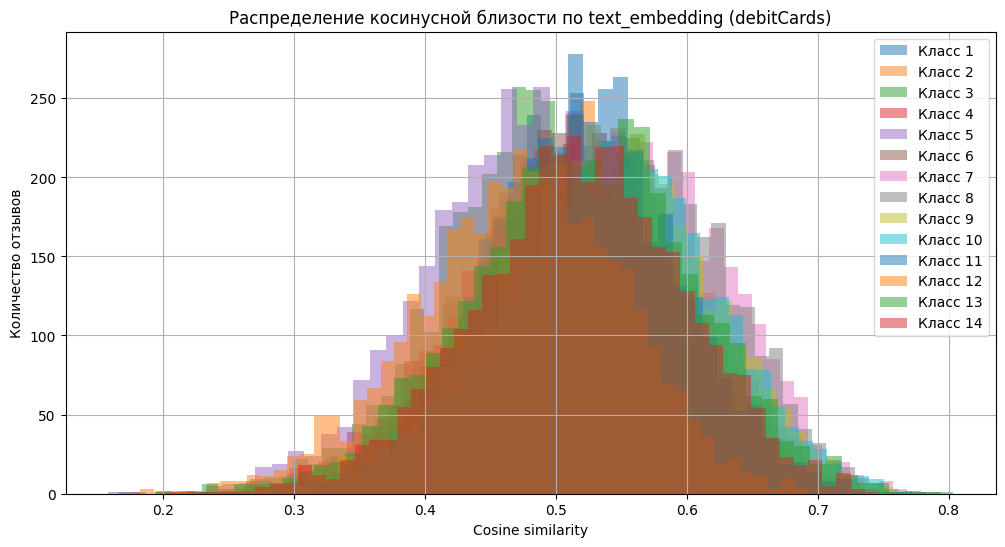

In [443]:
plt.figure(figsize=(12, 6))
for class_id, sims in text_sims.items():
    plt.hist(sims, bins=50, alpha=0.5, label=f"Класс {class_id}")
plt.title("Распределение косинусной близости по text_embedding (debitCards)")
plt.xlabel("Cosine similarity")
plt.ylabel("Количество отзывов")
plt.legend()
plt.grid(True)
plt.show()

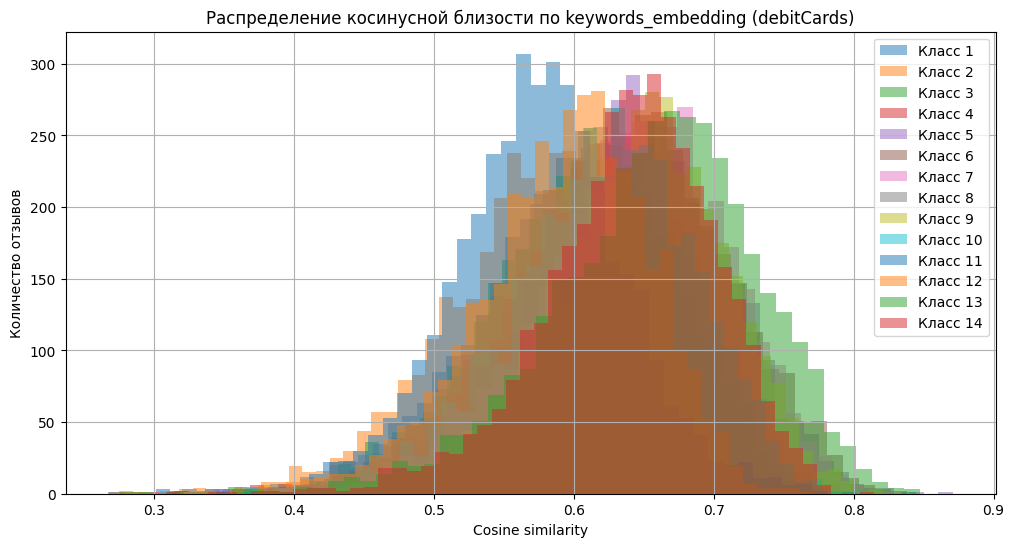

In [444]:
plt.figure(figsize=(12, 6))
for class_id, sims in keywords_sims.items():
    plt.hist(sims, bins=50, alpha=0.5, label=f"Класс {class_id}")
plt.title("Распределение косинусной близости по keywords_embedding (debitCards)")
plt.xlabel("Cosine similarity")
plt.ylabel("Количество отзывов")
plt.legend()
plt.grid(True)
plt.show()

In [478]:
tqdm.pandas()

def get_relevant_classes(sim_dict, text_thr=0.65, kw_thr=0.8):
    """Возвращает список классов, где обе близости выше порогов"""
    if not isinstance(sim_dict, dict):
        return []
    return [
        class_id
        for class_id, (sim_text, sim_keywords) in sim_dict.items()
        if sim_text > text_thr or sim_keywords > kw_thr
    ]

In [479]:
embeddings_df["new_classes"] = embeddings_df["classes_sim_prob"].progress_apply(get_relevant_classes)

  0%|          | 0/50357 [00:00<?, ?it/s]

100%|██████████| 50357/50357 [00:00<00:00, 751959.24it/s]


In [480]:
embeddings_df['new_classes'].value_counts()

new_classes
[]                         43515
[10]                         753
[2, 10]                      605
[2]                          409
[11]                         268
                           ...  
[2, 4, 6, 10, 11, 13]          1
[1, 7, 9, 10]                  1
[2, 7, 8, 9]                   1
[1, 2, 3, 4, 8, 10, 13]        1
[4, 7, 8, 9, 13]               1
Name: count, Length: 655, dtype: int64

In [488]:
df

,index,id,title,text,dateCreate,product,sub_product,source,review,text_clean,review_clean
0,0,992651,не выполняют условия акции,в апреле 2025 года я рекомендовала дебетовую к...,2025-08-29T23:30:38.746003Z,debitCards,Умная карта (Премиум),sravni,не выполняют условия акции в апреле года я ре...,в апреле года я рекомендовала дебетовую карту ...,не выполняют условия акции в апреле года я ре...
1,1,998360,жалоба на услугу газпром бонус премиум,купил услугу газпром бонус премиум за 2 цель б...,2025-09-15T09:38:13.34818Z,debitCards,Отсутствует,sravni,жалоба на услугу газпром бонус премиум купил ...,купил услугу газпром бонус премиум за цель был...,жалоба на услугу газпром бонус премиум купил ...
2,2,993744,банк не отвечает за слова своих сотрудников не...,хочу поделиться историей которая убила моё дов...,2025-09-02T23:21:16.507166Z,debitCards,Умная карта,sravni,банк не отвечает за слова своих сотрудников не...,хочу поделиться историей которая моё к газпром...,банк не отвечает за слова своих сотрудников не...
3,3,999494,не выполняют условия акции,в июне 2025 года я порекомендовал премиальную ...,2025-09-18T08:10:19.954986Z,debitCards,Отсутствует,sravni,не выполняют условия акции в июне года я поре...,в июне года я порекомендовал премиальную дебет...,не выполняют условия акции в июне года я поре...
4,4,992291,странный банк,добрый день в связи с устройством на новую раб...,2025-08-28T19:29:51.696341Z,debitCards,Отсутствует,sravni,странный банк день в связи с устройством на но...,день в связи с устройством на новую работу мне...,странный банк день в связи с устройством на но...
...,...,...,...,...,...,...,...,...,...,...,...
50352,50352,10885124,под видом кредита 12 9 пытаются впарить кредит...,газпромбанк тут заманивал кредитом одобренным ...,2023-04-15 23:33:45,individual,Отсутствует,banki,под видом кредита 12 9 пытаются впарить кредит...,газпромбанк тут заманивал кредитом под пришел ...,под видом кредита 12 9 пытаются впарить кредит...
50353,50353,10872392,неполное изменение номера в офисе отделении,ситуация довольно странная для входа в интерне...,2023-03-30 12:39:01,individual,Отсутствует,banki,неполное изменение номера в офисе отделении си...,ситуация довольно странная для входа в интерне...,неполное изменение номера в офисе отделении си...
50354,50354,10852603,один из отличных банков,в банке нравится все и обслуживание на отлично...,2023-03-10 15:04:12,individual,Отсутствует,banki,один из отличных банков в банке все и обслужив...,в банке все и обслуживание на отлично и дистан...,один из отличных банков в банке все и обслужив...
50355,50355,10852597,обращение в контакт центр 10 баллов,обращение в контакт центр 10 баллов а вот рабо...,2023-03-10 14:57:02,individual,Отсутствует,banki,обращение в контакт центр 10 баллов обращение ...,обращение в контакт центр баллов а вот работа ...,обращение в контакт центр 10 баллов обращение ...


In [462]:
df[df['index'].isin(embeddings_df[embeddings_df['new_classes'].isin([[1]])]['index'])]['text'].values[13]

'заказала новую карту по реферальной ссылке если перейти должен прийти сертификат на ozon на сумму лей все условия выполнила прошло 2 месяца ничего не пришло обратилась в поддержку не помогли и кэшбек пришел меньше заявленного'

In [ ]:
embeddings_df[embeddings_df['new_classes'].isin([[13]])]['index']

,index,product,title_emb,text_emb,text_clean_emb,review_emb,classes_sim_prob,new_classes
773,773,debitCards,"[0.025204005, -0.013221323, -0.03955472, 0.025...","[0.010517244, 0.0012999376, -0.010962831, -0.0...","[0.0074601, -0.003236083, -0.013890713, -0.020...","[0.018861068, -0.000106536965, -0.015552969, -...","{1: (0.635728949843801, 0.7348258945748269), 2...",[13]
877,877,debitCards,"[0.02814864, -0.029243296, 0.0026871525, 0.018...","[0.03406641, -0.0025713497, -0.042456698, -0.0...","[0.02906672, -0.003259564, -0.035552625, -0.06...","[0.034679275, -0.0049447683, -0.020209797, -0....","{1: (0.5248031886250978, 0.6484042975726366), ...",[13]
894,894,debitCards,"[0.03367459, -0.013285059, -0.02218065, 0.0297...","[0.019612016, -0.00058669026, -0.01016936, -0....","[0.008669279, 0.001967752, -0.02482149, -0.021...","[0.024472214, 4.708688e-05, -0.013507258, -0.0...","{1: (0.5699146766423493, 0.6893700596313341), ...",[13]
899,899,debitCards,"[0.027505368, -0.030365668, -0.038002137, 0.02...","[0.020737262, 0.00069815357, -0.007597497, -0....","[0.02073727, 0.0006981599, -0.007597513, -0.01...","[0.03049874, -0.00747611, -0.017927112, 0.0018...","{1: (0.6149925350634122, 0.6688884295523394), ...",[13]
917,917,debitCards,"[0.044795807, -0.028458498, -0.042532485, 0.01...","[0.0389671, -0.00027084965, -0.022236226, -0.0...","[0.030013926, -0.0041065435, -0.05432352, -0.0...","[0.048461802, -0.0023508428, -0.02379006, -0.0...","{1: (0.5676637242364522, 0.6820544322884974), ...",[13]
...,...,...,...,...,...,...,...,...
48604,48604,savings,"[0.032256387, -0.01083197, -0.056669794, -0.00...","[0.019605776, 0.0028326118, -0.032005746, -0.0...","[0.028672637, -0.0007453975, -0.03675196, -0.0...","[0.0408643, -0.007914632, -0.036747716, -0.038...","{1: (0.6047389042774124, 0.6966973048130087), ...",[13]
49240,49240,savings,"[0.051193833, -0.014976223, -0.022324292, 0.05...","[0.0032490334, 0.006437714, -0.0026446725, -0....","[0.0063339523, 0.0074802, -0.0016494791, -0.01...","[0.016276982, 0.0039984277, -0.0032203766, -0....","{1: (0.5739272885980489, 0.7122051211511248), ...",[13]
49388,49388,savings,"[0.04379909, -0.005706982, -0.049624477, -0.00...","[0.010434795, 0.013562626, -0.036102645, -0.04...","[-0.0044640917, 0.006727823, -0.033742778, -0....","[0.022672065, 0.019091055, -0.039760407, -0.04...","{1: (0.6006815089763633, 0.6705107640336985), ...",[13]
49682,49682,savings,"[0.045720328, -0.013767953, 0.009772176, 0.039...","[0.031345513, 0.0018508977, -0.010754264, -0.0...","[0.026710304, 0.003494498, -0.012438589, -0.01...","[0.042616922, 0.0005087086, -0.012612857, -0.0...","{1: (0.6153990638670461, 0.6597785748431169), ...",[13]


## BM25

In [52]:
from rank_bm25 import BM25Okapi
import pymorphy3

In [53]:
morph = pymorphy3.MorphAnalyzer()

def preprocess(text):
    # Нижний регистр, удаление спецсимволов
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    # Токенизация и нормализация
    tokens = [morph.parse(word)[0].normal_form for word in text.split()]
    return tokens

In [103]:
class_texts = []
class_ids = []

for class_id, class_info in final_classes.items():
    text = " ".join([class_info["name"], " ".join(class_info["keywords"])])  # class_info["topic"],
    tokens = preprocess(text)
    class_texts.append(tokens)
    class_ids.append(class_id)


In [104]:
bm25 = BM25Okapi(class_texts)

In [105]:
from itertools import tee, islice

def bigrams(tokens):
    a, b = tee(tokens)
    next(b, None)
    return [f"{w1}_{w2}" for w1, w2 in zip(a, b)]

def preprocess_with_bigrams(text):
    tokens = preprocess(text)
    return tokens + bigrams(tokens)


In [ ]:
# threshold_score = 1.5

# # Функция для применения к каждой строке
# def get_bm25_classes(review_text):
#     tokens = preprocess_with_bigrams(review_text)
#     scores = bm25.get_scores(tokens)
#     selected_classes = [class_ids[i] for i, score in enumerate(scores) if score > threshold_score]
#     return selected_classes

In [ ]:
# df['predicted_classes'] = df['review'].progress_apply(get_bm25_classes)

100%|██████████| 50357/50357 [08:39<00:00, 97.00it/s] 


In [ ]:
class_ids = list(final_classes.keys())

# Создаем пустой DataFrame для скор по всем классам
scores_df = pd.DataFrame(0, index=df.index, columns=class_ids)

# Функция для получения скор по всем классам
def get_bm25_scores_vector(review_text):
    tokens = preprocess_with_bigrams(review_text)
    scores = bm25.get_scores(tokens)  # список скор для всех классов
    return scores

# Пробегаемся с прогрессбаром
scores_list = df['review'].progress_apply(get_bm25_scores_vector)

# Записываем в DataFrame
for i, score_vector in enumerate(scores_list):
    scores_df.iloc[i] = score_vector

100%|██████████| 50357/50357 [08:14<00:00, 101.80it/s]


In [107]:
scores_df

,1,2,3,4,5,6,7,8,9,11,12,13,14,15,16
0,17.763792,14.470030,16.518857,11.139615,13.803198,5.221800,14.187131,8.389547,12.427361,11.371496,5.802615,8.005117,13.714215,24.337036,37.712037
1,7.969105,5.246999,0.544067,5.168132,2.132602,0.435150,6.060819,3.941363,11.134461,8.678503,0.483551,3.517489,4.118017,0.417251,22.130266
2,14.879401,25.219927,12.992000,11.710932,27.174881,11.959026,14.082115,12.074680,11.914582,12.052774,4.539696,6.700746,10.447041,21.250121,38.745828
3,23.751481,25.193909,17.738142,7.424412,28.035060,3.481200,18.204439,6.015398,9.132028,23.044997,3.868410,5.001404,19.987515,16.564615,36.313658
4,2.256971,15.899165,9.722825,8.734205,9.873886,3.860057,6.859034,9.562001,13.944112,16.838918,2.605492,5.015757,8.711654,20.244820,26.554999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50352,0.000000,0.000000,0.000000,0.840497,2.393441,11.401257,4.971132,1.276203,0.889269,0.000000,0.974051,13.856117,9.700672,0.000000,3.229977
50353,1.692728,4.150553,4.826221,2.260342,3.191319,1.305450,3.424907,1.938999,1.964602,4.422854,1.450654,1.498268,6.558759,9.473612,17.170180
50354,3.171342,7.949583,4.352537,3.732232,8.194896,2.059534,2.939055,6.247069,4.724207,7.809557,1.638389,0.998845,5.504667,12.430465,10.797457
50355,8.244660,0.000000,0.544067,0.417251,2.393441,0.000000,1.575473,0.633549,9.241026,0.534511,0.000000,0.000000,0.765893,10.446181,18.137452


In [58]:
scores_df

,1,2,3,4,5,6,7,8,9,11,12,13,14,15,16
0,18.103983,37.442975,18.397297,14.194688,11.738455,7.607601,13.688833,13.341698,22.407716,17.404208,8.890646,17.496325,20.285848,32.933899,34.559238
1,8.093403,17.020335,0.736964,6.217909,2.359241,0.633967,4.261243,4.362680,13.525089,13.421197,2.060915,6.237998,4.559810,1.812672,18.267140
2,16.587368,41.890522,14.081084,14.790208,25.926883,13.698089,10.159286,18.316684,22.837492,18.532675,8.180805,17.081456,14.959605,32.089511,34.973767
3,24.261567,47.643534,17.905923,12.905718,23.251442,5.071734,14.973000,11.475449,16.825288,32.834109,5.771800,9.539777,28.615362,23.178643,34.294149
4,2.283201,29.792062,10.498596,9.478399,12.011545,4.692456,6.461377,12.623163,24.162538,20.981965,5.723333,15.834867,11.718171,21.259399,22.530529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50352,0.000000,1.891065,0.000000,1.552980,0.953830,8.682383,6.379649,2.083073,1.319437,0.522367,1.120442,15.125781,7.846231,0.973149,2.195947
50353,1.712401,15.741498,5.424996,4.094820,3.619479,1.901900,3.085920,2.629296,2.914992,5.433132,11.175640,8.337133,9.367280,12.674784,15.415001
50354,3.937519,13.583931,4.726405,4.168905,9.789975,3.021357,3.067789,7.293341,7.339491,7.953023,1.710616,7.535954,6.428193,12.333477,9.721881
50355,8.440785,11.346389,0.542079,0.412391,0.953830,0.000000,0.608500,1.349784,11.681568,4.856645,3.865689,0.465892,0.821404,9.518741,15.829896


In [584]:
scores_df

,1,2,3,4,5,6,7,8,9,11,12,13,14
0,16.469881,41.000423,16.489556,12.587923,10.751038,6.754207,13.008541,12.147333,20.336716,15.371926,7.898756,15.920480,18.263549
1,7.476622,19.044166,0.657140,5.566416,2.026874,0.562851,3.178838,3.312408,11.566067,11.575683,1.825543,5.668228,3.479386
2,14.798634,44.788173,12.386102,13.062412,24.894805,12.408936,9.516498,16.621163,20.856111,16.703845,7.490198,16.543432,13.423648
3,22.226807,48.896641,15.930593,11.591981,21.350694,4.502805,15.741127,10.938622,15.639662,28.908021,5.128507,9.231903,26.073642
4,2.029380,31.519289,9.420246,8.354878,10.930344,4.227935,5.897648,11.278199,21.690245,19.274137,5.543934,15.567723,10.440240
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50352,0.000000,2.340522,0.000000,1.327899,1.088739,6.802208,5.153938,1.765054,1.317363,0.463202,0.844720,10.496705,6.247860
50353,1.522035,17.879421,4.913959,3.597299,3.137677,1.688552,2.689525,2.335920,2.594153,4.761990,10.199260,7.645792,8.539367
50354,3.522753,14.589384,4.201140,3.695358,9.020631,2.617653,2.824134,6.485419,6.561312,7.175591,1.611855,8.036529,5.734062
50355,7.786306,14.043131,0.481143,0.363738,1.088739,0.000000,0.689414,1.349438,10.806503,5.579779,4.550915,0.421309,0.733040


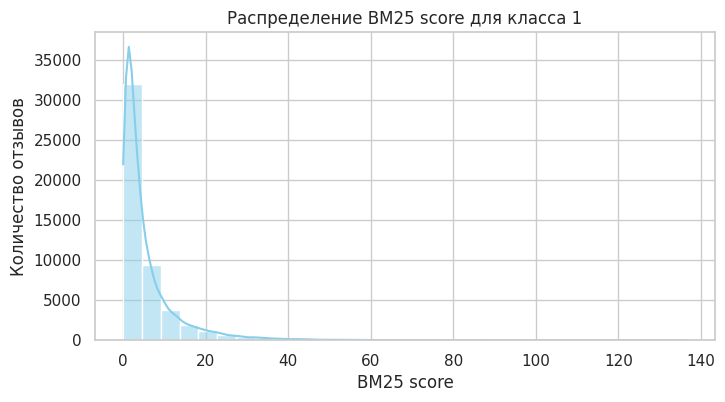

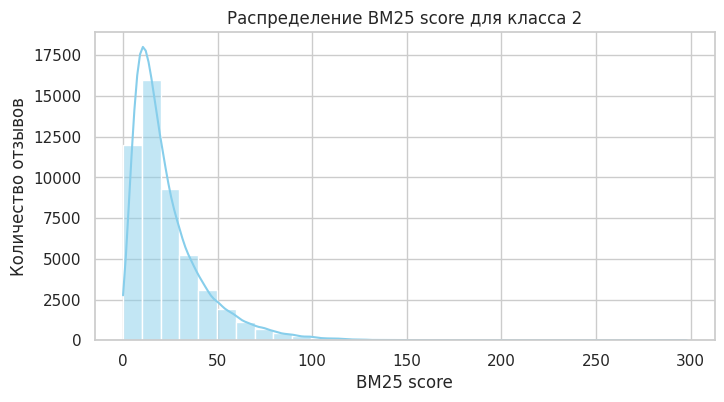

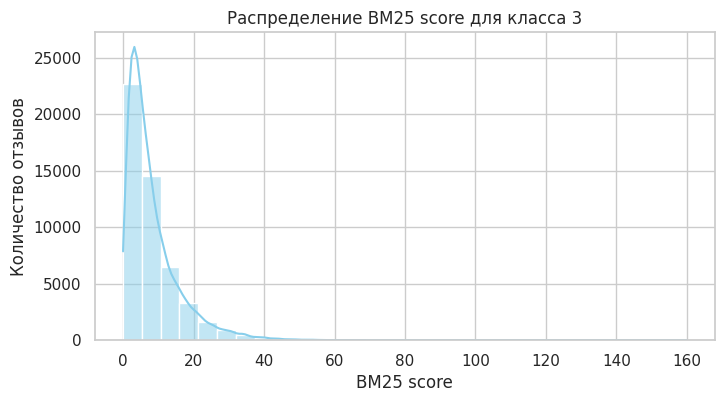

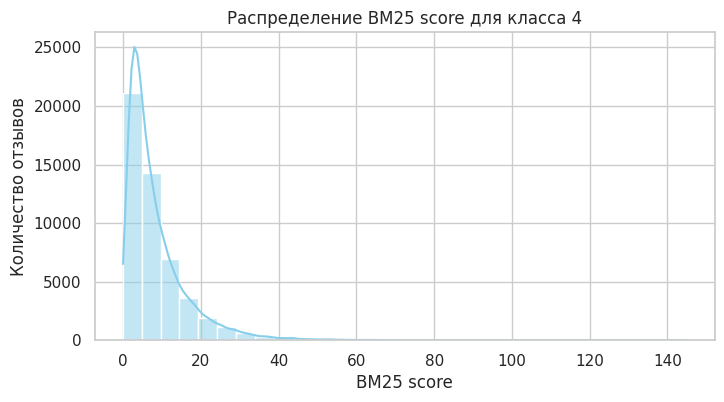

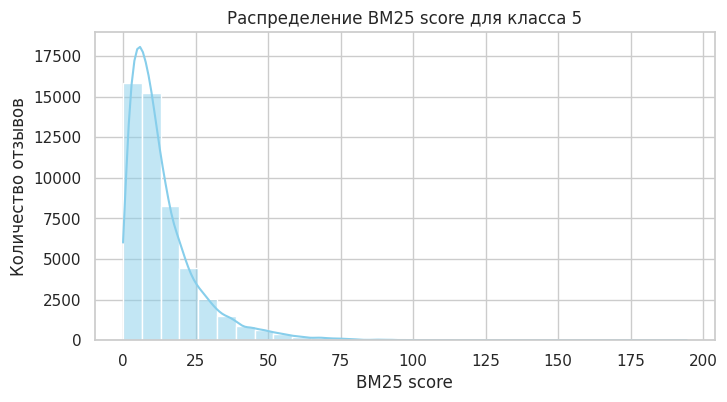

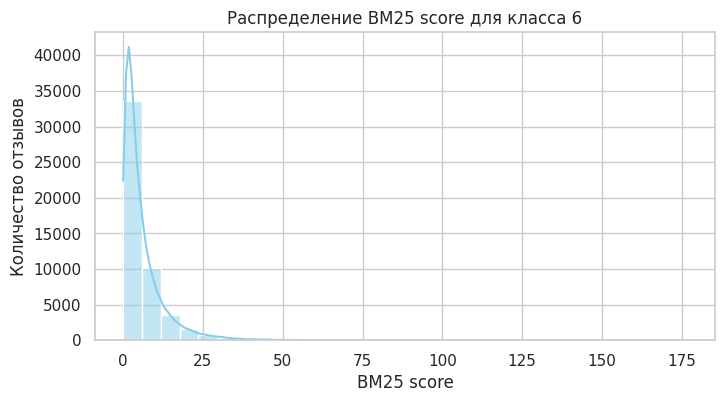

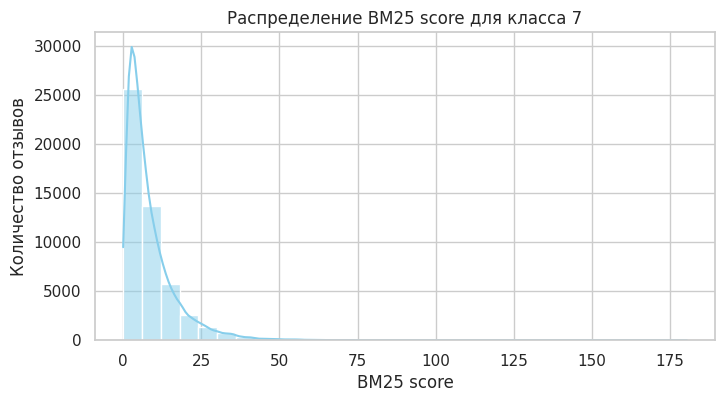

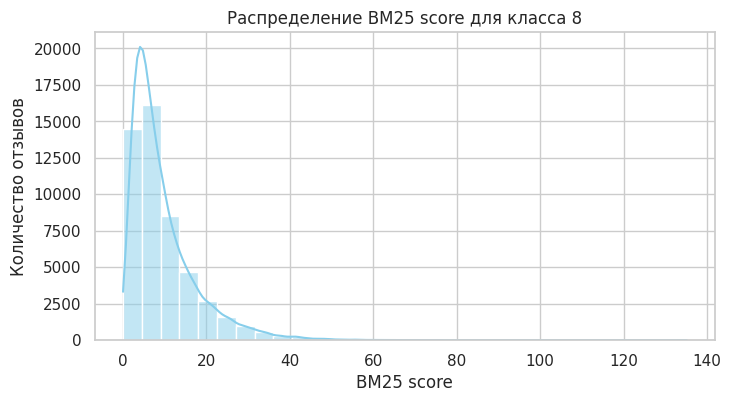

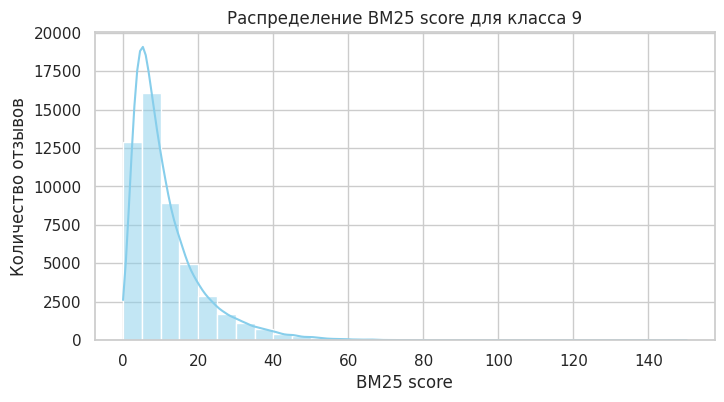

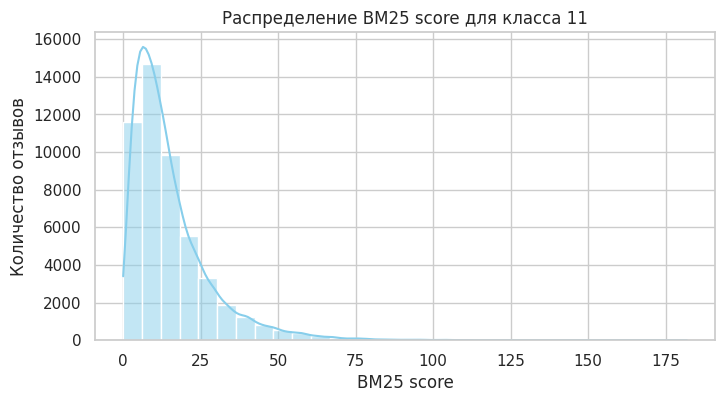

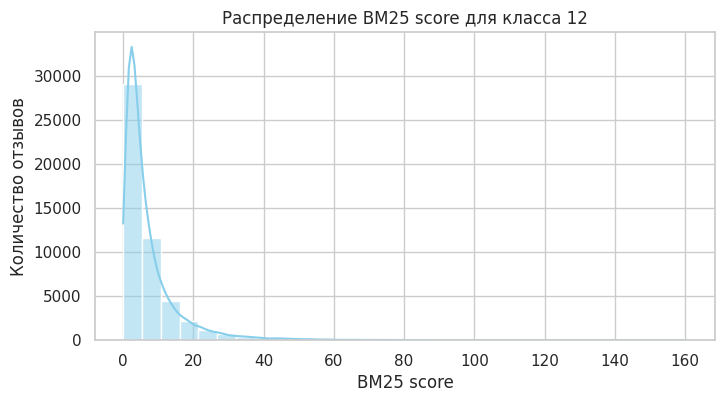

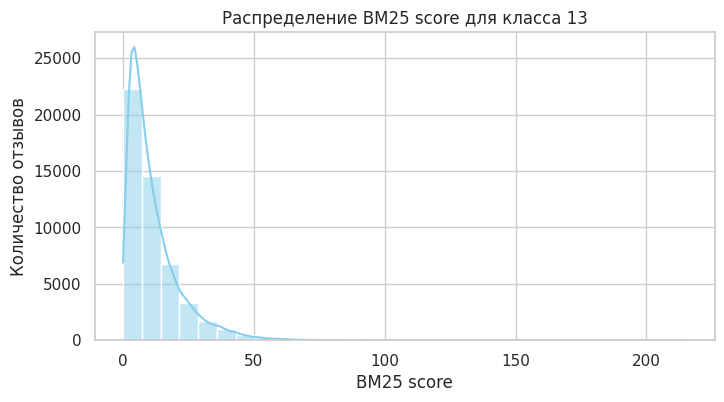

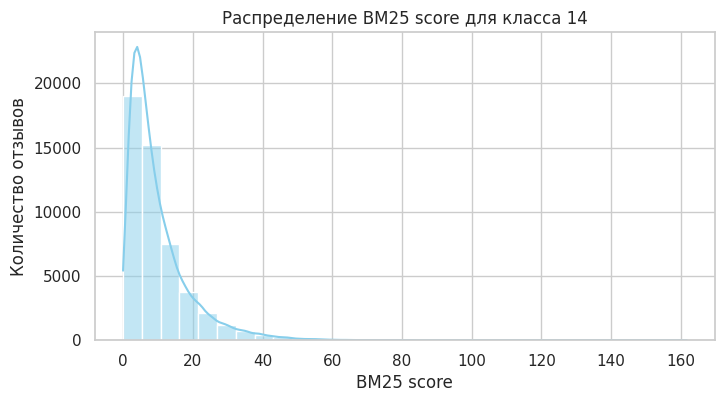

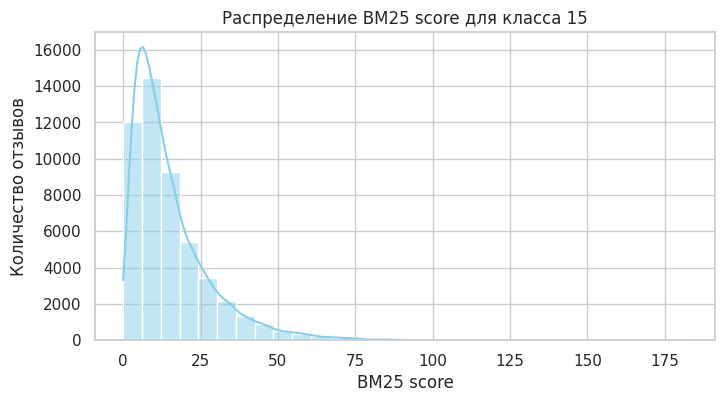

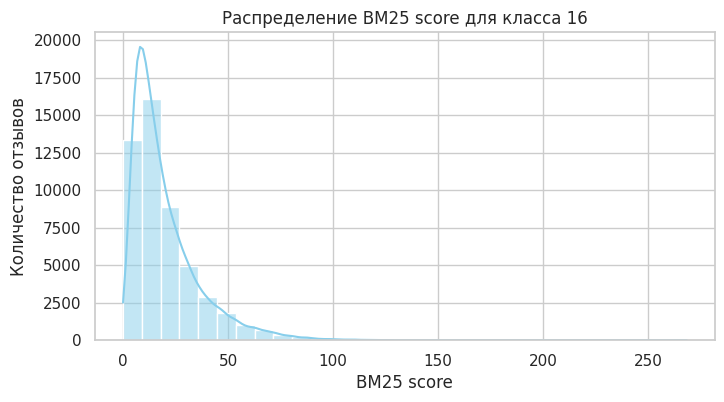

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Установим стиль графиков
sns.set(style="whitegrid")

# Пробегаемся по всем классам
for class_id in scores_df.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(scores_df[class_id], bins=30, kde=True, color='skyblue')
    plt.title(f"Распределение BM25 score для класса {class_id}")
    plt.xlabel("BM25 score")
    plt.ylabel("Количество отзывов")
    plt.show()

In [117]:
base_quantile = 0.85

# Задаём индивидуальные отклонения для отдельных классов
custom_quantiles = {
    5: 0.85  # для класса 5 — порог 0.9
}

# Считаем пороги с учётом индивидуальных настроек
thresholds = {}
for class_id in scores_df.columns:
    q = custom_quantiles.get(int(class_id), base_quantile)
    thresholds[class_id] = scores_df[class_id].quantile(q)
thresholds = pd.Series(thresholds)

# Функция для определения классов у одного отзыва
def get_classes_per_review(row):
    selected_classes = [class_id for class_id, score in row.items() if score >= thresholds[class_id]]
    return selected_classes

# Применяем с прогресс-баром
tqdm.pandas()
df['predicted_classes_new'] = scores_df.progress_apply(get_classes_per_review, axis=1)

  0%|          | 0/50357 [00:00<?, ?it/s]

100%|██████████| 50357/50357 [00:00<00:00, 51236.82it/s]


In [ ]:
# thresholds = scores_df.quantile(0.8)

# # Функция для определения классов для одного отзыва
# def get_classes_per_review(row):
#     selected_classes = [class_id for class_id, score in row.items() if score >= thresholds[class_id]]
#     return selected_classes

# # Применяем с прогресс-баром
# tqdm.pandas()
# df['predicted_classes_new'] = scores_df.progress_apply(get_classes_per_review, axis=1)



100%|██████████| 50357/50357 [00:00<00:00, 60599.79it/s]


In [61]:
df.head(3)

,index,id,title,text,dateCreate,product,sub_product,source,text_clean,review,predicted_classes_new
0,0,992651,не выполняют условия акции,в апреле 2025 года я рекомендовала дебетовую к...,2025-08-29T23:30:38.746003Z,debitCards,Умная карта (Премиум),sravni,в апреле года я рекомендовала дебетовую карту ...,не выполняют условия акции в апреле года я ре...,"[1, 2, 3, 4, 6, 7, 8, 9, 12, 13, 14, 15, 16]"
1,1,998360,жалоба на услугу газпром бонус премиум,купил услугу газпром бонус премиум за 2 цель б...,2025-09-15T09:38:13.34818Z,debitCards,Отсутствует,sravni,купил услугу газпром бонус премиум за цель был...,жалоба на услугу газпром бонус премиум купил ...,"[1, 9]"
2,2,993744,банк не отвечает за слова своих сотрудников не...,хочу поделиться историей которая убила моё дов...,2025-09-02T23:21:16.507166Z,debitCards,Умная карта,sravni,хочу поделиться историей которая моё к газпром...,банк не отвечает за слова своих сотрудников не...,"[1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16]"


In [118]:
percentiles = {}
for col in tqdm(scores_df.columns, desc="Вычисляем перцентили по классам"):
    percentiles[col] = np.percentile(scores_df[col], np.arange(0, 101))

Вычисляем перцентили по классам:   0%|          | 0/15 [00:00<?, ?it/s]

Вычисляем перцентили по классам: 100%|██████████| 15/15 [00:00<00:00, 526.49it/s]


In [ ]:
# def get_percentile_rank(value, class_name):
#     arr = percentiles[class_name]
#     return np.searchsorted(arr, value, side='right')  # вернёт значение от 0 до 100

# def select_top_by_percentile(row, all_scores):
#     classes = row['predicted_classes_new']
#     if len(classes) <= 4:
#         return classes

#     # Получаем BM25 скоры для текущего отзыва
#     class_scores = all_scores.loc[row.name, classes]

#     # Вычисляем перцентильные ранги
#     ranks = {cls: get_percentile_rank(class_scores[cls], cls) for cls in classes}

#     # Берем 3 класса с самыми высокими перцентилями
#     top_classes = sorted(ranks, key=ranks.get, reverse=True)[:3]

#     return top_classes

# # 4️⃣ Применяем
# df['predicted_classes_refined'] = df.progress_apply(select_top_by_percentile, axis=1, all_scores=scores_df)

100%|██████████| 50357/50357 [00:02<00:00, 21160.20it/s]


In [119]:
important_classes = [2, 5, 11]

def select_top_by_percentile_v2(row, all_scores):
    classes = row['predicted_classes_new']
    if len(classes) <= 4:
        return classes

    # Получаем BM25 скоры для текущего отзыва
    class_scores = all_scores.loc[row.name, classes]

    # Вычисляем перцентильные ранги
    ranks = {cls: get_percentile_rank(class_scores[cls], cls) for cls in classes}

    # Проверяем важные классы
    imp_in_classes = [cls for cls in classes if cls in important_classes]
    if len(imp_in_classes) > 2:
        # Оставляем только 2 с наибольшим значением score
        imp_scores = {cls: class_scores[cls] for cls in imp_in_classes}
        top_imp = sorted(imp_scores, key=imp_scores.get, reverse=True)[:2]
        # Остальные классы убираем из consideration
        for cls in imp_in_classes:
            if cls not in top_imp:
                del ranks[cls]

    # Берем 3 класса с самыми высокими перцентилями
    top_classes = sorted(ranks, key=ranks.get, reverse=True)[:3]

    return top_classes

# Применяем с прогресс-баром
df['predicted_classes_refined'] = df.progress_apply(select_top_by_percentile_v2, axis=1, all_scores=scores_df)

  0%|          | 0/50357 [00:00<?, ?it/s]

100%|██████████| 50357/50357 [00:01<00:00, 36534.75it/s]


In [ ]:
# percentile_75 = scores_df.quantile(0.8)

# # 2️⃣ Функция для отбора 3 лучших классов по перцентильной “уверенности”
# def select_top_classes(row, all_scores):
#     classes = row['predicted_classes_new']
#     if len(classes) <= 4:
#         return classes  # если ≤4 — не трогаем

#     # Берем BM25 скоры для текущих классов
#     class_scores = all_scores.loc[row.name, classes]

#     # Вычисляем, насколько score превышает 75-й перцентиль
#     diff = class_scores - percentile_75[classes]

#     # Берем 3 класса с наибольшим превышением
#     top_classes = diff.nlargest(3).index.tolist()
#     return top_classes

In [ ]:
# df['predicted_classes_refined'] = df.progress_apply(lambda r: select_top_classes(r, scores_df), axis=1)

100%|██████████| 50357/50357 [00:04<00:00, 10196.52it/s]


In [120]:
df['predicted_classes_refined'] = df['predicted_classes_refined'].progress_apply(
    lambda x: sorted(x) if isinstance(x, list) else x
)

  0%|          | 0/50357 [00:00<?, ?it/s]

100%|██████████| 50357/50357 [00:00<00:00, 1769319.93it/s]


In [121]:
df['predicted_classes_refined'].value_counts().head(30)

predicted_classes_refined
[]             25464
[1]             1982
[12]            1421
[6, 13, 14]      822
[11]             680
[15]             612
[8]              498
[6]              444
[3]              362
[4]              351
[2]              338
[5]              280
[6, 13]          264
[1, 8]           236
[2, 5, 11]       226
[9]              211
[2, 11]          206
[6, 12, 13]      192
[14]             185
[2, 3, 5]        181
[1, 5, 7]        171
[3, 4, 9]        166
[6, 7, 13]       156
[7]              144
[13]             140
[6, 7, 12]       137
[5, 7, 11]       134
[2, 3, 4]        133
[4, 6, 13]       124
[2, 4, 9]        122
Name: count, dtype: int64

In [128]:
df[df['predicted_classes_refined'].isin([[6, 13, 14]])]

,index,id,title,text,dateCreate,product,sub_product,source,text_clean,review,predicted_classes_new,predicted_classes_refined
1179,1179,227325,пустой дополнительный офис банка,24 03 2017 как обычно раз в месяц трачу свое д...,2017-03-24T14:50:10.767Z,serviceLevel,Отсутствует,sravni,как обычно раз в месяц трачу свое время на ожи...,пустой дополнительный офис банка как обычно р...,"[6, 13, 14]","[6, 13, 14]"
1232,1232,739424,моя лояльность к банку за полгода упала с само...,являюсь клиентом банка 8 5 лет все это время б...,2024-01-16T05:37:03.713665Z,serviceLevel,Отсутствует,sravni,являюсь клиентом банка лет все это время был з...,моя лояльность к банку за полгода упала с само...,"[1, 2, 4, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16]","[6, 13, 14]"
1275,1275,547228,на словах одно на деле другое,нужен был кредит на 600 т р на 3 года без офор...,2022-07-10T11:48:10.539845Z,serviceLevel,Отсутствует,sravni,нужен был кредит на т р на года без оформления...,на словах одно на деле другое нужен был кредит...,"[6, 7, 8, 13, 14]","[6, 13, 14]"
1358,1358,466123,четкое обслуживание,захотел взять кредит и вместе с этим заодно по...,2021-12-08T13:52:26.327869Z,serviceLevel,Отсутствует,sravni,захотел взять кредит и вместе с этим заодно по...,четкое обслуживание захотел взять кредит и вме...,"[6, 13, 14]","[6, 13, 14]"
1873,1873,57948,являюсь держателем зарплатной карты газпромбан...,тк наличие маленького ребёнка не позволяет раз...,2013-03-08T15:21:30.51Z,creditCards,Отсутствует,sravni,тк наличие маленького ребёнка не позволяет раз...,являюсь держателем зарплатной карты газпромбан...,"[6, 13, 14]","[6, 13, 14]"
...,...,...,...,...,...,...,...,...,...,...,...,...
48395,48395,12372407,опыт общения с газпромбанком,здравствуйте дважды обращался за кредитом в ра...,2025-06-21 15:43:40,savings,Отсутствует,banki,здравствуйте дважды обращался за кредитом в ра...,опыт общения с газпромбанком здравствуйте дваж...,"[4, 6, 7, 9, 13, 14, 15, 16]","[6, 13, 14]"
50266,50266,11229500,блокировка всех счетов по 115 фз,недавно получил кредит в данном банке выдали с...,2023-11-25 23:41:27,individual,Отсутствует,banki,недавно получил кредит в данном банке выдали с...,блокировка всех счетов по 115 фз недавно получ...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 14]","[6, 13, 14]"
50273,50273,11215024,навязывание очень дорогих и ненужных услуг ооо...,15 08 2023г в процессе оформления потребительс...,2023-11-19 22:43:08,individual,Отсутствует,banki,в процессе оформления кредита по договору пб о...,навязывание очень дорогих и ненужных услуг ооо...,"[3, 4, 6, 7, 8, 9, 12, 13, 14, 16]","[6, 13, 14]"
50274,50274,11214888,скрытное навязывание услуги мульт сервис,07 04 2023г оформлял потребительский кредит в ...,2023-11-19 20:53:24,individual,Отсутствует,banki,оформлял кредит в газпромбанк сотрудница банка...,скрытное навязывание услуги мульт сервис офор...,"[6, 8, 13, 14, 15]","[6, 13, 14]"


In [127]:
df[df['predicted_classes_refined'].isin([[6, 13, 14]])]['review'].values[4]

'являюсь держателем зарплатной карты газпромбанк решила взять там потребительский кредит тк наличие маленького ребёнка не позволяет разъезжать по банкам и когда снимают сразу с зарплатной карты подала заявку около дней принимали решение о том давать кредит или нет в итоге только половину суммы я сначала отказалась после чего менеджер смирнова мария сказала что кредит действителен в течение месяцев и я могу обратиться если передумаю мне назначат сделку и переведут деньги я решила брать у них деньги так сложились обстоятельства на что мария мне сказала что оказывается кредит на тот момент не до конца и нужно ждать еще но скорее всего завтра от этого слова меня уже будет всё решено точно и она мне утром позвонит естественно завтра я опять была ответом что решение на рассмотрении звонить мне конечно же никто не стал когда я набрала номер то мария была не со мной говорить начала ёрзать по базе в течении дней менеджер мария много раз обещала мне перезвонить и перезвонила только аз когда я уж

In [76]:
df[df['predicted_classes_refined'].isin([[2, 5, 11]])]['text'].values[15]

'хочу оставить отзыв о газпромбанке не связываетесь с ним никогда заказала я на сайте ржд карту юнион пэй хотела получить 4444 балла ржд бонус все хорошо было быстро оформила курьер привезла карту к метро быстренько там все подписала и потом подсунула мне я спросила ее карта бесплатная на что мне был ответ да полностью бесплатная также на сайте ржд не было информации о каких либо списаниях по ней крупным шрифтом бесплатная карта в итоге с карты у меня списывают лей якобы за выпуск карты во первых вопрос что за цены такие я ни в одном банке не видела чтобы выпуск карты в принципе стоил каких то денег хотя у меня их много и сбербанк и озонбанк и тинькофф и альфа второй самый главный вопрос почему меня о сняли деньги без предупреждения я в шоке обращаюсь в отделение пишу обращение сотрудница уверила меня что деньги вернуться на карту в итоге мне приходит отказ якобы где то там на сайте написано что выпуск карты стоит денег интересно только где сколько бы я ни звонила ни писала ни ходила т

In [82]:
df[df['predicted_classes_refined'].isin([[5, 6, 11]])]['text'].values[0]

'решил стать клиентом газпромбанка чтобы открыть выгодный вклад заказал обычную дебетовую карту через сайт 02 июля 2024 года привез карту и документы курьер и завявил что он привез мне две карты одну дебетовую а вторую кредитную я ему заявил что получать кредитную карту я не хочу мне нужна только дебетовая на что он ответил что без кредитной карты дебетовую мне выдать не может это обязательно чтобы меня успокоить представитель банка заявил что она бесплатная пришлось получать карту нужно было открыть вклад далее я позвонил в контактный центр чтобы закрыть и аннулировать кредитную карту обьяснил ситуацию и мне ответили что это нормально кредитная карта открывается к дебетовой автоматически а затем выяснилось что вместе с кредитной картой были мне оформлены две платные услуги страхования жизни и финансовая защита и самое крутое средства за услуги будут списаны даже если вы не активируете эту кредитную карту по телефону закрыл карту и услуги однако при закрытии платных услуг было написано

In [612]:
df[df['predicted_classes_refined'].isin([[2, 5]])]['text'].iloc[0]

'27 11 2024 обратилась для открытия дебетовой карты в спб в офис банка на коломяжском пр 17 взяла талончик в524 в 16 44 передо мной было человека3 4 сотрудники не спешили периодически очередь возмущалась но ускорения не было примерно минут через 45 меня начал обслуживать сотрудник бруй а н примерно за час полтора мне оформили бесплатную дебетовую карту которая оказалась впоследствии платной к карте привязан счет именно он и платный о чем никто не сообщает как будто бы карту можно открыть без связанного сней счета подошел еще один сотрудник молодой человек и сказал что если я куплю сим карту мобайл то обслуживание дк станет реально беслатным навсегда я перевела сбп лей за эту сим карту мобайл потом неоднократно попросила все платные доп услуги отключить и женщина которая также помогала андрею бруй меня обслуживать уверила меня что они в программе все отключили она же предупредила что если все таки москва эти платные доп услуги подключит то мне придет смс и я успею их сама отключить в лк

## Final DF with Clusters

In [ ]:
# class_tags = {
#     1:  "cashbackPromo",        # Кэшбеки, промоакции и бонусы
#     2:  "cardAccess",           # Блокировка/разблокировка карт, перевыпуск, доступ к счёту
#     3:  "notifications",        # Выписки, уведомления и рассылки
#     4:  "transactionErrors",    # Ошибки и проблемы с транзакциями
#     5:  "creditCardsService",   # Обслуживание кредитных карт
#     6:  "earlyRepayment",       # Досрочное погашение и расторжение кредитов
#     7:  "autoLoans",            # Автокредиты
#     8:  "deposits",             # Вклады: оформление и начисление
#     9:  "depositAccess",        # Блокировка вкладов и доступ
#     11: "salaryCards",          # Зарплатные карты и премиум-обслуживание
#     12: "mortgageIssues",       # Ипотека
#     13: "loanIssues",           # Навязывание кредитов и проблемы с выдачей
#     14: "refinancing",          # Реструктуризация и рефинансирование
# }

In [617]:
df

,index,id,title,text,dateCreate,product,sub_product,source,review,text_clean,review_clean,predicted_classes,predicted_classes_new,num_classes,predicted_classes_refined
0,0,992651,не выполняют условия акции,в апреле 2025 года я рекомендовала дебетовую к...,2025-08-29T23:30:38.746003Z,debitCards,Умная карта (Премиум),sravni,не выполняют условия акции в апреле года я ре...,в апреле года я рекомендовала дебетовую карту ...,не выполняют условия акции в апреле года я ре...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 7, 9, 14]",7,"[1, 3]"
1,1,998360,жалоба на услугу газпром бонус премиум,купил услугу газпром бонус премиум за 2 цель б...,2025-09-15T09:38:13.34818Z,debitCards,Отсутствует,sravni,жалоба на услугу газпром бонус премиум купил ...,купил услугу газпром бонус премиум за цель был...,жалоба на услугу газпром бонус премиум купил ...,"[1, 2, 4, 5, 7, 8, 10, 11, 13]",[],0,[]
2,2,993744,банк не отвечает за слова своих сотрудников не...,хочу поделиться историей которая убила моё дов...,2025-09-02T23:21:16.507166Z,debitCards,Умная карта,sravni,банк не отвечает за слова своих сотрудников не...,хочу поделиться историей которая моё к газпром...,банк не отвечает за слова своих сотрудников не...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 6, 8, 9, 13, 14]",11,"[1, 6]"
3,3,999494,не выполняют условия акции,в июне 2025 года я порекомендовал премиальную ...,2025-09-18T08:10:19.954986Z,debitCards,Отсутствует,sravni,не выполняют условия акции в июне года я поре...,в июне года я порекомендовал премиальную дебет...,не выполняют условия акции в июне года я поре...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 7, 9, 11, 14]",9,"[1, 14]"
4,4,992291,странный банк,добрый день в связи с устройством на новую раб...,2025-08-28T19:29:51.696341Z,debitCards,Отсутствует,sravni,странный банк день в связи с устройством на но...,день в связи с устройством на новую работу мне...,странный банк день в связи с устройством на но...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",[9],1,[9]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50352,50352,10885124,под видом кредита 12 9 пытаются впарить кредит...,газпромбанк тут заманивал кредитом одобренным ...,2023-04-15 23:33:45,individual,Отсутствует,banki,под видом кредита 12 9 пытаются впарить кредит...,газпромбанк тут заманивал кредитом под пришел ...,под видом кредита 12 9 пытаются впарить кредит...,"[2, 6, 7, 13, 14]",[],0,[]
50353,50353,10872392,неполное изменение номера в офисе отделении,ситуация довольно странная для входа в интерне...,2023-03-30 12:39:01,individual,Отсутствует,banki,неполное изменение номера в офисе отделении си...,ситуация довольно странная для входа в интерне...,неполное изменение номера в офисе отделении си...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",[12],1,[12]
50354,50354,10852603,один из отличных банков,в банке нравится все и обслуживание на отлично...,2023-03-10 15:04:12,individual,Отсутствует,banki,один из отличных банков в банке все и обслужив...,в банке все и обслуживание на отлично и дистан...,один из отличных банков в банке все и обслужив...,"[1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14]",[],0,[]
50355,50355,10852597,обращение в контакт центр 10 баллов,обращение в контакт центр 10 баллов а вот рабо...,2023-03-10 14:57:02,individual,Отсутствует,banki,обращение в контакт центр 10 баллов обращение ...,обращение в контакт центр баллов а вот работа ...,обращение в контакт центр 10 баллов обращение ...,"[1, 2, 10, 11, 12]",[1],1,[1]


In [129]:
class_tags = {
    1:  "cashbackPromo",
    2:  "cardAccess",
    3:  "notifications",
    4:  "transactionErrors",
    5:  "creditCardsService",
    6:  "earlyRepayment",
    7:  "autoLoans",      # будем потом заменять на autocredits
    8:  "deposits",
    9:  "depositAccess",
    11: "Salary&PremiumCards",
    12: "mortgageIssues",
    13: "loanIssues",
    14: "refinancing",
    15: 'onlineService',
    16: 'currencyChange'
}


# 🔹 Функция с учётом доработок
def make_final_tags(row):
    tags = [row["product"]]  # первым идёт product
    classes = row.get("predicted_classes_refined", [])

    # Добавляем теги, соответствующие классам
    if isinstance(classes, list):
        mapped_tags = [class_tags[c] for c in classes if c in class_tags]
        tags.extend(mapped_tags)

    # --- ✅ 1. Замена autoLoans → autocredits (без дубликатов)
    if "autoLoans" in tags:
        tags = [t if t != "autoLoans" else "autocredits" for t in tags]
        
    if "moneyOrder" in tags:
        tags = [t if t != "moneyOrder" else "transactionErrors" for t in tags]


    tags = [t if (t != "mobile_app" and t != 'onlineService')  else "remoteService" for t in tags]
    tags = [t if t != "individual" else "other" for t in tags]
    tags = [t if t != "currencyChange" else "currencyExchange" for t in tags]

    # Убираем дубликаты, сохраняя порядок
    tags = list(dict.fromkeys(tags))

    # --- ✅ 2. Проверяем sub_product на "Умная карта"/"Премиум"
    sub = str(row.get("sub_product", "")).lower()
    if any(x in sub for x in ["умная карта (премиум)", "умная карта", "умная", "премиум up", "премиум"]):
        if "Salary&PremiumCards" not in tags:
            tags.append("Salary&PremiumCards")

    return tags


# 🔹 Применяем с прогрессом
from tqdm import tqdm
tqdm.pandas()

df["final_classes"] = df.progress_apply(make_final_tags, axis=1)

  0%|          | 0/50357 [00:00<?, ?it/s]

100%|██████████| 50357/50357 [00:00<00:00, 136958.30it/s]


In [130]:
df

,index,id,title,text,dateCreate,product,sub_product,source,text_clean,review,predicted_classes_new,predicted_classes_refined,final_classes
0,0,992651,не выполняют условия акции,в апреле 2025 года я рекомендовала дебетовую к...,2025-08-29T23:30:38.746003Z,debitCards,Умная карта (Премиум),sravni,в апреле года я рекомендовала дебетовую карту ...,не выполняют условия акции в апреле года я ре...,"[1, 3, 14, 15]","[1, 3, 14, 15]","[debitCards, cashbackPromo, notifications, ref..."
1,1,998360,жалоба на услугу газпром бонус премиум,купил услугу газпром бонус премиум за 2 цель б...,2025-09-15T09:38:13.34818Z,debitCards,Отсутствует,sravni,купил услугу газпром бонус премиум за цель был...,жалоба на услугу газпром бонус премиум купил ...,[],[],[debitCards]
2,2,993744,банк не отвечает за слова своих сотрудников не...,хочу поделиться историей которая убила моё дов...,2025-09-02T23:21:16.507166Z,debitCards,Умная карта,sravni,хочу поделиться историей которая моё к газпром...,банк не отвечает за слова своих сотрудников не...,"[1, 2, 5, 6, 8, 15]","[1, 6, 15]","[debitCards, cashbackPromo, earlyRepayment, re..."
3,3,999494,не выполняют условия акции,в июне 2025 года я порекомендовал премиальную ...,2025-09-18T08:10:19.954986Z,debitCards,Отсутствует,sravni,в июне года я порекомендовал премиальную дебет...,не выполняют условия акции в июне года я поре...,"[1, 2, 3, 5, 7, 11, 14]","[1, 3, 14]","[debitCards, cashbackPromo, notifications, ref..."
4,4,992291,странный банк,добрый день в связи с устройством на новую раб...,2025-08-28T19:29:51.696341Z,debitCards,Отсутствует,sravni,день в связи с устройством на новую работу мне...,странный банк день в связи с устройством на но...,"[9, 15]","[9, 15]","[debitCards, depositAccess, remoteService]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50352,50352,10885124,под видом кредита 12 9 пытаются впарить кредит...,газпромбанк тут заманивал кредитом одобренным ...,2023-04-15 23:33:45,individual,Отсутствует,banki,газпромбанк тут заманивал кредитом под пришел ...,под видом кредита 12 9 пытаются впарить кредит...,"[6, 13]","[6, 13]","[other, earlyRepayment, loanIssues]"
50353,50353,10872392,неполное изменение номера в офисе отделении,ситуация довольно странная для входа в интерне...,2023-03-30 12:39:01,individual,Отсутствует,banki,ситуация довольно странная для входа в интерне...,неполное изменение номера в офисе отделении си...,[],[],[other]
50354,50354,10852603,один из отличных банков,в банке нравится все и обслуживание на отлично...,2023-03-10 15:04:12,individual,Отсутствует,banki,в банке все и обслуживание на отлично и дистан...,один из отличных банков в банке все и обслужив...,[],[],[other]
50355,50355,10852597,обращение в контакт центр 10 баллов,обращение в контакт центр 10 баллов а вот рабо...,2023-03-10 14:57:02,individual,Отсутствует,banki,обращение в контакт центр баллов а вот работа ...,обращение в контакт центр 10 баллов обращение ...,[],[],[other]


In [ ]:
# for product in df['product'].unique():
#     if len(df[df['product'] == product]['sub_product'].unique()) == 1 and df[df['product'] == product]['sub_product'].values[0] == 'Отсутствует':
#         continue

#     print(f'Product: {product} \n')
#     for sub_product in df[df['product'] == product]['sub_product'].unique():
#         print(f'Sub: {sub_product}')
    
#     print('\n')

In [131]:
df.to_pickle("../data/df_final_v2.pkl")

In [132]:
df.to_csv("../data/df_final_v2.csv")